In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Optional, Any, Callable, Union
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import json
import sys
import os
import signal
import traceback
import datetime
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [3]:

with open("all_dataframes.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
data_df = loaded_dfs['data_df']
id_df = loaded_dfs['id_df']
train_df = loaded_dfs['train_df']
val_df = loaded_dfs['val_df']
test_df = loaded_dfs['test_df']
train_id_df = loaded_dfs['train_id_df']
val_id_df = loaded_dfs['val_id_df']
test_id_df = loaded_dfs['test_id_df']
data_df_high_energy = loaded_dfs['data_df_high_energy']
id_df_high_energy = loaded_dfs['id_df_high_energy']
val_df_high_energy = loaded_dfs['val_df_high_energy']
test_df_high_energy = loaded_dfs['test_df_high_energy']
val_id_df_high_energy = loaded_dfs['val_id_df_high_energy']
test_id_df_high_energy = loaded_dfs['test_id_df_high_energy']

In [4]:
np.sort(val_id_df['trajectory_id'].values)

array([  6,  11,  28,  43,  50,  64,  71,  85,  92,  93, 103, 114])

SOFT REPULSION PENALTY DEMONSTRATION

Simulating a batch with trajectories at different scales...

Using k = 0.5
Temperature formula: T_ij = max(0.01, 0.5 × (||c_i|| + ||c_j||) / 2)

PAIRWISE COMPARISONS

A vs B
  Centroids: (0.5, 0.5) vs (0.55, 0.55)
  Magnitudes: 0.71 vs 0.78
  Distance: d_ij = 0.07
  Temperature: T_ij = 0.37
  Ratio: d/T = 0.19
  PENALTY: 0.8266 🔴 HIGH

E vs H
  Centroids: (2.0, 3.0) vs (2.5, 4.0)
  Magnitudes: 3.61 vs 4.72
  Distance: d_ij = 1.12
  Temperature: T_ij = 2.08
  Ratio: d/T = 0.54
  PENALTY: 0.5843 🔴 HIGH

I vs J
  Centroids: (10.0, 10.0) vs (12.0, 8.0)
  Magnitudes: 14.14 vs 14.42
  Distance: d_ij = 2.83
  Temperature: T_ij = 7.14
  Ratio: d/T = 0.40
  PENALTY: 0.6730 🔴 HIGH

N vs Q
  Centroids: (50.0, 50.0) vs (55.0, 45.0)
  Magnitudes: 70.71 vs 71.06
  Distance: d_ij = 7.07
  Temperature: T_ij = 35.44
  Ratio: d/T = 0.20
  PENALTY: 0.8191 🔴 HIGH

R vs S
  Centroids: (100.0, 100.0) vs (110.0, 90.0)
  Magnitudes: 141.42 vs 142.13
  Distance: d_ij = 14.

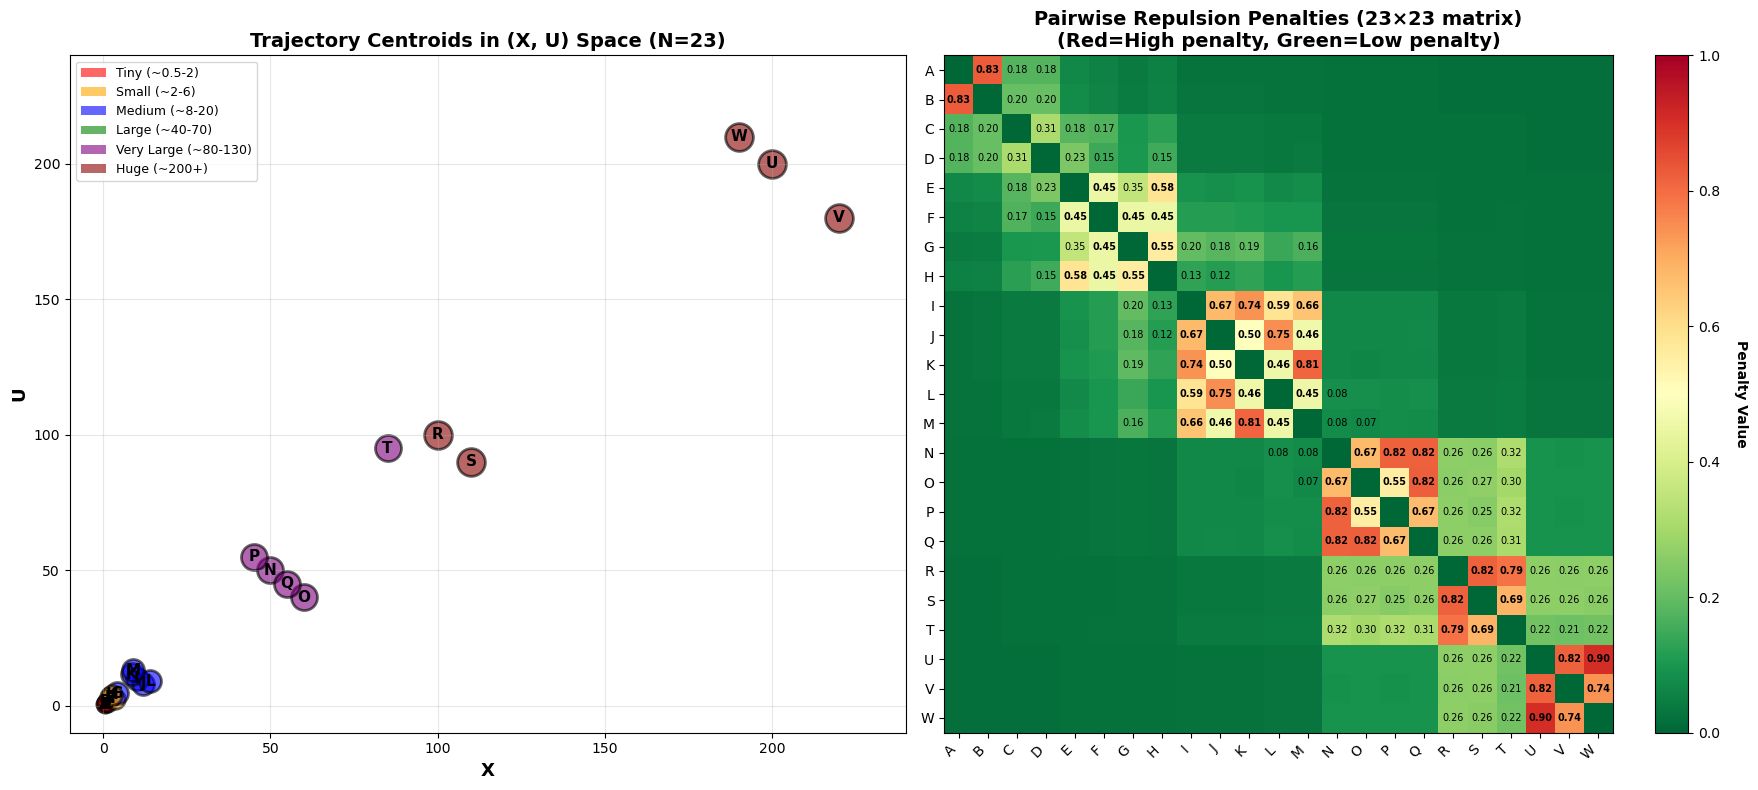


SUMMARY INSIGHTS

📊 Batch Statistics (N=23 trajectories, 253 unique pairs):
  • Penalty range: [0.0187, 0.9049]
  • Mean penalty: 0.1408
  • High penalties (>0.5): 22 pairs (8.7%)
  • Medium penalties (0.1-0.5): 52 pairs
  • Low penalties (<0.1): 179 pairs (70.8%)

🌡️ Temperature Statistics:
  • T_ij range: [0.37, 141.86]
  • Mean T_ij: 35.76
  • Temperature span: 382.1x difference

📏 Distance Statistics:
  • Distance range: [0.07, 283.55]
  • Mean distance: 97.37

✨ Key Observations:
  • Same-scale clusters (visible as block patterns) → HIGH penalties
  • Cross-scale comparisons → penalties automatically adjusted
  • Temperature adapts 382x across the batch
  • Most pairs (71%) have low penalty → minimal interference

✅ Pairwise adaptive temperature handles mixed-scale batches correctly!


In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Demonstration of pairwise adaptive temperature soft repulsion loss
# This shows how the loss handles mixed-scale batches elegantly

def soft_repulsion_penalty(centroid_i, centroid_j, k=0.5, epsilon=0.001):
    """
    Calculate the soft repulsion penalty between two trajectory centroids.
    
    Parameters:
    -----------
    centroid_i : tuple or array (X_i, U_i)
        First trajectory centroid
    centroid_j : tuple or array (X_j, U_j)
        Second trajectory centroid
    k : float
        Temperature scaling factor (default 0.5)
    epsilon : float
        Safety constant to prevent division by zero (default 0.01)
    
    Returns:
    --------
    penalty : float
        exp(-d_ij / T_ij) where penalty ∈ [0, 1]
        - 1.0 means complete overlap (maximum penalty)
        - ~0.0 means well separated (minimal penalty)
    """
    X_i, U_i = centroid_i
    X_j, U_j = centroid_j
    
    # Calculate magnitudes (distance from origin)
    mag_i = np.sqrt(X_i**2 + U_i**2)
    mag_j = np.sqrt(X_j**2 + U_j**2)
    
    # Pairwise adaptive temperature (arithmetic mean)
    T_ij = max(epsilon, k * (mag_i + mag_j) / 2)
    
    # Distance between centroids
    d_ij = np.sqrt((X_i - X_j)**2 + (U_i - U_j)**2)
    
    # Soft repulsion penalty
    penalty = np.exp(-d_ij / T_ij)
    
    return penalty, d_ij, T_ij, mag_i, mag_j


# Simulate a batch with diverse scales
print("="*70)
print("SOFT REPULSION PENALTY DEMONSTRATION")
print("="*70)
print("\nSimulating a batch with trajectories at different scales...")
print()

# Create centroids at different scales - expanded batch
centroids = {
    # Tiny scale (~0.5-2)
    'A': (0.5, 0.5),
    'B': (0.55, 0.55),
    'C': (1.5, 0.8),
    'D': (0.8, 1.5),
    
    # Small scale (~2-5)
    'E': (2.0, 3.0),
    'F': (3.5, 2.5),
    'G': (4.0, 4.5),
    'H': (2.5, 4.0),
    
    # Medium scale (~8-15)
    'I': (10.0, 10.0),
    'J': (12.0, 8.0),
    'K': (8.5, 11.5),
    'L': (14.0, 9.0),
    'M': (9.0, 13.0),
    
    # Large scale (~40-60)
    'N': (50.0, 50.0),
    'O': (60.0, 40.0),
    'P': (45.0, 55.0),
    'Q': (55.0, 45.0),
    
    # Very large scale (~80-120)
    'R': (100.0, 100.0),
    'S': (110.0, 90.0),
    'T': (85.0, 95.0),
    
    # Huge scale (~200+)
    'U': (200.0, 200.0),
    'V': (220.0, 180.0),
    'W': (190.0, 210.0)
}


k = 0.5 # Temperature scaling factor

print(f"Using k = {k}")
print(f"Temperature formula: T_ij = max(0.01, {k} × (||c_i|| + ||c_j||) / 2)")
print()

# Calculate all pairwise penalties
print("="*70)
print("PAIRWISE COMPARISONS")
print("="*70)

traj_names = list(centroids.keys())
interesting_pairs = [
    # Same scale, close together
    ('A', 'B'),      # Tiny scale, very close
    ('E', 'H'),      # Small scale, moderate distance
    ('I', 'J'),      # Medium scale, close
    ('N', 'Q'),      # Large scale, close
    ('R', 'S'),      # Very large scale, close
    ('U', 'V'),      # Huge scale, close
    
    # Same scale, further apart
    ('A', 'D'),      # Tiny scale, corners
    ('I', 'M'),      # Medium scale, corners
    
    # Adjacent scales
    ('B', 'E'),      # Tiny to small
    ('G', 'I'),      # Small to medium
    ('L', 'N'),      # Medium to large
    ('P', 'R'),      # Large to very large
    
    # Very different scales
    ('A', 'U'),      # Tiny to huge
    ('C', 'R'),      # Tiny to very large
    ('E', 'N'),      # Small to large
    ('I', 'U'),      # Medium to huge
]

for name_i, name_j in interesting_pairs:
    ci = centroids[name_i]
    cj = centroids[name_j]
    
    penalty, dist, temp, mag_i, mag_j = soft_repulsion_penalty(ci, cj, k=k)
    
    print(f"\n{name_i} vs {name_j}")
    print(f"  Centroids: {ci} vs {cj}")
    print(f"  Magnitudes: {mag_i:.2f} vs {mag_j:.2f}")
    print(f"  Distance: d_ij = {dist:.2f}")
    print(f"  Temperature: T_ij = {temp:.2f}")
    print(f"  Ratio: d/T = {dist/temp:.2f}")
    print(f"  PENALTY: {penalty:.4f} {'🔴 HIGH' if penalty > 0.5 else '🟡 MEDIUM' if penalty > 0.1 else '🟢 LOW'}")

# Visualize the centroids and penalty matrix
print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Trajectory centroids in (X, U) space
coords = np.array(list(centroids.values()))
names = list(centroids.keys())

# Define colors and sizes based on scale
def get_color_and_size(coord):
    mag = np.sqrt(coord[0]**2 + coord[1]**2)
    if mag < 2:
        return 'red', 150
    elif mag < 6:
        return 'orange', 200
    elif mag < 20:
        return 'blue', 250
    elif mag < 70:
        return 'green', 300
    elif mag < 130:
        return 'purple', 350
    else:
        return 'darkred', 400

colors = []
sizes = []
for coord in coords:
    color, size = get_color_and_size(coord)
    colors.append(color)
    sizes.append(size)

for i, (name, coord) in enumerate(centroids.items()):
    ax1.scatter(coord[0], coord[1], s=sizes[i], c=colors[i], alpha=0.6, 
                edgecolors='black', linewidth=2)
    ax1.annotate(name, coord, fontsize=11, fontweight='bold',
                ha='center', va='center')

ax1.set_xlabel('X', fontsize=13, fontweight='bold')
ax1.set_ylabel('U', fontsize=13, fontweight='bold')
ax1.set_title(f'Trajectory Centroids in (X, U) Space (N={len(centroids)})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-10, 240)
ax1.set_ylim(-10, 240)

# Add legend for scales
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.6, label='Tiny (~0.5-2)'),
    Patch(facecolor='orange', alpha=0.6, label='Small (~2-6)'),
    Patch(facecolor='blue', alpha=0.6, label='Medium (~8-20)'),
    Patch(facecolor='green', alpha=0.6, label='Large (~40-70)'),
    Patch(facecolor='purple', alpha=0.6, label='Very Large (~80-130)'),
    Patch(facecolor='darkred', alpha=0.6, label='Huge (~200+)')
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=9)

# Plot 2: Penalty matrix heatmap
n = len(centroids)
penalty_matrix = np.zeros((n, n))

for i, name_i in enumerate(traj_names):
    for j, name_j in enumerate(traj_names):
        if i != j:
            ci = centroids[name_i]
            cj = centroids[name_j]
            penalty, _, _, _, _ = soft_repulsion_penalty(ci, cj, k=k)
            penalty_matrix[i, j] = penalty

im = ax2.imshow(penalty_matrix, cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
ax2.set_xticks(range(n))
ax2.set_yticks(range(n))
ax2.set_xticklabels([name for name in traj_names], rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels([name for name in traj_names], fontsize=10)
ax2.set_title(f'Pairwise Repulsion Penalties ({n}×{n} matrix)\n(Red=High penalty, Green=Low penalty)', 
              fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Penalty Value', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations for penalties (smaller font for readability with more centroids)
for i in range(n):
    for j in range(n):
        if i != j:
            penalty_val = penalty_matrix[i, j]
            # Only show text if penalty is significant or for diagonal neighbors
            if penalty_val > 0.15 or abs(i - j) <= 2:
                text = ax2.text(j, i, f'{penalty_val:.2f}',
                              ha="center", va="center", color="black", fontsize=7,
                              fontweight='bold' if penalty_val > 0.4 else 'normal')

plt.tight_layout()
plt.savefig('repulsion_penalties.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved as 'repulsion_penalties.png'")
plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY INSIGHTS")
print("="*70)

# Calculate statistics
all_penalties = []
all_temps = []
all_dists = []
for i, name_i in enumerate(traj_names):
    for j, name_j in enumerate(traj_names):
        if i < j:  # Only unique pairs
            ci = centroids[name_i]
            cj = centroids[name_j]
            penalty, dist, temp, _, _ = soft_repulsion_penalty(ci, cj, k=k)
            all_penalties.append(penalty)
            all_temps.append(temp)
            all_dists.append(dist)

all_penalties = np.array(all_penalties)
all_temps = np.array(all_temps)
all_dists = np.array(all_dists)

print(f"\n📊 Batch Statistics (N={len(centroids)} trajectories, {len(all_penalties)} unique pairs):")
print(f"  • Penalty range: [{all_penalties.min():.4f}, {all_penalties.max():.4f}]")
print(f"  • Mean penalty: {all_penalties.mean():.4f}")
print(f"  • High penalties (>0.5): {(all_penalties > 0.5).sum()} pairs ({100*(all_penalties > 0.5).sum()/len(all_penalties):.1f}%)")
print(f"  • Medium penalties (0.1-0.5): {((all_penalties > 0.1) & (all_penalties <= 0.5)).sum()} pairs")
print(f"  • Low penalties (<0.1): {(all_penalties <= 0.1).sum()} pairs ({100*(all_penalties <= 0.1).sum()/len(all_penalties):.1f}%)")
print(f"\n🌡️ Temperature Statistics:")
print(f"  • T_ij range: [{all_temps.min():.2f}, {all_temps.max():.2f}]")
print(f"  • Mean T_ij: {all_temps.mean():.2f}")
print(f"  • Temperature span: {all_temps.max() / all_temps.min():.1f}x difference")
print(f"\n📏 Distance Statistics:")
print(f"  • Distance range: [{all_dists.min():.2f}, {all_dists.max():.2f}]")
print(f"  • Mean distance: {all_dists.mean():.2f}")
print(f"\n✨ Key Observations:")
print(f"  • Same-scale clusters (visible as block patterns) → HIGH penalties")
print(f"  • Cross-scale comparisons → penalties automatically adjusted")
print(f"  • Temperature adapts {all_temps.max() / all_temps.min():.0f}x across the batch")
print(f"  • Most pairs ({100*(all_penalties <= 0.1).sum()/len(all_penalties):.0f}%) have low penalty → minimal interference")
print("\n✅ Pairwise adaptive temperature handles mixed-scale batches correctly!")

FIXED TEMPERATURE SOFT REPULSION DEMONSTRATION

Simulating a batch with trajectories at different scales...

Using FIXED temperature: T = 10.0
Temperature formula: T = 10.0 (constant for ALL pairs)

PAIRWISE COMPARISONS

A vs B
  Centroids: (0.5, 0.5) vs (1.0, 1.0)
  Magnitudes: 0.71 vs 1.41
  Distance: d_ij = 0.71
  Temperature: T = 10.00 (FIXED)
  Ratio: d/T = 0.07
  PENALTY: 0.9317 🔴 HIGH

E vs H
  Centroids: (2.0, 3.0) vs (2.5, 4.0)
  Magnitudes: 3.61 vs 4.72
  Distance: d_ij = 1.12
  Temperature: T = 10.00 (FIXED)
  Ratio: d/T = 0.11
  PENALTY: 0.8942 🔴 HIGH

I vs J
  Centroids: (10.0, 10.0) vs (12.0, 8.0)
  Magnitudes: 14.14 vs 14.42
  Distance: d_ij = 2.83
  Temperature: T = 10.00 (FIXED)
  Ratio: d/T = 0.28
  PENALTY: 0.7536 🔴 HIGH

N vs Q
  Centroids: (50.0, 50.0) vs (55.0, 45.0)
  Magnitudes: 70.71 vs 71.06
  Distance: d_ij = 7.07
  Temperature: T = 10.00 (FIXED)
  Ratio: d/T = 0.71
  PENALTY: 0.4931 🟡 MEDIUM

R vs S
  Centroids: (100.0, 100.0) vs (110.0, 90.0)
  Magnitudes: 

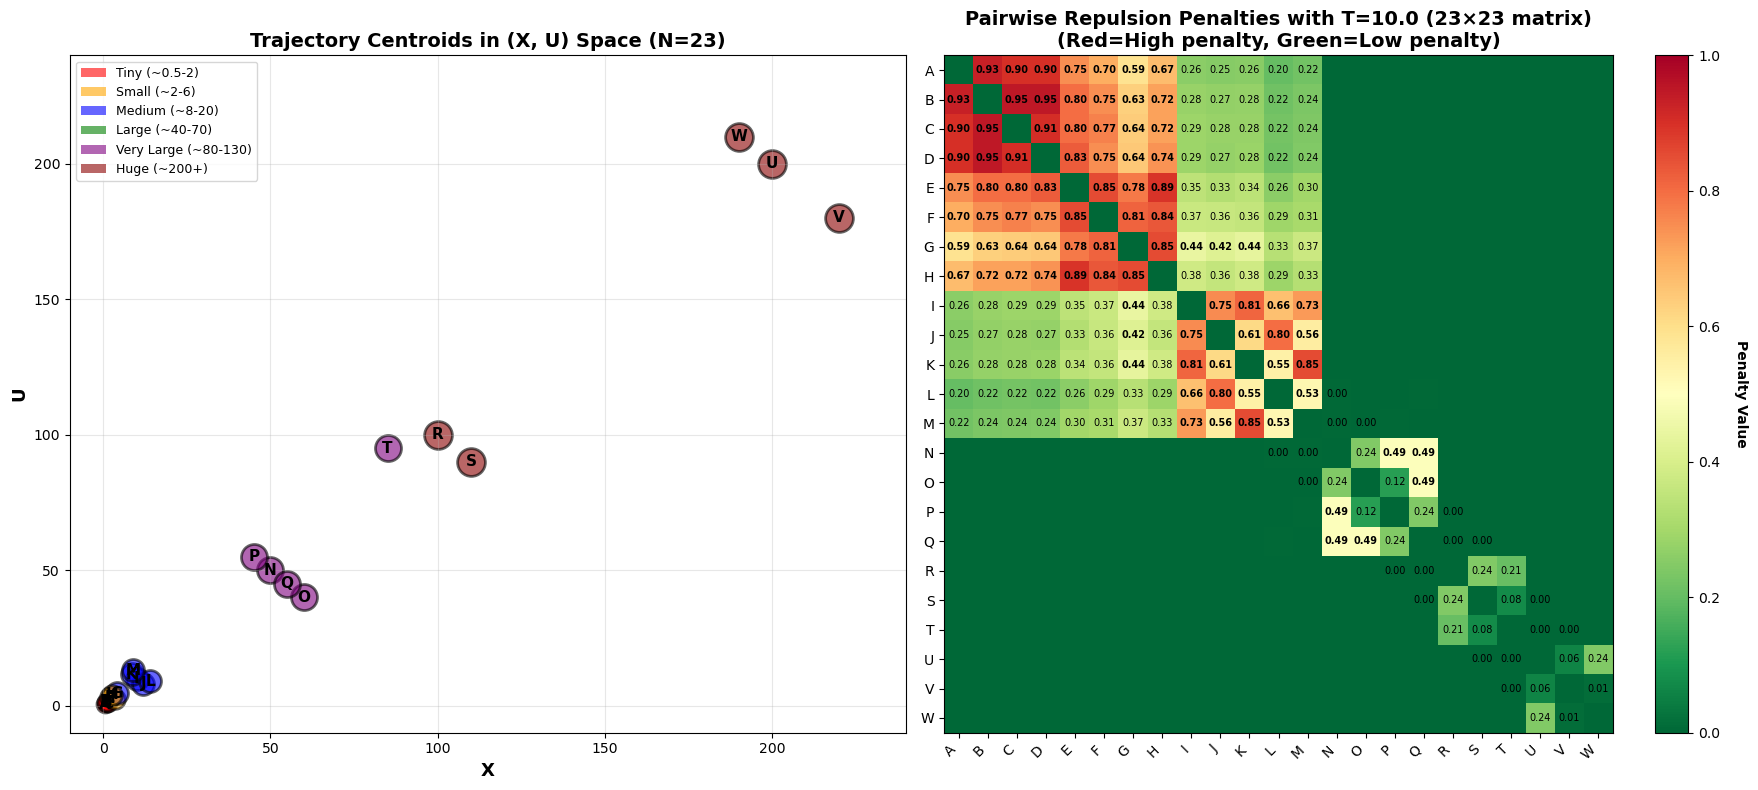


SUMMARY INSIGHTS

📊 Batch Statistics (N=23 trajectories, 253 unique pairs):
  • Fixed Temperature: T = 10.0 (same for ALL pairs)
  • Penalty range: [0.0000, 0.9476]
  • Mean penalty: 0.1740
  • High penalties (>0.5): 38 pairs (15.0%)
  • Medium penalties (0.1-0.5): 49 pairs
  • Low penalties (<0.1): 166 pairs (65.6%)

📏 Distance Statistics:
  • Distance range: [0.54, 283.55]
  • Mean distance: 97.32
  • Distance span: 526.5x variation

⚠️  Problems with Fixed Temperature (T=10.0):
  • T=10.0 is a compromise, but still problematic:
    → Too harsh for large scales OR too lenient for small scales
    → Cannot handle mixed-scale batches optimally

💡 Key Insight:
  • With fixed T, you must choose between:
    1. Properly separating small-scale trajectories (small T)
    2. Not over-penalizing large-scale trajectories (large T)
  • You CANNOT do both with a single fixed temperature!

❌ Fixed temperature struggles with mixed-scale batches
✅ Pairwise adaptive temperature solves this problem!

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Demonstration of FIXED temperature soft repulsion loss
# Compare this with the adaptive temperature approach to see the difference

def soft_repulsion_penalty_fixed(centroid_i, centroid_j, T_fixed=1.0, epsilon=0.01):
    """
    Calculate the soft repulsion penalty between two trajectory centroids
    using a FIXED temperature (not adaptive).
    
    Parameters:
    -----------
    centroid_i : tuple or array (X_i, U_i)
        First trajectory centroid
    centroid_j : tuple or array (X_j, U_j)
        Second trajectory centroid
    T_fixed : float
        Fixed temperature for all pairs (default 1.0)
    epsilon : float
        Safety constant (not really needed here, but kept for consistency)
    
    Returns:
    --------
    penalty : float
        exp(-d_ij / T_fixed) where penalty ∈ [0, 1]
    """
    X_i, U_i = centroid_i
    X_j, U_j = centroid_j
    
    # Calculate magnitudes (for reporting only)
    mag_i = np.sqrt(X_i**2 + U_i**2)
    mag_j = np.sqrt(X_j**2 + U_j**2)
    
    # FIXED temperature for all pairs
    T = T_fixed
    
    # Distance between centroids
    d_ij = np.sqrt((X_i - X_j)**2 + (U_i - U_j)**2)
    
    # Soft repulsion penalty
    penalty = np.exp(-d_ij / T)
    
    return penalty, d_ij, T, mag_i, mag_j


# Simulate the same batch with diverse scales
print("="*70)
print("FIXED TEMPERATURE SOFT REPULSION DEMONSTRATION")
print("="*70)
print("\nSimulating a batch with trajectories at different scales...")
print()

# Create centroids at different scales - same as adaptive version
centroids = {
    # Tiny scale (~0.5-2)
    'A': (0.5, 0.5),
    'B': (1.0, 1.0),
    'C': (1.5, 0.8),
    'D': (0.8, 1.5),
    
    # Small scale (~2-5)
    'E': (2.0, 3.0),
    'F': (3.5, 2.5),
    'G': (4.0, 4.5),
    'H': (2.5, 4.0),
    
    # Medium scale (~8-15)
    'I': (10.0, 10.0),
    'J': (12.0, 8.0),
    'K': (8.5, 11.5),
    'L': (14.0, 9.0),
    'M': (9.0, 13.0),
    
    # Large scale (~40-60)
    'N': (50.0, 50.0),
    'O': (60.0, 40.0),
    'P': (45.0, 55.0),
    'Q': (55.0, 45.0),
    
    # Very large scale (~80-120)
    'R': (100.0, 100.0),
    'S': (110.0, 90.0),
    'T': (85.0, 95.0),
    
    # Huge scale (~200+)
    'U': (200.0, 200.0),
    'V': (220.0, 180.0),
    'W': (190.0, 210.0)
}

# SET YOUR FIXED TEMPERATURE HERE
T_fixed = 10.0  # Try different values: 1.0, 5.0, 10.0, 50.0, 100.0

print(f"Using FIXED temperature: T = {T_fixed}")
print(f"Temperature formula: T = {T_fixed} (constant for ALL pairs)")
print()

# Calculate all pairwise penalties
print("="*70)
print("PAIRWISE COMPARISONS")
print("="*70)

traj_names = list(centroids.keys())
interesting_pairs = [
    # Same scale, close together
    ('A', 'B'),      # Tiny scale, very close
    ('E', 'H'),      # Small scale, moderate distance
    ('I', 'J'),      # Medium scale, close
    ('N', 'Q'),      # Large scale, close
    ('R', 'S'),      # Very large scale, close
    ('U', 'V'),      # Huge scale, close
    
    # Same scale, further apart
    ('A', 'D'),      # Tiny scale, corners
    ('I', 'M'),      # Medium scale, corners
    
    # Adjacent scales
    ('B', 'E'),      # Tiny to small
    ('G', 'I'),      # Small to medium
    ('L', 'N'),      # Medium to large
    ('P', 'R'),      # Large to very large
    
    # Very different scales
    ('A', 'U'),      # Tiny to huge
    ('C', 'R'),      # Tiny to very large
    ('E', 'N'),      # Small to large
    ('I', 'U'),      # Medium to huge
]

for name_i, name_j in interesting_pairs:
    ci = centroids[name_i]
    cj = centroids[name_j]
    
    penalty, dist, temp, mag_i, mag_j = soft_repulsion_penalty_fixed(ci, cj, T_fixed=T_fixed)
    
    print(f"\n{name_i} vs {name_j}")
    print(f"  Centroids: {ci} vs {cj}")
    print(f"  Magnitudes: {mag_i:.2f} vs {mag_j:.2f}")
    print(f"  Distance: d_ij = {dist:.2f}")
    print(f"  Temperature: T = {temp:.2f} (FIXED)")
    print(f"  Ratio: d/T = {dist/temp:.2f}")
    print(f"  PENALTY: {penalty:.4f} {'🔴 HIGH' if penalty > 0.5 else '🟡 MEDIUM' if penalty > 0.1 else '🟢 LOW'}")

# Visualize the centroids and penalty matrix
print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Trajectory centroids in (X, U) space
coords = np.array(list(centroids.values()))
names = list(centroids.keys())

# Define colors and sizes based on scale
def get_color_and_size(coord):
    mag = np.sqrt(coord[0]**2 + coord[1]**2)
    if mag < 2:
        return 'red', 150
    elif mag < 6:
        return 'orange', 200
    elif mag < 20:
        return 'blue', 250
    elif mag < 70:
        return 'green', 300
    elif mag < 130:
        return 'purple', 350
    else:
        return 'darkred', 400

colors = []
sizes = []
for coord in coords:
    color, size = get_color_and_size(coord)
    colors.append(color)
    sizes.append(size)

for i, (name, coord) in enumerate(centroids.items()):
    ax1.scatter(coord[0], coord[1], s=sizes[i], c=colors[i], alpha=0.6, 
                edgecolors='black', linewidth=2)
    ax1.annotate(name, coord, fontsize=11, fontweight='bold',
                ha='center', va='center')

ax1.set_xlabel('X', fontsize=13, fontweight='bold')
ax1.set_ylabel('U', fontsize=13, fontweight='bold')
ax1.set_title(f'Trajectory Centroids in (X, U) Space (N={len(centroids)})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-10, 240)
ax1.set_ylim(-10, 240)

# Add legend for scales
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.6, label='Tiny (~0.5-2)'),
    Patch(facecolor='orange', alpha=0.6, label='Small (~2-6)'),
    Patch(facecolor='blue', alpha=0.6, label='Medium (~8-20)'),
    Patch(facecolor='green', alpha=0.6, label='Large (~40-70)'),
    Patch(facecolor='purple', alpha=0.6, label='Very Large (~80-130)'),
    Patch(facecolor='darkred', alpha=0.6, label='Huge (~200+)')
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=9)

# Plot 2: Penalty matrix heatmap
n = len(centroids)
penalty_matrix = np.zeros((n, n))

for i, name_i in enumerate(traj_names):
    for j, name_j in enumerate(traj_names):
        if i != j:
            ci = centroids[name_i]
            cj = centroids[name_j]
            penalty, _, _, _, _ = soft_repulsion_penalty_fixed(ci, cj, T_fixed=T_fixed)
            penalty_matrix[i, j] = penalty

im = ax2.imshow(penalty_matrix, cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
ax2.set_xticks(range(n))
ax2.set_yticks(range(n))
ax2.set_xticklabels([name for name in traj_names], rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels([name for name in traj_names], fontsize=10)
ax2.set_title(f'Pairwise Repulsion Penalties with T={T_fixed} ({n}×{n} matrix)\n(Red=High penalty, Green=Low penalty)', 
              fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Penalty Value', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations for penalties
for i in range(n):
    for j in range(n):
        if i != j:
            penalty_val = penalty_matrix[i, j]
            # Only show text if penalty is significant or for diagonal neighbors
            if penalty_val > 0.15 or abs(i - j) <= 2:
                text = ax2.text(j, i, f'{penalty_val:.2f}',
                              ha="center", va="center", color="black", fontsize=7,
                              fontweight='bold' if penalty_val > 0.4 else 'normal')

plt.tight_layout()
plt.savefig('repulsion_penalties_fixed.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved as 'repulsion_penalties_fixed.png'")
plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY INSIGHTS")
print("="*70)

# Calculate statistics
all_penalties = []
all_temps = []
all_dists = []
for i, name_i in enumerate(traj_names):
    for j, name_j in enumerate(traj_names):
        if i < j:  # Only unique pairs
            ci = centroids[name_i]
            cj = centroids[name_j]
            penalty, dist, temp, _, _ = soft_repulsion_penalty_fixed(ci, cj, T_fixed=T_fixed)
            all_penalties.append(penalty)
            all_temps.append(temp)
            all_dists.append(dist)

all_penalties = np.array(all_penalties)
all_temps = np.array(all_temps)
all_dists = np.array(all_dists)

print(f"\n📊 Batch Statistics (N={len(centroids)} trajectories, {len(all_penalties)} unique pairs):")
print(f"  • Fixed Temperature: T = {T_fixed} (same for ALL pairs)")
print(f"  • Penalty range: [{all_penalties.min():.4f}, {all_penalties.max():.4f}]")
print(f"  • Mean penalty: {all_penalties.mean():.4f}")
print(f"  • High penalties (>0.5): {(all_penalties > 0.5).sum()} pairs ({100*(all_penalties > 0.5).sum()/len(all_penalties):.1f}%)")
print(f"  • Medium penalties (0.1-0.5): {((all_penalties > 0.1) & (all_penalties <= 0.5)).sum()} pairs")
print(f"  • Low penalties (<0.1): {(all_penalties <= 0.1).sum()} pairs ({100*(all_penalties <= 0.1).sum()/len(all_penalties):.1f}%)")
print(f"\n📏 Distance Statistics:")
print(f"  • Distance range: [{all_dists.min():.2f}, {all_dists.max():.2f}]")
print(f"  • Mean distance: {all_dists.mean():.2f}")
print(f"  • Distance span: {all_dists.max() / all_dists.min():.1f}x variation")

print(f"\n⚠️  Problems with Fixed Temperature (T={T_fixed}):")
if T_fixed < 5:
    print(f"  • T={T_fixed} is TOO SMALL for large-scale trajectories")
    print(f"    → Huge trajectories get penalized even when very far apart")
    print(f"    → See high penalties in bottom-right corner of matrix")
elif T_fixed > 20:
    print(f"  • T={T_fixed} is TOO LARGE for small-scale trajectories")
    print(f"    → Tiny trajectories don't get penalized even when close")
    print(f"    → See low penalties in top-left corner of matrix")
else:
    print(f"  • T={T_fixed} is a compromise, but still problematic:")
    print(f"    → Too harsh for large scales OR too lenient for small scales")
    print(f"    → Cannot handle mixed-scale batches optimally")

print(f"\n💡 Key Insight:")
print(f"  • With fixed T, you must choose between:")
print(f"    1. Properly separating small-scale trajectories (small T)")
print(f"    2. Not over-penalizing large-scale trajectories (large T)")
print(f"  • You CANNOT do both with a single fixed temperature!")
print(f"\n❌ Fixed temperature struggles with mixed-scale batches")
print(f"✅ Pairwise adaptive temperature solves this problem!")

In [7]:
def get_data_from_trajectory_id(ids_df, data_df, trajectory_ids):
    """
    Return the exact portion(s) of `data_df` corresponding to one or more trajectory_ids.
    - Preserves data_df's original indexing (no reset).
    - If trajectory_ids contains all ids in ids_df, returns data_df unchanged.
    - If any requested id is missing, prints missing ids and returns None.
    """
    # normalize to list of ints (preserve order)
    if isinstance(trajectory_ids, (np.integer, int)):
        trajectory_ids = [int(trajectory_ids)]
    else:
        trajectory_ids = [int(x) for x in trajectory_ids]

    # ensure id columns are ints in ids_df
    ids_df = ids_df.copy()
    for col in ("start_index", "end_index", "generated_points", "trajectory_id"):
        if col in ids_df.columns:
            ids_df[col] = ids_df[col].astype("int64")

    existing_ids = list(ids_df["trajectory_id"].values)
    missing = [tid for tid in trajectory_ids if tid not in existing_ids]
    if missing:
        print(f"trajectory_id(s) {missing} not in ids_df. Pick from {existing_ids}")
        return None

    # special-case: request for all trajectories -> return full data_df unchanged
    if set(trajectory_ids) == set(existing_ids):
        return data_df

    parts = []
    for tid in trajectory_ids:
        row = ids_df.loc[ids_df["trajectory_id"] == tid].iloc[0]
        start = int(row["start_index"])
        end = int(row["end_index"])   # exclusive by your convention

        if start >= end:
            # empty trajectory: skip (or you can append an empty frame if you prefer)
            continue

        # label-based selection: .loc is inclusive on the right, so use end-1
        sub = data_df.loc[start : end - 1]
        parts.append(sub)

    if not parts:
        # nothing found (all requested trajectories empty)
        return data_df.iloc[0:0]   # empty DataFrame with same columns

    # if single part, return it directly (preserves original index)
    if len(parts) == 1:
        return parts[0]
    # multiple parts: concatenate preserving indices and order
    return pd.concat(parts)

def get_trajectory_ids_by_energies(ids_df, want_more_energy, energy_percentile):
    if want_more_energy==False:
        return list(ids_df[ids_df['energy'] < ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    if want_more_energy==True:
        return list(ids_df[ids_df['energy'] > ids_df['energy'].quantile(energy_percentile)]['trajectory_id'])
    

In [10]:
def find_valid_combinations(train_df, train_id_df, max_segment_length=20, max_n_segments=50):
    results = []
    
    total_points = len(train_df)
    n_trajectories = len(train_id_df['trajectory_id'].unique())
    
    # Get actual trajectory lengths (might vary)
    traj_lengths = []
    for _, row in train_id_df.iterrows():
        length = int(row['end_index'] - row['start_index'])
        traj_lengths.append(length)
    
    # If all trajectories same length, use that; otherwise use minimum
    if len(set(traj_lengths)) == 1:
        points_per_traj = traj_lengths[0]
    else:
        points_per_traj = min(traj_lengths)
        print(f"Warning: Trajectories have different lengths. Using minimum: {points_per_traj}")
    
    # Find divisors of points_per_traj for valid segment lengths
    valid_segment_lengths = []
    for s in range(1, min(max_segment_length + 1, points_per_traj + 1)):
        if points_per_traj % s == 0:
            valid_segment_lengths.append(s)
    
    for segment_length in valid_segment_lengths:
        max_segments_per_traj = points_per_traj // segment_length
        
        for n_segments in range(1, min(max_n_segments + 1, max_segments_per_traj + 1)):
            # Check if trajectories can be evenly distributed across batches
            if max_segments_per_traj % n_segments != 0:
                continue
            
            batches_per_traj = max_segments_per_traj // n_segments
            
            # Try different batch compositions
            for batch_traj in range(1, n_trajectories + 1):
                # Total batches must use all trajectories evenly
                if (n_trajectories * batches_per_traj) % batch_traj != 0:
                    continue
                
                total_batches = (n_trajectories * batches_per_traj) // batch_traj
                
                # Verify coverage
                total_points_covered = total_batches * batch_traj * n_segments * segment_length
                
                # For exact coverage (adjust if allowing partial coverage)
                if total_points_covered != n_trajectories * points_per_traj:
                    continue
                
                batch_ppt = n_segments * segment_length
                batch_size = batch_traj * batch_ppt
                ratio = batch_ppt / batch_traj
                

                
                results.append({
                    "segment_length": segment_length,
                    "n_segments": n_segments,
                    "batch_traj": batch_traj,
                    "batch_ppt": batch_ppt,
                    "batch_size": batch_size,
                    "total_batches": total_batches,
                    "ratio": ratio,
                    "coverage_pct": (total_points_covered / total_points) * 100,
                    "points_per_traj": points_per_traj
                })
    
    df = pd.DataFrame(results)
    
    if len(df) == 0:
        print("No valid combinations found with given constraints!")
        print(f"Dataset: {total_points} points, {n_trajectories} trajectories, {points_per_traj} points/traj")
        print(f"Valid segment lengths: {valid_segment_lengths[:10]}...")
    
    return df

df_valid_combinations_new = find_valid_combinations(train_df, train_id_df, max_segment_length=20, max_n_segments=50)
df_valid_combinations_new[(df_valid_combinations_new['ratio'] >= 1.8) & (df_valid_combinations_new['ratio'] <= 2.6)]


,segment_length,n_segments,batch_traj,batch_ppt,batch_size,total_batches,ratio,coverage_pct,points_per_traj
19,1,2,1,2,2,11616,2.000000,100.0,242
41,1,11,6,11,66,352,1.833333,100.0,242
62,1,22,11,22,242,96,2.000000,100.0,242
63,1,22,12,22,264,88,1.833333,100.0,242
74,2,1,1,2,2,11616,2.000000,100.0,242
98,2,11,11,22,242,96,2.000000,100.0,242
99,2,11,12,22,264,88,1.833333,100.0,242
114,11,1,6,11,66,352,1.833333,100.0,242
135,11,2,11,22,242,96,2.000000,100.0,242
136,11,2,12,22,264,88,1.833333,100.0,242


In [11]:
len(val_id_df['trajectory_id'].unique())

12

In [11]:
class SimpleHarmonicDataLoader:
    def __init__(self, train_df, train_id_df, ratio, batch_size, segment_length, get_data_func, seed=42):
        """
        Simple dataloader with guaranteed full coverage.
        
        Args:
            ratio: points_per_trajectory / trajectories_per_batch
            batch_size: total points per batch
            segment_length: consecutive points per segment
        """
        self.train_df = train_df
        self.train_id_df = train_id_df
        self.get_data_func = get_data_func
        self.ratio = ratio
        self.batch_size = batch_size
        self.segment_length = segment_length
        
        np.random.seed(seed)
        
        # Calculate derived parameters
        self.n_trajectories = len(train_id_df['trajectory_id'].unique())
        self.total_points = len(train_df)
        self.points_per_traj = self.total_points // self.n_trajectories
        
        # Validate hyperparameters
        valid_df = find_valid_combinations(train_df, train_id_df, max_segment_length=25, max_n_segments=50)
        valid_params = valid_df[
            (np.isclose(valid_df['ratio'], ratio, rtol=0.01)) & 
            (valid_df['batch_size'] == batch_size) & 
            (valid_df['segment_length'] == segment_length)
        ]
        
        if len(valid_params) == 0:
            raise ValueError(f"Invalid hyperparameters: ratio={ratio}, batch_size={batch_size}, segment_length={segment_length}")
        
        # Extract validated parameters
        row = valid_params.iloc[0]
        self.batch_traj = int(row['batch_traj'])
        self.n_segments = int(row['n_segments'])
        self.total_batches = int(row['total_batches'])
        
        # Compatibility aliases for validation function
        self.actual_batch_size = self.batch_size
        self.number_of_trajectories = self.batch_traj
        self.points_per_trajectory = self.n_segments * self.segment_length
        self.segments_per_trajectory = self.n_segments
        
        print(f"Dataloader initialized:")
        print(f"  Trajectories per batch: {self.batch_traj}")
        print(f"  Segments per trajectory: {self.n_segments}")
        print(f"  Points per trajectory: {self.points_per_trajectory}")
        print(f"  Total batches: {self.total_batches}")
        
        self.trajectory_segments = {}
        for _, row in train_id_df.iterrows():
            tid = int(row['trajectory_id'])
            start_idx = int(row['start_index'])
            
            # All possible segment starting positions for this trajectory
            segments = []
            for i in range(0, self.points_per_traj, self.segment_length):
                segments.append(start_idx + i)
            self.trajectory_segments[tid] = segments
        
        # Generate epoch plan
        self._generate_epoch_plan()
 
    
    def _generate_epoch_plan(self):
        """Generate batches with more balanced trajectory usage."""
        self.batches = []
        
        # Track remaining segments for each trajectory
        remaining_segments = {}
        for tid, segments in self.trajectory_segments.items():
            remaining_segments[tid] = segments.copy()
        
        while True:
            # Find trajectories with at least n_segments remaining
            available = [(tid, len(segs)) for tid, segs in remaining_segments.items() 
                        if len(segs) >= self.n_segments]
            
            if len(available) < self.batch_traj:
                # Final batch with all remaining trajectories that have segments
                if available:
                    batch_data = {}
                    for tid, _ in available:
                        segments = remaining_segments[tid]
                        np.random.shuffle(segments)
                        selected = segments[:min(self.n_segments, len(segments))]
                        batch_data[tid] = selected
                        # Remove used segments
                        for seg in selected:
                            remaining_segments[tid].remove(seg)
                    self.batches.append(batch_data)
                break
            
            # Sort by number of remaining segments (descending) to prioritize fuller trajectories
            available.sort(key=lambda x: x[1], reverse=True)
            
            # Add some randomness but favor trajectories with more segments
            # Take top 2*batch_traj candidates and randomly select from them
            candidates = [tid for tid, _ in available[:min(2 * self.batch_traj, len(available))]]
            np.random.shuffle(candidates)
            selected_tids = candidates[:self.batch_traj]
            
            # Build batch
            batch_data = {}
            for tid in selected_tids:
                segments = remaining_segments[tid]
                np.random.shuffle(segments)
                selected = segments[:self.n_segments]
                batch_data[tid] = selected
                # Remove used segments
                for seg in selected:
                    remaining_segments[tid].remove(seg)
            
            self.batches.append(batch_data)
        
        print(f"Generated {len(self.batches)} batches")
        if self.batches and len(self.batches[-1]) < self.batch_traj:
            print(f"Last batch has {len(self.batches[-1])} trajectories (partial batch)")
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        """Get batch data."""
        batch_data = self.batches[idx]
        
        x_list, u_list, t_list, tid_list, energy_list = [], [], [], [], []
        
        for tid, segment_starts in batch_data.items():
            # Get trajectory data once
            traj_data = self.get_data_func(self.train_id_df, self.train_df, tid)
            traj_info = self.train_id_df[self.train_id_df['trajectory_id'] == tid].iloc[0]
            traj_start = int(traj_info['start_index'])
            energy = traj_info['energy']
            
            # Process each segment
            for seg_start in segment_starts:
                for offset in range(self.segment_length):
                    relative_idx = seg_start - traj_start + offset
                    x_list.append(traj_data.iloc[relative_idx]['x'])
                    u_list.append(traj_data.iloc[relative_idx]['u'])
                    t_list.append(traj_data.iloc[relative_idx]['t'])
                    tid_list.append(tid)
                    energy_list.append(energy)
        
        return {
            'x': torch.tensor(x_list, dtype=torch.float32),
            'u': torch.tensor(u_list, dtype=torch.float32),
            't': torch.tensor(t_list, dtype=torch.float32),
            'trajectory_ids': torch.tensor(tid_list, dtype=torch.long),
            'energies': torch.tensor(energy_list, dtype=torch.float32)
        }


def create_simple_dataloader(train_df, train_id_df, ratio, batch_size, segment_length, get_data_func, seed=42):
    """Create dataloader with validation."""
    dataset = SimpleHarmonicDataLoader(
        train_df, train_id_df, ratio, batch_size, segment_length, get_data_func, seed
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=1,  # Dataset handles batching
        shuffle=False,  # Already shuffled in epoch plan
        collate_fn=lambda x: x[0]
    )
    
    return dataloader

In [12]:
df_valid_combinations_new[(df_valid_combinations_new['ratio'] >= 1.5) & (df_valid_combinations_new['ratio'] <= 2.6)]

,segment_length,n_segments,batch_traj,batch_ppt,batch_size,total_batches,ratio,coverage_pct,points_per_traj
19,1,2,1,2,2,11616,2.000000,100.0,242
41,1,11,6,11,66,352,1.833333,100.0,242
62,1,22,11,22,242,96,2.000000,100.0,242
63,1,22,12,22,264,88,1.833333,100.0,242
74,2,1,1,2,2,11616,2.000000,100.0,242
98,2,11,11,22,242,96,2.000000,100.0,242
99,2,11,12,22,264,88,1.833333,100.0,242
114,11,1,6,11,66,352,1.833333,100.0,242
135,11,2,11,22,242,96,2.000000,100.0,242
136,11,2,12,22,264,88,1.833333,100.0,242


In [13]:
# Find valid combinations
valid_df = find_valid_combinations(train_df, train_id_df)
print(valid_df[valid_df['ratio'].between(1.5, 2.6)])

# Pick one valid combination
dataloader = create_simple_dataloader(
    train_df=train_df,
    train_id_df=train_id_df,
    ratio=2.000,
    batch_size=242,
    segment_length=11,
    get_data_func=get_data_from_trajectory_id,
    seed=42
)

     segment_length  n_segments  batch_traj  batch_ppt  batch_size  \
19                1           2           1          2           2   
41                1          11           6         11          66   
62                1          22          11         22         242   
63                1          22          12         22         264   
74                2           1           1          2           2   
98                2          11          11         22         242   
99                2          11          12         22         264   
114              11           1           6         11          66   
135              11           2          11         22         242   
136              11           2          12         22         264   
157              11          11          48        121        5808   
158              11          11          64        121        7744   
171              11          22          96        242       23232   

     total_batches 

In [9]:
def diff_with_previous(nums):
    if not nums:
        return []
    return [nums[0]] + [nums[i] - nums[i-1] for i in range(1, len(nums))]

In [10]:
from collections import Counter

def analyze_gaps(nums):
    # 1) Find smallest number > 1
    greater_than_one = [n for n in nums if n > 1]
    if not greater_than_one:
        return None, False, False  # no valid numbers
    smallest = min(greater_than_one)
    
    # 2) Check divisibility
    divisible = all(n % smallest == 0 for n in greater_than_one)
    
    # 3) Check if it's the most common number
    freq = Counter(nums)
    most_common_num, most_common_count = freq.most_common(1)[0]
    is_most_common = (smallest == most_common_num)
    
    return smallest, divisible, is_most_common




DATALOADER VALIDATION

Expected Parameters:
  - Batch size: 242
  - Trajectories per batch (K): 11
  - Points per trajectory (T): 22
  - Segments per trajectory (S): 2
  - Segment length (w): 11
  - Total batches: 96
  - Total trajectories in dataset: 96


Validating Batch 1/96...

Validating Batch 2/96...

Validating Batch 3/96...

Validating Batch 4/96...

Validating Batch 5/96...

Validating Batch 6/96...

Validating Batch 7/96...

Validating Batch 8/96...

Validating Batch 9/96...

Validating Batch 10/96...

Validating Batch 11/96...

Validating Batch 12/96...

Validating Batch 13/96...

Validating Batch 14/96...

Validating Batch 15/96...

Validating Batch 16/96...

Validating Batch 17/96...

Validating Batch 18/96...

Validating Batch 19/96...

Validating Batch 20/96...

Validating Batch 21/96...

Validating Batch 22/96...

Validating Batch 23/96...

Validating Batch 24/96...

Validating Batch 25/96...

Validating Batch 26/96...

Validating Batch 27/96...

Validating Batch 28/96.

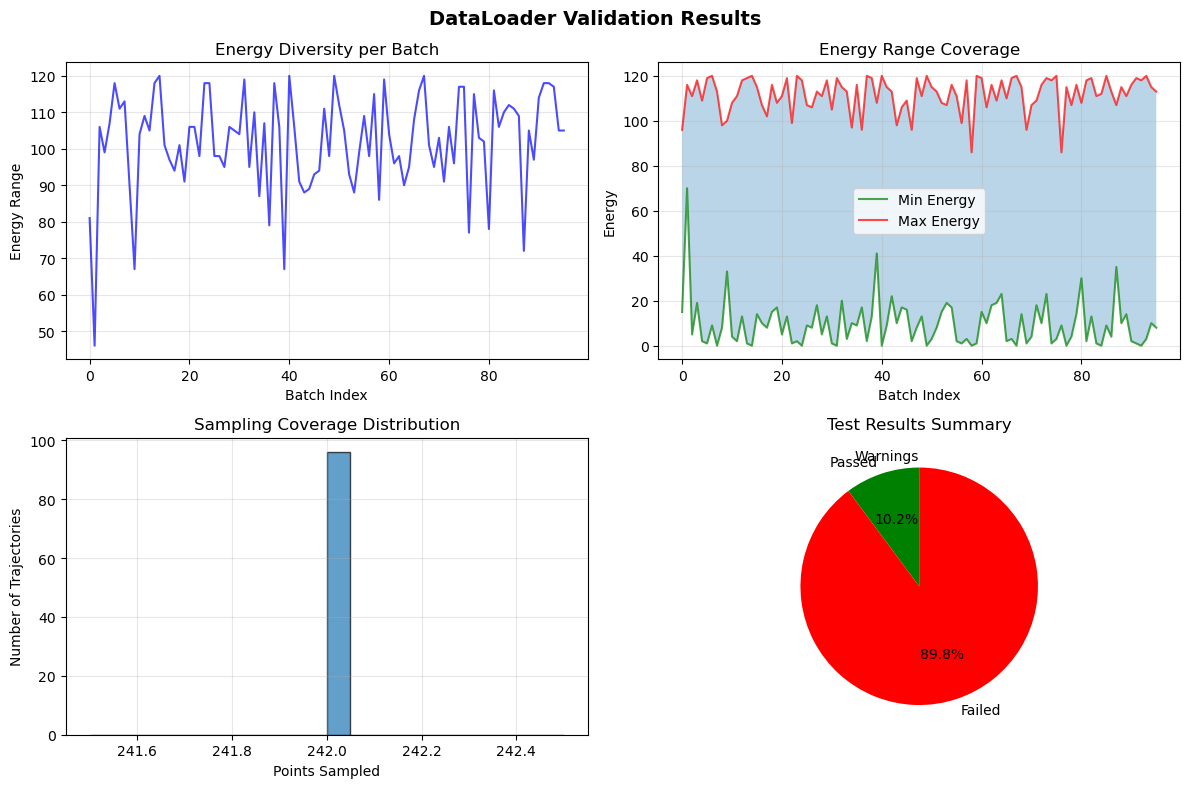

In [39]:

def validate_dataloader_fixed(
    dataloader,
    train_df: pd.DataFrame,
    train_id_df: pd.DataFrame,
    get_data_func,
    verbose: bool = True,
    plot_results: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive validation of the harmonic oscillator dataloader with floating-point tolerance.
    
    Args:
        dataloader: The DataLoader to validate
        train_df: Original training DataFrame
        train_id_df: Trajectory metadata DataFrame
        get_data_func: Function to extract trajectory data
        verbose: Whether to print detailed information
        plot_results: Whether to plot validation results
    
    Returns:
        Dictionary with validation results and statistics
    """
    
    results = {
        'passed_tests': [],
        'failed_tests': [],
        'warnings': [],
        'statistics': {},
        'detailed_info': {}
    }
    
    # Get dataset parameters
    dataset = dataloader.dataset
    expected_batch_size = dataset.actual_batch_size
    expected_trajectories_per_batch = dataset.number_of_trajectories
    expected_points_per_trajectory = dataset.points_per_trajectory
    segment_length = dataset.segment_length
    segments_per_trajectory = dataset.segments_per_trajectory
    
    if verbose:
        print("="*80)
        print("DATALOADER VALIDATION")
        print("="*80)
        print(f"\nExpected Parameters:")
        print(f"  - Batch size: {expected_batch_size}")
        print(f"  - Trajectories per batch (K): {expected_trajectories_per_batch}")
        print(f"  - Points per trajectory (T): {expected_points_per_trajectory}")
        print(f"  - Segments per trajectory (S): {segments_per_trajectory}")
        print(f"  - Segment length (w): {segment_length}")
        print(f"  - Total batches: {len(dataloader)}")
        print(f"  - Total trajectories in dataset: {len(train_id_df)}")
        print("\n" + "="*80)
    
    # Track all sampled points across the epoch
    epoch_points_tracker = defaultdict(set)  # {trajectory_id: set of (relative_index)}
    batch_statistics = []
    
    # Helper function to find index with floating-point tolerance
    def find_time_index(traj_data, t_value, rtol=1e-3, atol=1e-3):
        """Find index of time value with floating-point tolerance."""
        matches = traj_data[np.isclose(traj_data['t'], t_value, rtol=rtol, atol=atol)]
        if len(matches) == 0:
            return None
        return matches.index[0]
    
    # Iterate through all batches
    for batch_idx, batch in enumerate(dataloader):
        if verbose:
            print(f"\nValidating Batch {batch_idx + 1}/{len(dataloader)}...")

        
        # TEST 1: Check batch has same number of x, u, t values
        test_name = f"Batch {batch_idx}: Consistent x, u, t dimensions"
        try:
            assert len(batch['x']) == len(batch['u']) == len(batch['t']), \
                f"Inconsistent dimensions: x={len(batch['x'])}, u={len(batch['u'])}, t={len(batch['t'])}"
            if batch_idx == 0:
                results['passed_tests'].append("Consistent x, u, t dimensions")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # TEST 2: Check batch size
        test_name = f"Batch {batch_idx}: Correct batch size"
        actual_size = len(batch['x'])
        try:
            assert actual_size == expected_batch_size, \
                f"Expected {expected_batch_size}, got {actual_size}"
            if batch_idx == 0:
                results['passed_tests'].append("Correct batch size")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # Group points by trajectory
        trajectory_groups = defaultdict(list)
        for i in range(len(batch['x'])):
            tid = batch['trajectory_ids'][i].item()
            trajectory_groups[tid].append({
                'index': i,
                'x': batch['x'][i].item(),
                'u': batch['u'][i].item(),
                't': batch['t'][i].item(),
                'energy': batch['energies'][i].item()
            })
        
        # TEST 3: Check number of trajectories in batch
        test_name = f"Batch {batch_idx}: Correct number of trajectories"
        try:
            assert len(trajectory_groups) == expected_trajectories_per_batch, \
                f"Expected {expected_trajectories_per_batch} trajectories, got {len(trajectory_groups)}"
            if batch_idx == 0:
                results['passed_tests'].append("Correct number of trajectories per batch")
        except AssertionError as e:
            results['failed_tests'].append(f"{test_name}: {str(e)}")
        
        # TEST 4: Check points per trajectory
        test_name = f"Batch {batch_idx}: Correct points per trajectory"
        points_per_traj_ok = True
        for tid, points in trajectory_groups.items():
            try:
                assert len(points) == expected_points_per_trajectory, \
                    f"Trajectory {tid}: Expected {expected_points_per_trajectory} points, got {len(points)}"
            except AssertionError as e:
                results['failed_tests'].append(f"{test_name}: {str(e)}")
                points_per_traj_ok = False
                break
        if points_per_traj_ok and batch_idx == 0:
            results['passed_tests'].append("Correct points per trajectory")
        
        if len(train_df) > 1:
            expected_dt = train_df.iloc[1]['t'] - train_df.iloc[0]['t']
        else:
            expected_dt = 0.1  # fallback value
        
        # For each trajectory in the batch
        for tid, points in trajectory_groups.items():
            # Get original trajectory data
            traj_data = get_data_func(train_id_df, train_df, tid)

            


            
            # Derive the actual points per segment by analyzing time differences
            consecutive_count = 1
            derived_points_per_segment = 1
            
            
            gap_positions = []
            for i in range(1, len(points)):  
                dt = points[i]['t'] - points[i-1]['t']
                if not np.isclose(dt, expected_dt, rtol=1e-3):  # Consecutive
                    gap_positions.append(i)
            possible_derived_points_per_segment_list = diff_with_previous(gap_positions)
            smallest, divisible, is_most_common = analyze_gaps(possible_derived_points_per_segment_list)
            
            if len(gap_positions) > 0:
                derived_points_per_segment = gap_positions[0]
            else:
                derived_points_per_segment = len(points)
            if (smallest is not None) and (divisible) and (is_most_common):
                derived_points_per_segment=smallest

            
            # Now identify segments based on the derived segment length
            segments = []
            i = 0
            while i < len(points):
                segment = [points[i]]
                j = i + 1
                
                # Collect points that are consecutive (based on dt)
                while j < len(points) and len(segment) < derived_points_per_segment:
                    dt = points[j]['t'] - points[j-1]['t']
                    if np.isclose(dt, expected_dt, rtol=1e-3):
                        segment.append(points[j])
                        j += 1
                    else:
                        break  # Gap found, end this segment
                
                segments.append(segment)
                i = j  # Move to next potential segment start
            
            # Calculate derived number of segments
            derived_segments_per_trajectory = len([s for s in segments if len(s) == derived_points_per_segment])
            
            # TEST 5: Check segment structure consistency
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Segment structure"
            
            # First check if derived matches expected
            if batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                if derived_points_per_segment != segment_length:
                    results['warnings'].append(
                        f"Segment length mismatch: expected {segment_length}, derived {derived_points_per_segment}"
                    )
                    if verbose:
                        print(f"  WARNING: Derived segment length ({derived_points_per_segment}) != expected ({segment_length})")
            
            # Check if number of complete segments matches expected
            #expected_segments_from_derived = len(points) // derived_points_per_segment
            try:
                assert derived_segments_per_trajectory == segments_per_trajectory, \
                    f"Expected {segments_per_trajectory} segments, got {derived_segments_per_trajectory} complete segments of length {derived_points_per_segment}"
                if batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                    results['passed_tests'].append("Correct number of segments per trajectory")
            except AssertionError as e:
                results['failed_tests'].append(f"{test_name}: {str(e)}")
            
            # TEST 6: Check segment lengths and consecutiveness
            for seg_idx, segment in enumerate(segments):
                test_name = f"Batch {batch_idx}, Trajectory {tid}, Segment {seg_idx}: Correct length"
                try:
                    assert len(segment) == segment_length, \
                        f"Expected length {segment_length}, got {len(segment)}"
                    if batch_idx == 0 and tid == list(trajectory_groups.keys())[0] and seg_idx == 0:
                        results['passed_tests'].append("Segments have correct length")
                except AssertionError as e:
                    results['failed_tests'].append(f"{test_name}: {str(e)}")
                
            # TEST 7: Check dt consistency within each segment
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Time consistency within segments"
            dt_consistent = True
            for seg_idx, segment in enumerate(segments):
                if len(segment) > 1:
                    for i in range(1, len(segment)):
                        dt = segment[i]['t'] - segment[i-1]['t']
                        if not np.isclose(dt, expected_dt, rtol=1e-3):
                            dt_consistent = False
                            if batch_idx == 0 and tid == list(trajectory_groups.keys())[0] and seg_idx < 3:
                                results['warnings'].append(
                                    f"Segment {seg_idx}: inconsistent dt at position {i}: {dt:.6f} (expected {expected_dt:.6f})"
                                )
            
            if dt_consistent and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("Consistent time steps within segments")
            
            # TEST 8: Check no overlap between segments within trajectory
            test_name = f"Batch {batch_idx}, Trajectory {tid}: No segment overlap"
            segment_indices = []
            for segment in segments:
                indices = []
                for point in segment:
                    idx = find_time_index(traj_data, point['t'])
                    if idx is not None:
                        indices.append(idx)
                if indices:  # Only add if we found valid indices
                    segment_indices.append(set(indices))
            
            overlap_found = False
            for i in range(len(segment_indices)):
                for j in range(i+1, len(segment_indices)):
                    if segment_indices[i] & segment_indices[j]:  # intersection
                        overlap_found = True
                        results['failed_tests'].append(
                            f"{test_name}: Segments {i} and {j} overlap"
                        )
                        break
                if overlap_found:
                    break
            
            if not overlap_found and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("No segment overlap within trajectories")
            
            # TEST 9: Check data correctness
            test_name = f"Batch {batch_idx}, Trajectory {tid}: Data correctness"
            data_correct = True
            for point_idx, point in enumerate(points[:5]):  # Check first 5 points per trajectory
                t_val = point['t']
                try:
                    idx = find_time_index(traj_data, t_val)
                    if idx is None:
                        raise IndexError(f"Time value {t_val} not found in trajectory")
                    orig_row = traj_data.loc[idx]
                    
                    assert np.isclose(point['x'], orig_row['x'], rtol=1e-6), \
                        f"x mismatch: {point['x']} != {orig_row['x']}"
                    assert np.isclose(point['u'], orig_row['u'], rtol=1e-6), \
                        f"u mismatch: {point['u']} != {orig_row['u']}"
                    
                except (AssertionError, IndexError) as e:
                    results['failed_tests'].append(f"{test_name}: {str(e)}")
                    data_correct = False
                    break
            
            if data_correct and batch_idx == 0 and tid == list(trajectory_groups.keys())[0]:
                results['passed_tests'].append("Data values match original DataFrame")
            
            # Track points for epoch coverage test
            for point in points:
                idx = find_time_index(traj_data, point['t'])
                if idx is not None:
                    epoch_points_tracker[tid].add(int(idx))
        
        # TEST 10: Check energy diversity in batch
        energies = [trajectory_groups[tid][0]['energy'] for tid in trajectory_groups.keys()]
        energy_std = np.std(energies)
        energy_range = max(energies) - min(energies)
        
        batch_statistics.append({
            'batch_idx': batch_idx,
            'num_trajectories': len(trajectory_groups),
            'batch_size': actual_size,
            'energy_std': energy_std,
            'energy_range': energy_range,
            'min_energy': min(energies),
            'max_energy': max(energies)
        })
    
    if verbose and len(epoch_points_tracker) > 0:
        print(f"  Tracked trajectories: {list(epoch_points_tracker.keys())[:5]}...")
        sample_tid = list(epoch_points_tracker.keys())[0]
        print(f"  Sample trajectory {sample_tid}: tracked {len(epoch_points_tracker[sample_tid])} indices")
        print(f"  Sample indices: {sorted(list(epoch_points_tracker[sample_tid]))[:10]}...")
    # TEST 11: Check epoch coverage - every point sampled at least once
    if verbose:
        print("\n" + "="*80)
        print("EPOCH-LEVEL VALIDATION")
        print("="*80)
    
    test_name = "Epoch coverage: Every point sampled exactly once"
    coverage_issues = []
    
    for _, row in train_id_df.iterrows():
        tid = int(row['trajectory_id'])
        start_idx = int(row['start_index'])
        end_idx = int(row['end_index'])
        expected_indices = set(range(start_idx, end_idx))
        
        if tid in epoch_points_tracker:
            sampled_indices = epoch_points_tracker[tid]
            
            # Check for missing points
            missing = expected_indices - sampled_indices
            if missing:
                coverage_issues.append(f"Trajectory {tid}: {len(missing)} points not sampled")
            
        else:
            if end_idx > start_idx:  # Only if trajectory has points
                coverage_issues.append(f"Trajectory {tid}: Not sampled at all")
    
    if coverage_issues:
        results['failed_tests'].append(f"{test_name}: {coverage_issues}")  

    else:
        results['passed_tests'].append(test_name)
    
    # TEST 12: No data point appears twice in epoch
    test_name = "No duplicate sampling in epoch"
    all_points_in_epoch = []
    for batch in dataloader:
        for i in range(len(batch['x'])):
            # Round time values to avoid floating-point issues
            t_rounded = round(batch['t'][i].item(), 10)
            all_points_in_epoch.append((
                batch['trajectory_ids'][i].item(),
                t_rounded
            ))
    
    if len(all_points_in_epoch) != len(set(all_points_in_epoch)):
        duplicates = len(all_points_in_epoch) - len(set(all_points_in_epoch))
        results['failed_tests'].append(f"{test_name}: {duplicates} duplicate points found")
    else:
        results['passed_tests'].append(test_name)
    
    # Calculate statistics
    results['statistics'] = {
        'total_batches': len(dataloader),
        'total_points_in_epoch': len(all_points_in_epoch),
        'unique_points_in_epoch': len(set(all_points_in_epoch)),
        'trajectories_sampled': len(epoch_points_tracker),
        'avg_energy_std_per_batch': np.mean([b['energy_std'] for b in batch_statistics]) if batch_statistics else 0,
        'avg_energy_range_per_batch': np.mean([b['energy_range'] for b in batch_statistics]) if batch_statistics else 0,
    }
    
    # Additional sanity checks
    test_name = "Total points matches expected"
    total_points_original = sum(row['end_index'] - row['start_index'] 
                               for _, row in train_id_df.iterrows())
    if results['statistics']['unique_points_in_epoch'] <= total_points_original:
        results['passed_tests'].append(test_name)
    else:
        results['failed_tests'].append(
            f"{test_name}: Sampled {results['statistics']['unique_points_in_epoch']} "
            f"but only {total_points_original} points exist"
        )
    
    # Print summary
    if verbose:
        print(f"\n{'='*80}")
        print("VALIDATION SUMMARY")
        print(f"{'='*80}")
        print(f"✓ Passed tests: {len(results['passed_tests'])}")
        print(f"✗ Failed tests: {len(results['failed_tests'])}")
        print(f"⚠ Warnings: {len(results['warnings'])}")
        
        # Show unique passed tests (not duplicates from each batch)
        unique_passed = list(set(results['passed_tests']))
        print(f"\nPassed Test Types ({len(unique_passed)}):")
        for test in unique_passed:
            print(f"  ✓ {test}")
        
        if results['failed_tests']:
            print("\nFailed Tests:")
            for test in results['failed_tests'][:10]:  # Show first 10
                print(f"  ✗ {test}")
            if len(results['failed_tests']) > 10:
                print(f"  ... and {len(results['failed_tests'])-10} more")
        
        if results['warnings']:
            print("\nWarnings:")
            for warning in results['warnings'][:5]:
                print(f"  ⚠ {warning}")
            if len(results['warnings']) > 5:
                print(f"  ... and {len(results['warnings'])-5} more")
        
        print(f"\nStatistics:")
        for key, value in results['statistics'].items():
            print(f"  - {key}: {value:.4f}" if isinstance(value, float) else f"  - {key}: {value}")
    
    # Plot results
    if plot_results and batch_statistics:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('DataLoader Validation Results', fontsize=14, fontweight='bold')
        
        # Energy diversity across batches
        ax = axes[0, 0]
        batch_indices = [b['batch_idx'] for b in batch_statistics]
        energy_ranges = [b['energy_range'] for b in batch_statistics]
        ax.plot(batch_indices, energy_ranges, 'b-', alpha=0.7)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Energy Range')
        ax.set_title('Energy Diversity per Batch')
        ax.grid(True, alpha=0.3)
        
        # Energy distribution
        ax = axes[0, 1]
        min_energies = [b['min_energy'] for b in batch_statistics]
        max_energies = [b['max_energy'] for b in batch_statistics]
        ax.fill_between(batch_indices, min_energies, max_energies, alpha=0.3)
        ax.plot(batch_indices, min_energies, 'g-', label='Min Energy', alpha=0.7)
        ax.plot(batch_indices, max_energies, 'r-', label='Max Energy', alpha=0.7)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Energy')
        ax.set_title('Energy Range Coverage')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Coverage histogram
        ax = axes[1, 0]
        coverage_per_trajectory = [len(indices) for indices in epoch_points_tracker.values()]
        if coverage_per_trajectory:
            ax.hist(coverage_per_trajectory, bins=20, edgecolor='black', alpha=0.7)
            ax.set_xlabel('Points Sampled')
            ax.set_ylabel('Number of Trajectories')
            ax.set_title('Sampling Coverage Distribution')
            ax.grid(True, alpha=0.3)
        
        # Test results pie chart
        ax = axes[1, 1]
        test_counts = [len(set(results['passed_tests'])),  # Count unique passed tests
                      len(results['failed_tests']), 
                      len(results['warnings'])]
        labels = ['Passed', 'Failed', 'Warnings']
        colors = ['green', 'red', 'orange']
        if sum(test_counts) > 0:
            wedges, texts, autotexts = ax.pie(test_counts, labels=labels, colors=colors, 
                                               autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '',
                                               startangle=90)
            ax.set_title('Test Results Summary')
        
        plt.tight_layout()
        plt.show()
    
    return results


# Use this function directly instead of the one with the error
results = validate_dataloader_fixed(
    dataloader=dataloader,
    train_df=train_df,
    train_id_df=train_id_df,
    get_data_func=get_data_from_trajectory_id,
    verbose=True,
    plot_results=True
)

In [40]:
results['failed_tests']

['Batch 5, Trajectory 21: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 5, Trajectory 21, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 6, Trajectory 20: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 6, Trajectory 20, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 6, Trajectory 54: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 6, Trajectory 54, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 12, Trajectory 90: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 12, Trajectory 90, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 12, Trajectory 74: Segment structure: Expected 2 segments, got 1 complete segments of length 22',
 'Batch 12, Trajectory 74, Segment 0: Correct length: Expected length 11, got 22',
 'Batch 13, Trajectory 77: Segment structure: Expected 2 segm

In [41]:
results['passed_tests']

['Consistent x, u, t dimensions',
 'Correct batch size',
 'Correct number of trajectories per batch',
 'Correct points per trajectory',
 'Correct number of segments per trajectory',
 'Segments have correct length',
 'Consistent time steps within segments',
 'No segment overlap within trajectories',
 'Data values match original DataFrame',
 'Epoch coverage: Every point sampled exactly once',
 'No duplicate sampling in epoch',
 'Total points matches expected']

In [42]:
results['statistics']

{'total_batches': 96,
 'total_points_in_epoch': 23232,
 'unique_points_in_epoch': 23232,
 'trajectories_sampled': 96,
 'avg_energy_std_per_batch': np.float64(33.13185731626265),
 'avg_energy_range_per_batch': np.float64(102.03040597501847)}

In [14]:
for idx, batch in enumerate(dataloader):
    if idx>2:
        break

In [ ]:
class Step_1_old(nn.Module):
    """
    A fully customizable layer that transforms velocity u → U = u - ∂G/∂x
    where G(x,t) is a customizable MLP network.
    
    Input: (x, u, t) 
    Output: (x, U, t) where U = u - ∂G/∂x
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        



        
        # Architectural choices
        use_bias: bool = True,

        
        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        

    ):
        """
        Initialize the fully customizable velocity transformation layer.
        
        Args:
            hidden_dims: Either an int (same size for all layers) or list of ints for each layer
            n_hidden_layers: Number of hidden layers (ignored if hidden_dims is a list)
            
            activation: Activation function name ('tanh', 'relu', 'leaky_relu', 'elu', 'selu', 
                       'gelu', 'sigmoid', 'softplus', 'swish', 'mish')
            activation_params: Dict of parameters for activation (e.g., {'negative_slope': 0.01} for LeakyReLU)
            final_activation: Optional different activation for the final layer
            
            weight_init: Weight initialization method ('xavier_uniform', 'xavier_normal', 
                        'kaiming_uniform', 'kaiming_normal', 'normal', 'uniform', 'orthogonal')
            weight_init_params: Dict of parameters for initialization
            bias_init: Bias initialization ('zeros', 'ones', 'uniform', 'normal', 'constant')
            bias_init_value: Value for constant bias initialization
            


            
            use_bias: Whether to use bias terms in linear layers

            
            input_dim: Input dimension (default 2 for x and t)
            output_dim: Output dimension (default 1 for scalar G)
            

        """
        super(Step_1, self).__init__()
        


        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.G_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,

        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,  # Swish is same as SiLU
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            

            
            layers.append(linear)
            
            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
                

        
        return nn.Sequential(*layers)
    
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.G_network.apply(init_weights)
    
    def compute_G_and_gradient(self, x, t):
        """
        Compute G(x,t) and its gradient with respect to x.
        
        Args:
            x: Position tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            G: The value of G(x,t)
            dG_dx: The partial derivative ∂G/∂x
        """
        # Ensure x requires gradient for autograd to work
        x = x.requires_grad_(True)
        
        # Reshape inputs if needed
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([x, t], dim=1)
        
        # Forward pass through the MLP
        G = self.G_network(mlp_input)
        

        
        # Compute the gradient ∂G/∂x
        dG_dx = torch.autograd.grad(
            outputs=G,
            inputs=x,
            grad_outputs=torch.ones_like(G),
            create_graph=self.training,
            retain_graph=False
        )[0]
        

        
        
        return (dG_dx).squeeze(1)
    
    def forward(self, x, u, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            x: Unchanged position
            U: Transformed velocity where U = u - ∂G/∂x
            t: Unchanged time
        """
        assert x.shape == u.shape == t.shape, "Input shapes must match"
        original_shape = x.shape
        x = x.view(-1)
        u = u.view(-1)
        t = t.view(-1)
        # Compute G and its gradient
        dG_dx = self.compute_G_and_gradient(x, t)
        
        # Transform the velocity
        U = u - dG_dx
        

        
        return x.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
        }

In [ ]:
class Step_2_old(nn.Module):
    """
    A fully customizable layer that transforms position x → X = x + ∂F/∂U
    where F(U,t) is a customizable MLP network.
    
    Input: (x, U, t) 
    Output: (X, U, t) where X = x + ∂F/∂U
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        
        # Regularization parameters



        
        # Architectural choices
        use_bias: bool = True,

        
        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        
    ):
        """
        Initialize the fully customizable velocity transformation layer.
        
        Args:
            hidden_dims: Either an int (same size for all layers) or list of ints for each layer
            n_hidden_layers: Number of hidden layers (ignored if hidden_dims is a list)
            
            activation: Activation function name ('tanh', 'relu', 'leaky_relu', 'elu', 'selu', 
                       'gelu', 'sigmoid', 'softplus', 'swish', 'mish')
            activation_params: Dict of parameters for activation (e.g., {'negative_slope': 0.01} for LeakyReLU)
            final_activation: Optional different activation for the final layer
            
            weight_init: Weight initialization method ('xavier_uniform', 'xavier_normal', 
                        'kaiming_uniform', 'kaiming_normal', 'normal', 'uniform', 'orthogonal')
            weight_init_params: Dict of parameters for initialization
            bias_init: Bias initialization ('zeros', 'ones', 'uniform', 'normal', 'constant')
            bias_init_value: Value for constant bias initialization
            



            
            use_bias: Whether to use bias terms in linear layers

            
            input_dim: Input dimension (default 2 for x and t)
            output_dim: Output dimension (default 1 for scalar G)
            
        """
        super(Step_2, self).__init__()
        

        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.F_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,

        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'leaky_relu': lambda: nn.LeakyReLU(**params),
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,  # Swish is same as SiLU
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            
            
            layers.append(linear)
            

            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
                

        
        return nn.Sequential(*layers)
    
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.F_network.apply(init_weights)
    
    def compute_F_and_gradient(self, U, t):
        """
        Compute F(x,t) and its gradient with respect to x.
        
        Args:
            U: Velocity tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            F: The value of F(U,t)
            dF_dU: The partial derivative ∂F/∂U
        """
        # Ensure U requires gradient for autograd to work
        U = U.requires_grad_(True)
        
        # Reshape inputs if needed
        if U.dim() == 1:
            U = U.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([U, t], dim=1)
        
        # Forward pass through the MLP
        F = self.F_network(mlp_input)
        

        
        # Compute the gradient dF_dU
        dF_dU = torch.autograd.grad(
            outputs=F,
            inputs=U,
            grad_outputs=torch.ones_like(F),
            create_graph=self.training,
            retain_graph=False
        )[0]
        

        
        
        return (dF_dU).squeeze(1)
    
    def forward(self, x, U, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            U: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Changed position, where  where X = x + ∂F/∂U
            U: Unchanged velocity
            t: Unchanged time
        """
        # Add shape validation
        assert x.shape == U.shape == t.shape, "Input shapes must match"
        
        # Store original shape for safety
        original_shape = x.shape
        
        # Ensure 1D for batch processing
        x = x.view(-1)
        U = U.view(-1)
        t = t.view(-1)
        # Compute F and its gradient
        dF_dU = self.compute_F_and_gradient(U, t)
        # Transform the position
        X = x + dF_dU
        return X.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
        }

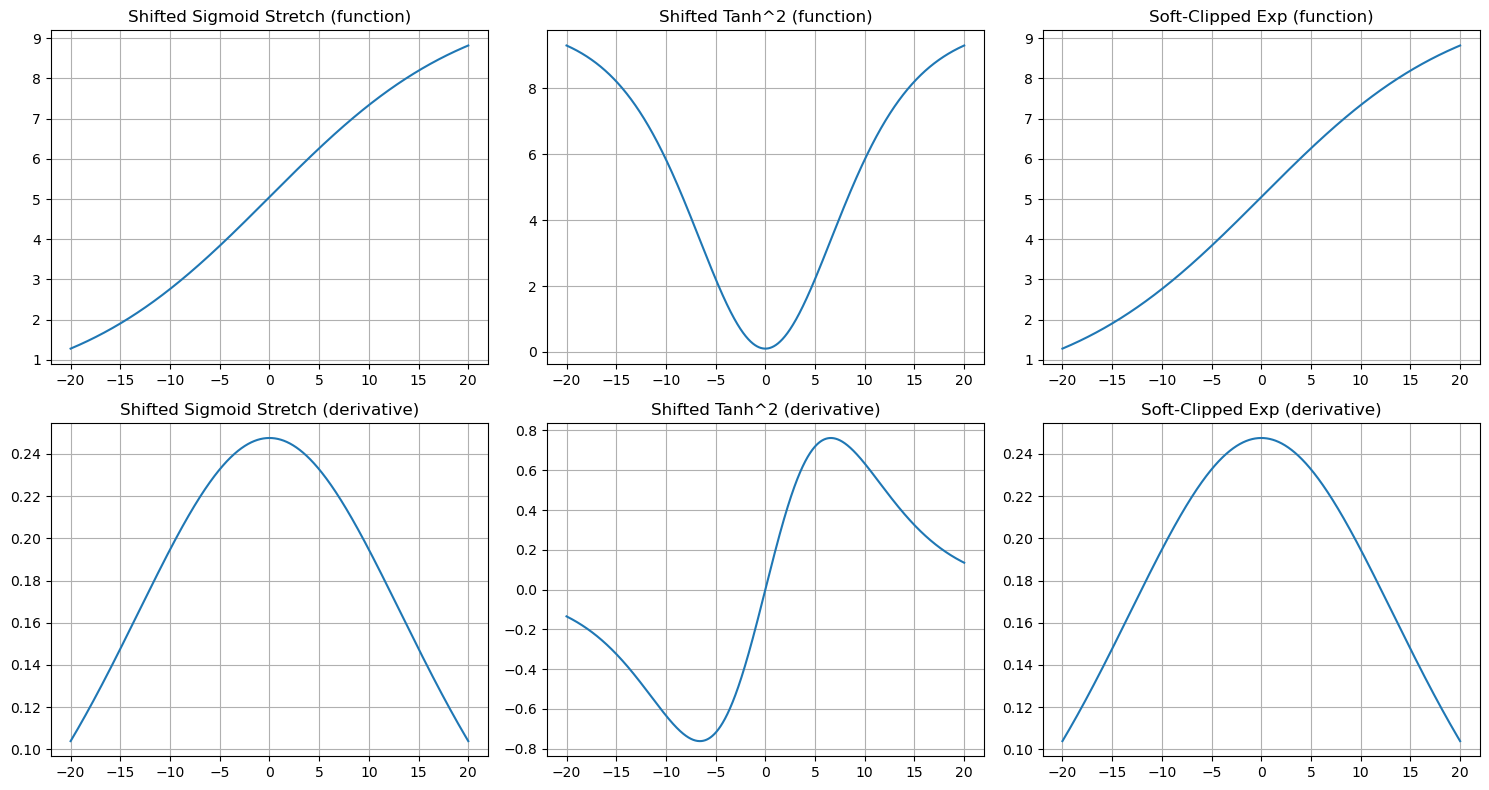

In [ ]:
import torch
import matplotlib.pyplot as plt

# Parameters
eps_min = 0.1
eps_max = 10.0
k = 0.1
theta = torch.linspace(-20, 20, 5000, requires_grad=True)

# Function 1: Shifted Sigmoid Stretch
def f1(theta):
    return eps_min + (eps_max - eps_min) * torch.sigmoid(k * theta)

# Function 2: Shifted Tanh^2
def f2(theta):
    return eps_min + (eps_max - eps_min) * torch.tanh(k * theta).pow(2)

# Function 3: Soft-Clipped Exponential (Softplus normalized variant)
def f3(theta):
    return eps_min + (eps_max - eps_min) * torch.sigmoid(k * theta)  # simplified soft-clipped exp

funcs = [f1, f2, f3]
names = ["Shifted Sigmoid Stretch", "Shifted Tanh^2", "Soft-Clipped Exp"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, (f, name) in enumerate(zip(funcs, names)):
    # Forward
    y = f(theta)
    axes[0, i].plot(theta.detach().numpy(), y.detach().numpy())
    axes[0, i].set_title(f"{name} (function)")
    axes[0, i].grid(True)

    # Gradient (derivative)
    dy = torch.autograd.grad(y.sum(), theta, create_graph=False)[0]
    axes[1, i].plot(theta.detach().numpy(), dy.detach().numpy())
    axes[1, i].set_title(f"{name} (derivative)")
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()




In [15]:

class Step_1(nn.Module):
    """
    A fully customizable layer that transforms position and velocity:
    X = a * x + c1
    U = (1/a) * u - γ * ∂G/∂x + c2
    where G(x,t) is a customizable MLP network and a, c1, γ, c2 are trainable parameters.
    
    Input: (x, u, t) 
    Output: (X, U, t) where X and U are transformed
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        
        # Architectural choices
        use_bias: bool = True,
        
        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        
        # Trainable parameter constraints
        a_eps_min: float = 0.1,  # Minimum value for a
        a_eps_max: float = 10.0,  # Maximum value for a  
        a_k: float = 0.1,  # Sigmoid steepness
    ):
        """
        Initialize the velocity transformation layer with trainable parameters.
        """
        super(Step_1, self).__init__()
        
        # Initialize trainable parameters
        self.a_raw = nn.Parameter(torch.tensor(0.0))  
        self.c1 = nn.Parameter(torch.tensor(0.0))
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.c2 = nn.Parameter(torch.tensor(0.0))
        
        self.a_eps_min = a_eps_min
        self.a_eps_max = a_eps_max
        self.a_k = a_k

        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.G_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,
        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    @property
    def a(self):
        """Compute a from a_raw using sigmoid to ensure bounded values."""
        return self.a_eps_min + (self.a_eps_max - self.a_eps_min) * torch.sigmoid(self.a_k * self.a_raw)
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            layers.append(linear)
            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.G_network.apply(init_weights)
    
    def compute_G_and_gradient(self, x, t):
        """
        Compute G(x,t) and its gradient with respect to x.
        
        Args:
            x: Position tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            dG_dx: The partial derivative ∂G/∂x
        """
        # Ensure x requires gradient for autograd to work
        x = x.requires_grad_(True)
        
        # Reshape inputs if needed
        if x.dim() == 1:
            x = x.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([x, t], dim=1)
        
        # Forward pass through the MLP
        G = self.G_network(mlp_input)
        
        # Compute the gradient ∂G/∂x
        dG_dx = torch.autograd.grad(
            outputs=G,
            inputs=x,
            grad_outputs=torch.ones_like(G),
            create_graph=self.training,
            retain_graph=self.training
        )[0]
        
        return dG_dx.squeeze(1)
    
    def forward(self, x, u, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Transformed position where X = a * x + c1
            U: Transformed velocity where U = (1/a) * u - γ * ∂G/∂x + c2
            t: Unchanged time
        """
        assert x.shape == u.shape == t.shape, "Input shapes must match"
        original_shape = x.shape
        x = x.view(-1)
        u = u.view(-1)
        t = t.view(-1)
        
        # Compute gradient of G with respect to INPUT x (not transformed X)
        dG_dx = self.compute_G_and_gradient(x, t)
        
        # Get current value of a (always positive)
        a_val = self.a
        
        # Transform position: X = a * x + c1
        X = a_val * x + self.c1
        
        # Transform velocity: U = (1/a) * u - γ * ∂G/∂x + c2
        U = (1.0 / a_val) * u - self.gamma * dG_dx + self.c2
        
        return X.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
            'a': self.a.item(),
            'c1': self.c1.item(),
            'gamma': self.gamma.item(),
            'c2': self.c2.item(),
        }




In [16]:
class Step_2(nn.Module):
    """
    A fully customizable layer that transforms position and velocity:
    U = a' * u + c1'
    X = (1/a') * x + γ' * ∂F/∂u + c2'
    where F(u,t) is a customizable MLP network and a', c1', γ', c2' are trainable parameters.
    
    Input: (x, u, t) 
    Output: (X, U, t) where X and U are transformed
    """
    
    def __init__(
        self,
        # MLP Architecture parameters
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: int = 2,
        
        # Activation parameters
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        
        # Initialization parameters
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        
        # Architectural choices
        use_bias: bool = True,
        
        # Input/Output parameters
        input_dim: int = 2,  # u and t
        output_dim: int = 1,  # scalar F
        
        # Trainable parameter constraints
        a_eps_min: float = 0.1,
        a_eps_max: float = 10.0,
        a_k: float = 0.1,
    ):
        super(Step_2, self).__init__()
        
        # Store hyperparameters for a
        self.a_eps_min = a_eps_min
        self.a_eps_max = a_eps_max
        self.a_k = a_k
        
        # Initialize trainable parameters
        self.a_raw = nn.Parameter(torch.tensor(0.0))
        self.c1 = nn.Parameter(torch.tensor(0.0))
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.c2 = nn.Parameter(torch.tensor(0.0))
        
        # Process hidden dimensions
        if isinstance(hidden_dims, int):
            self.hidden_dims = [hidden_dims] * n_hidden_layers
        else:
            self.hidden_dims = hidden_dims
            
        # Build the MLP
        self.F_network = self._build_mlp(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_dims=self.hidden_dims,
            activation=activation,
            activation_params=activation_params,
            final_activation=final_activation,
            use_bias=use_bias,
        )
        
        # Initialize weights
        self._initialize_weights(
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value
        )
    
    @property
    def a(self):
        """Compute a from a_raw using sigmoid to ensure bounded values."""
        return self.a_eps_min + (self.a_eps_max - self.a_eps_min) * torch.sigmoid(self.a_k * self.a_raw)
    
    def _get_activation(self, activation_name: str, params: Optional[dict] = None):
        """Get activation function by name."""
        params = params or {}
        
        activations = {
            'tanh': nn.Tanh,
            'sigmoid': nn.Sigmoid,
            'elu': lambda: nn.ELU(**params),
            'selu': nn.SELU,
            'gelu': nn.GELU,
            'softplus': lambda: nn.Softplus(**params),
            'swish': nn.SiLU,
            'mish': nn.Mish,
            'identity': nn.Identity,
            'none': nn.Identity,
        }
        
        if activation_name.lower() not in activations:
            raise ValueError(f"Unknown activation: {activation_name}")
        
        activation = activations[activation_name.lower()]
        return activation() if callable(activation) else activation(**params)
    
    def _build_mlp(
        self, input_dim, output_dim, hidden_dims, activation, activation_params,
        final_activation, use_bias
    ):
        """Build the MLP network with specified configuration."""
        layers = []
        
        # Determine layer dimensions
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        # Build each layer
        for i in range(len(all_dims) - 1):
            in_dim = all_dims[i]
            out_dim = all_dims[i + 1]
            is_last_layer = (i == len(all_dims) - 2)
            
            # Linear layer
            linear = nn.Linear(in_dim, out_dim, bias=use_bias)
            layers.append(linear)
            
            # Add activation
            if is_last_layer:
                if final_activation is not None:
                    layers.append(self._get_activation(final_activation, activation_params))
            else:
                layers.append(self._get_activation(activation, activation_params))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self, weight_init, weight_init_params, bias_init, bias_init_value):
        """Initialize weights and biases according to specifications."""
        weight_init_params = weight_init_params or {}
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                # Initialize weights
                if weight_init == 'xavier_uniform':
                    init.xavier_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'xavier_normal':
                    init.xavier_normal_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_uniform':
                    init.kaiming_uniform_(m.weight, **weight_init_params)
                elif weight_init == 'kaiming_normal':
                    init.kaiming_normal_(m.weight, **weight_init_params)
                elif weight_init == 'normal':
                    init.normal_(m.weight, **weight_init_params)
                elif weight_init == 'uniform':
                    init.uniform_(m.weight, **weight_init_params)
                elif weight_init == 'orthogonal':
                    init.orthogonal_(m.weight, **weight_init_params)
                
                # Initialize biases
                if m.bias is not None:
                    if bias_init == 'zeros':
                        init.zeros_(m.bias)
                    elif bias_init == 'ones':
                        init.ones_(m.bias)
                    elif bias_init == 'uniform':
                        init.uniform_(m.bias, -bias_init_value, bias_init_value)
                    elif bias_init == 'normal':
                        init.normal_(m.bias, std=bias_init_value)
                    elif bias_init == 'constant':
                        init.constant_(m.bias, bias_init_value)
        
        self.F_network.apply(init_weights)
    
    def compute_F_and_gradient(self, u, t):
        """
        Compute F(u,t) and its gradient with respect to u.
        
        Args:
            u: Velocity tensor of shape (batch_size,) or (batch_size, 1)
            t: Time tensor of shape (batch_size,) or (batch_size, 1)
            
        Returns:
            dF_du: The partial derivative ∂F/∂u
        """
        # Ensure u requires gradient for autograd to work
        u = u.requires_grad_(True)
        
        # Reshape inputs if needed
        if u.dim() == 1:
            u = u.unsqueeze(1)
        if t.dim() == 1:
            t = t.unsqueeze(1)
        
        # Stack inputs for the MLP
        mlp_input = torch.cat([u, t], dim=1)
        
        # Forward pass through the MLP
        F = self.F_network(mlp_input)
        
        # Compute the gradient dF_du
        dF_du = torch.autograd.grad(
            outputs=F,
            inputs=u,
            grad_outputs=torch.ones_like(F),
            create_graph=self.training,
            retain_graph=self.training
        )[0]
        
        return dF_du.squeeze(1)
    
    def forward(self, x, u, t):
        """
        Forward pass of the layer.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Transformed position where X = (1/a') * x + γ' * ∂F/∂u + c2'
            U: Transformed velocity where U = a' * u + c1'
            t: Unchanged time
        """
        assert x.shape == u.shape == t.shape, "Input shapes must match"
        original_shape = x.shape
        x = x.view(-1)
        u = u.view(-1)
        t = t.view(-1)
        
        # Compute gradient of F with respect to INPUT u (not transformed U)
        dF_du = self.compute_F_and_gradient(u, t)
        
        # Get current value of a (always positive and bounded)
        a_val = self.a
        
        # Transform velocity: U = a' * u + c1'
        U = a_val * u + self.c1
        
        # Transform position: X = (1/a') * x + γ' * ∂F/∂u + c2'
        X = (1.0 / a_val) * x + self.gamma * dF_du + self.c2
        
        return X.view(original_shape), U.view(original_shape), t.view(original_shape)
    
    def get_config(self):
        """Return the configuration of this layer as a dictionary."""
        return {
            'hidden_dims': self.hidden_dims,
            'a': self.a.item(),
            'c1': self.c1.item(),
            'gamma': self.gamma.item(),
            'c2': self.c2.item(),
        }

In [17]:
class CombinedHamiltonianLayer(nn.Module):
    """
    Combined layer that performs both transformations in sequence:
    Step 1: (x, u, t) → (x, U, t) where U = u - ∂G/∂x
    Step 2: (x, U, t) → (X, U, t) where X = x + ∂F/∂U
    
    Final: (x, u, t) → (X, U, t)
    """
    
    def __init__(
        self,
        # Step 1 parameters (G network: takes x,t → scalar)
        step1_hidden_dims: Union[int, List[int]] = 32,
        step1_n_hidden_layers: int = 2,
        step1_activation: str = 'tanh',
        step1_activation_params: Optional[dict] = None,
        step1_final_activation: Optional[str] = None,

        
        # Step 2 parameters (F network: takes U,t → scalar)
        step2_hidden_dims: Union[int, List[int]] = 32,
        step2_n_hidden_layers: int = 2,
        step2_activation: str = 'tanh',
        step2_activation_params: Optional[dict] = None,
        step2_final_activation: Optional[str] = None,

        
        # Shared initialization parameters (apply to both steps)
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        


        use_bias: bool = True,

        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        
        # Trainable parameter constraints
        a_eps_min: float = 0.1,  # Minimum value for a
        a_eps_max: float = 10.0,  # Maximum value for a  
        a_k: float = 0.1,  # Sigmoid steepness

    ):
        """
        Initialize the combined Hamiltonian layer.
        
        Args:
            step1_*: Parameters for Step_1 (velocity transformation)
            step2_*: Parameters for Step_2 (position transformation)
            Other parameters are applied to both steps
        """
        super(CombinedHamiltonianLayer, self).__init__()
        
        # Create Step 1: Velocity Transform Layer
        # Transforms     X = a * x + c1
        #                U = (1/a) * u - γ * ∂G/∂x + c2
        self.step_1 = Step_1(
            hidden_dims=step1_hidden_dims,
            n_hidden_layers=step1_n_hidden_layers,
            activation=step1_activation,
            activation_params=step1_activation_params,
            final_activation=step1_final_activation,
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value,
            use_bias=use_bias,
            input_dim= input_dim,  # x and t
            output_dim= output_dim,  # scalar G
            
            # Trainable parameter constraints
            a_eps_min= a_eps_min,  # Minimum value for a
            a_eps_max= a_eps_max,  # Maximum value for a  
            a_k= a_k,  # Sigmoid steepness

        )
        
        # Create Step 2: Position Transform Layer  
        # Transforms     U = a' * u + c1'
        #                X = (1/a') * x + γ' * ∂F/∂u + c2'
        self.step_2 = Step_2(
            hidden_dims=step2_hidden_dims,
            n_hidden_layers=step2_n_hidden_layers,
            activation=step2_activation,
            activation_params=step2_activation_params,
            final_activation=step2_final_activation,
            weight_init=weight_init,
            weight_init_params=weight_init_params,
            bias_init=bias_init,
            bias_init_value=bias_init_value,
            use_bias=use_bias,
            input_dim= input_dim,  # x and t
            output_dim= output_dim,  # scalar G
            
            # Trainable parameter constraints
            a_eps_min= a_eps_min,  # Minimum value for a
            a_eps_max= a_eps_max,  # Maximum value for a  
            a_k= a_k,  # Sigmoid steepness

        )
        
    def forward(self, x, u, t):
        """
        Forward pass through both transformation steps.
        
        Args:
            x: Position tensor of shape (batch_size,)
            u: Velocity tensor of shape (batch_size,)
            t: Time tensor of shape (batch_size,)
            
        Returns:
            X: Transformed position (after both steps)
            U: Transformed velocity (after step_1)
            t: Unchanged time
        """
        # Step 1:
        x_after_step1, u_after_step1, t_after_step_1 = self.step_1(x, u, t)
        
        # Step 2:
        X_final, U_final, t_final = self.step_2(x_after_step1, u_after_step1, t_after_step_1)
        
        return X_final, U_final, t_final
    



    


In [18]:
class SimpleStackedHamiltonianNetwork(nn.Module):
    """
    Builds a network consisting of Hamiltonian layers where all layers have the same configuration.
    """
    
    def __init__(
        self,
        n_layers: int = 3,
        hidden_dims: Union[int, List[int]] = 32,
        n_hidden_layers: Optional[int] = 2,
        activation: str = 'tanh',
        activation_params: Optional[dict] = None,
        final_activation: Optional[str] = None,
        weight_init: str = 'xavier_uniform',
        weight_init_params: Optional[dict] = None,
        bias_init: str = 'zeros',
        bias_init_value: float = 0.0,
        use_bias: bool = True,


        # Input/Output parameters
        input_dim: int = 2,  # x and t
        output_dim: int = 1,  # scalar G
        
        # Trainable parameter constraints
        a_eps_min: float = 0.1,  # Minimum value for a
        a_eps_max: float = 10.0,  # Maximum value for a  
        a_k: float = 0.1,  # Sigmoid steepness
        **kwargs  # Catch any extra parameters
    ):
        """
        Create a stack of identical CombinedHamiltonianLayers.
        
        Args:
            n_layers: Number of layers to stack
            hidden_dims: Hidden dimensions for MLPs (int or list of ints)
            n_hidden_layers: Number of hidden layers in MLPs (ignored if hidden_dims is a list)
            activation: Activation function for all MLPs
            activation_params: Parameters for activation function
            final_activation: Final activation for MLPs
            Other parameters are passed to both Step_1 and Step_2
        """
        super(SimpleStackedHamiltonianNetwork, self).__init__()
        
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        

        
        for i in range(n_layers):
            layer = CombinedHamiltonianLayer(
                # Step 1 parameters
                step1_hidden_dims=hidden_dims,
                step1_n_hidden_layers=n_hidden_layers,
                step1_activation=activation,
                step1_activation_params=activation_params,
                step1_final_activation=final_activation,
                # Step 2 parameters (same as step 1 for simplicity)
                step2_hidden_dims=hidden_dims,
                step2_n_hidden_layers=n_hidden_layers,
                step2_activation=activation,
                step2_activation_params=activation_params,
                step2_final_activation=final_activation,
                # Shared parameters
                weight_init=weight_init,
                weight_init_params=weight_init_params,
                bias_init=bias_init,
                bias_init_value=bias_init_value,
                use_bias=use_bias,
                input_dim= input_dim,  # x and t
                output_dim= output_dim,  # scalar G
                
                # Trainable parameter constraints
                a_eps_min= a_eps_min,  # Minimum value for a
                a_eps_max= a_eps_max,  # Maximum value for a  
                a_k= a_k,  # Sigmoid steepness
                **kwargs  # Pass any remaining kwargs
            )
            self.layers.append(layer)
    
    def forward(self, x, u, t):
        """Forward pass through all layers."""
        X, U, T = x, u, t
        for layer in self.layers:
            X, U, T = layer(X, U, T)
        return X, U, T


In [19]:
simple_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
        n_layers=100,
        # MLP Architecture parameters
        hidden_dims= [10,40,10],
        n_hidden_layers = None,
        
        # Activation parameters
        activation = 'tanh',
        activation_params = None,
        final_activation = None,
        
        # Initialization parameters
        weight_init = 'xavier_uniform',
        weight_init_params = None,
        bias_init = 'zeros',
        bias_init_value = 0.0,
        
        
        # Architectural choices
        use_bias = True,
        
        # Input/Output parameters
        input_dim = 2,  # x and t
        output_dim = 1,  # scalar G
        a_eps_min= 0.1,  # Minimum value for a
        a_eps_max= 10,  # Maximum value for a  
        a_k= 0.1
)



In [20]:
X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])

/home/thomasdev/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [26]:
class IntraTrajectoryVarianceLossEfficient_old(nn.Module):
    """
    Mean Variance loss 
    """
    
    def __init__(
        self,


    ):
        super(IntraTrajectoryVarianceLossEfficient_old, self).__init__()

            
    def forward(
        self, 
        X_final: torch.Tensor, 
        U_final: torch.Tensor, 
        trajectory_ids: torch.Tensor
    ) -> torch.Tensor:
        """
        Efficient computation using scatter operations.
        """
        # Get unique trajectories and their counts
        unique_ids, inverse_indices = torch.unique(trajectory_ids, return_inverse=True)
        n_trajectories = len(unique_ids)
        
        # Count samples per trajectory
        counts = torch.zeros(n_trajectories, device=trajectory_ids.device)
        counts = counts.scatter_add(0, inverse_indices, torch.ones_like(inverse_indices, dtype=torch.float))
        
        # Compute means per trajectory using scatter
        X_sums = torch.zeros(n_trajectories, device=X_final.device)
        U_sums = torch.zeros(n_trajectories, device=U_final.device)
        X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
        U_sums = U_sums.scatter_add(0, inverse_indices, U_final)
        
        X_means = X_sums / counts
        U_means = U_sums / counts
        
        # Compute squared differences from means
        X_centered = X_final - X_means[inverse_indices]
        U_centered = U_final - U_means[inverse_indices]
        
        # Sum squared differences per trajectory
        X_sq_sums = torch.zeros(n_trajectories, device=X_final.device)
        U_sq_sums = torch.zeros(n_trajectories, device=U_final.device)
        X_sq_sums = X_sq_sums.scatter_add(0, inverse_indices, X_centered ** 2)
        U_sq_sums = U_sq_sums.scatter_add(0, inverse_indices, U_centered ** 2)
        
        # Compute variances (unbiased estimator)
        # Only compute variance for trajectories with > 1 sample
        valid_mask = counts > 1
        X_variances = torch.zeros_like(X_sq_sums)
        U_variances = torch.zeros_like(U_sq_sums)
        
        X_variances[valid_mask] = X_sq_sums[valid_mask] / (counts[valid_mask] - 1)
        U_variances[valid_mask] = U_sq_sums[valid_mask] / (counts[valid_mask] - 1)
        
        # Weighted sum of variances
        total_variance = X_variances.sum() + U_variances.sum()
        

        total_mean_variance = total_variance / max(n_trajectories, 1)
        
        return total_mean_variance

In [27]:
class IntraTrajectoryVarianceLossEfficient(nn.Module):
    """
    Mean Variance loss with guaranteed gradient flow - exact functionality preserved
    """
    
    def __init__(self):
        super(IntraTrajectoryVarianceLossEfficient, self).__init__()
            
    def forward(
        self, 
        X_final: torch.Tensor, 
        U_final: torch.Tensor, 
        trajectory_ids: torch.Tensor
    ) -> torch.Tensor:
        """
        Efficient computation using scatter operations with smooth gradient flow.
        """
        # Get unique trajectories and their counts
        unique_ids, inverse_indices = torch.unique(trajectory_ids, return_inverse=True)
        n_trajectories = len(unique_ids)
        
        # Count samples per trajectory
        counts = torch.zeros(n_trajectories, device=trajectory_ids.device)
        counts = counts.scatter_add(0, inverse_indices, 
                                   torch.ones_like(inverse_indices, dtype=torch.float))
        
        # Compute means per trajectory using scatter
        X_sums = torch.zeros(n_trajectories, device=X_final.device, dtype=X_final.dtype)
        U_sums = torch.zeros(n_trajectories, device=U_final.device, dtype=U_final.dtype)
        X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
        U_sums = U_sums.scatter_add(0, inverse_indices, U_final)
        
        X_means = X_sums / counts
        U_means = U_sums / counts
        
        # Compute squared differences from means
        X_centered = X_final - X_means[inverse_indices]
        U_centered = U_final - U_means[inverse_indices]
        
        # Sum squared differences per trajectory
        X_sq_sums = torch.zeros(n_trajectories, device=X_final.device, dtype=X_final.dtype)
        U_sq_sums = torch.zeros(n_trajectories, device=U_final.device, dtype=U_final.dtype)
        X_sq_sums = X_sq_sums.scatter_add(0, inverse_indices, X_centered ** 2)
        U_sq_sums = U_sq_sums.scatter_add(0, inverse_indices, U_centered ** 2)
        
        # Compute variances - GRADIENT SAFE VERSION
        # Create mask as float (this allows gradient to flow, just with zero values)
        valid_mask_float = (counts > 1).float()
        
        # Use torch.maximum to prevent division by zero/negative
        # This is differentiable and safe
        safe_denominator = torch.maximum(
            counts - 1, 
            torch.ones_like(counts)  # Minimum value of 1
        )
        
        # Compute variances for all trajectories
        X_variances_all = X_sq_sums / safe_denominator
        U_variances_all = U_sq_sums / safe_denominator
        
        # Apply mask through multiplication (preserves gradient flow)
        # For count <= 1: mask = 0, so variance = 0
        # For count > 1: mask = 1, so variance = computed value
        X_variances = X_variances_all * valid_mask_float
        U_variances = U_variances_all * valid_mask_float
        
        # Weighted sum of variances
        total_variance = X_variances.sum() + U_variances.sum()
        
        # Mean variance
        total_mean_variance = total_variance / max(n_trajectories, 1)
        
        return total_mean_variance

In [28]:
variance_class_old = IntraTrajectoryVarianceLossEfficient_old()
variance_class = IntraTrajectoryVarianceLossEfficient()





In [29]:
var_loss_old = variance_class_old(X_final, U_final, batch['trajectory_ids'])
var_loss = variance_class(X_final, U_final, batch['trajectory_ids'])

In [38]:
var_loss_old

tensor(63.4314, grad_fn=<DivBackward0>)

In [39]:
var_loss

tensor(63.4314, grad_fn=<DivBackward0>)

In [ ]:
unique_ids, inverse_indices = torch.unique(batch['trajectory_ids'], return_inverse=True)
n_trajectories = len(unique_ids)

# Count samples per trajectory
counts = torch.zeros(n_trajectories, device=batch['trajectory_ids'].device)
counts = counts.scatter_add(0, inverse_indices, torch.ones_like(inverse_indices, dtype=torch.float))

# Compute means per trajectory using scatter
X_sums = torch.zeros(n_trajectories, device=X_final.device)
U_sums = torch.zeros(n_trajectories, device=U_final.device)
X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
U_sums = U_sums.scatter_add(0, inverse_indices, U_final)

X_means = X_sums / counts
U_means = U_sums / counts

# Compute squared differences from means
X_centered = X_final - X_means[inverse_indices]
U_centered = U_final - U_means[inverse_indices]

# Sum squared differences per trajectory
X_sq_sums = torch.zeros(n_trajectories, device=X_final.device)
U_sq_sums = torch.zeros(n_trajectories, device=U_final.device)
X_sq_sums = X_sq_sums.scatter_add(0, inverse_indices, X_centered ** 2)
U_sq_sums = U_sq_sums.scatter_add(0, inverse_indices, U_centered ** 2)

# Compute variances (unbiased estimator)
# Only compute variance for trajectories with > 1 sample
valid_mask = counts > 1
X_variances = torch.zeros_like(X_sq_sums)
U_variances = torch.zeros_like(U_sq_sums)

X_variances[valid_mask] = X_sq_sums[valid_mask] / (counts[valid_mask] - 1)
U_variances[valid_mask] = U_sq_sums[valid_mask] / (counts[valid_mask] - 1)

In [67]:
unique_ids

tensor([ 19,  23,  40,  48,  68,  69,  73,  79,  91, 110, 118])

In [62]:
X_means

tensor([  4.3035,   2.9503,   7.9567,   7.4442,  -5.4043,  -0.7593,   2.6386,
         10.3320,   1.8834,   3.9223, -13.9221], grad_fn=<DivBackward0>)

In [65]:
X_stds = torch.sqrt(X_variances)
X_stds

tensor([ 1.5879,  3.3670,  1.4010,  2.9275,  6.1344,  9.1480,  9.2122,  2.0038,
         8.0859, 10.3835,  1.6312], grad_fn=<SqrtBackward0>)

In [81]:
U_means

tensor([-0.5994, -6.7394, -7.2463, -7.8196,  6.8773,  4.4124, -6.2435,  4.1309,
        -0.5306, -9.3555,  3.8101], grad_fn=<DivBackward0>)

In [75]:
U_stds = torch.sqrt(U_variances)
U_stds

tensor([ 1.3243,  3.3325,  3.8435,  4.6775,  5.1647,  4.0690,  3.6657,  2.7167,
        12.0432,  5.8564,  5.7503], grad_fn=<SqrtBackward0>)

In [80]:
(X_means/X_stds).detach().numpy()

array([ 2.7102416 ,  0.87624586,  5.67919   ,  2.5428712 , -0.8809822 ,
       -0.08300165,  0.28642324,  5.1560802 ,  0.2329248 ,  0.3777464 ,
       -8.534773  ], dtype=float32)

In [77]:
np.abs((X_means/X_stds).detach().numpy()).mean()

np.float32(2.4873164)

In [78]:
np.abs((U_means/U_stds).detach().numpy()).mean()

np.float32(1.2705392)

In [79]:
(np.abs((X_means/X_stds).detach().numpy()).mean()+np.abs((U_means/U_stds).detach().numpy()).mean())/2

np.float32(1.8789277)

In [90]:
class AdaptiveSoftRepulsionLoss_old(nn.Module):
    """
    Adaptive Soft Repulsion Loss for trajectory separation in (X, U) space.
    
    This loss encourages different trajectories to maintain separation in the 
    output space, with adaptive temperature scaling based on trajectory magnitudes.
    
    Key Properties:
    - Gradients flow through X_final and U_final
    - Temperature term Tij is DETACHED (no gradient flow)
    - Numerically stable with epsilon protections
    
    Args:
        epsilon: Minimum temperature value (default: 1e-3)
        k: Scaling factor for adaptive temperature (default: 1.0)
    """
    
    def __init__(self, epsilon=1e-3, k=1.0):
        super().__init__()
        self.epsilon = epsilon
        self.k = k
        # Small constant for numerical stability
        self.numerical_eps = 1e-8
    
    def forward(self, X_final, U_final, trajectory_ids):
        """
        Compute the adaptive soft repulsion loss.
        
        Args:
            X_final: Tensor of shape (batch_size,) - network output 1
            U_final: Tensor of shape (batch_size,) - network output 2
            trajectory_ids: Tensor of shape (batch_size,) - trajectory IDs (integers)
        
        Returns:
            Scalar loss tensor with gradient information preserved
        """
        device = X_final.device
        
        # Get unique trajectory IDs
        unique_ids = torch.unique(trajectory_ids)
        N = len(unique_ids)
        
        # Edge case: only one trajectory, no repulsion needed
        if N <= 1:
            # Return zero loss that maintains computational graph
            return torch.tensor(0.0, device=device, dtype=X_final.dtype, 
                              requires_grad=True) * X_final.mean() * 0.0
        
        # ============================================================
        # Step 1: Compute mean X and U for each trajectory
        # GRADIENTS FLOW through these means back to X_final and U_final
        # ============================================================
        X_means = []
        U_means = []
        
        for traj_id in unique_ids:
            mask = (trajectory_ids == traj_id)
            # These means preserve gradients
            X_mean = X_final[mask].mean()
            U_mean = U_final[mask].mean()
            X_means.append(X_mean)
            U_means.append(U_mean)
        
        # Stack into tensors: shape (N,)
        X_means = torch.stack(X_means)  # Gradients maintained
        U_means = torch.stack(U_means)  # Gradients maintained
        
        # ============================================================
        # Step 2: Compute pairwise Euclidean distances dij
        # GRADIENTS FLOW through these distances
        # ============================================================
        # Broadcast to compute all pairwise differences
        X_diff = X_means.unsqueeze(1) - X_means.unsqueeze(0)  # Shape: (N, N)
        U_diff = U_means.unsqueeze(1) - U_means.unsqueeze(0)  # Shape: (N, N)
        
        # Euclidean distance with numerical stability
        dij = torch.sqrt(X_diff**2 + U_diff**2 + self.numerical_eps)
        # dij has shape (N, N) and PRESERVES GRADIENTS
        
        # ============================================================
        # Step 3: Compute temperature term Tij (DETACHED!)
        # NO GRADIENTS flow through this term
        # ============================================================
        # Compute ||Ci|| = sqrt(X_mean_i^2 + U_mean_i^2)
        # DETACH immediately to cut gradient flow
        C_norms = torch.sqrt(X_means**2 + U_means**2 + self.numerical_eps).detach()
        
        # Compute pairwise sum: (||Ci|| + ||Cj||) / 2
        C_sum = (C_norms.unsqueeze(1) + C_norms.unsqueeze(0)) / 2  # Shape: (N, N)
        
        # Tij = max(epsilon, k * (||Ci|| + ||Cj||) / 2)
        # torch.maximum is gradient-safe (differentiable) but we detach anyway
        epsilon_tensor = torch.tensor(self.epsilon, device=device, dtype=X_final.dtype)
        Tij = torch.maximum(epsilon_tensor, self.k * C_sum)
        
        # CRITICAL: Detach Tij to ensure NO gradients flow through it
        Tij = Tij.detach()
        
        # ============================================================
        # Step 4: Compute exponential repulsion terms
        # GRADIENTS FLOW through dij in the numerator
        # ============================================================
        # exp(-dij/Tij)
        # Add small epsilon to denominator for extra numerical safety
        exp_terms = torch.exp(-dij / (Tij + self.numerical_eps))
        
        # ============================================================
        # Step 5: Sum over all i≠j pairs
        # ============================================================
        # Create boolean mask for i≠j (exclude diagonal)
        mask_off_diagonal = ~torch.eye(N, dtype=torch.bool, device=device)
        
        # Sum only off-diagonal terms
        loss_sum = exp_terms[mask_off_diagonal].sum()
        
        # ============================================================
        # Step 6: Normalize by Z = N * (N - 1)
        # ============================================================
        Z = N * (N - 1)
        loss = loss_sum / Z
        
        return loss


In [21]:
class AdaptiveSoftRepulsionLoss(nn.Module):
    """
    Adaptive soft repulsion loss (vectorized, gradient-safe).
    
    Args:
        epsilon: Minimum temperature value (default: 1e-3)
        k: Scaling factor for adaptive temperature (default: 1.0)
    """
    def __init__(self, epsilon=1e-3, k=1.0):
        super().__init__()
        self.epsilon = epsilon
        self.k = k
        self.numerical_eps = 1e-8

    def forward(self, X_final, U_final, trajectory_ids):
        """
        X_final: shape (batch,)
        U_final: shape (batch,)
        trajectory_ids: shape (batch,) ints
        """
        device = X_final.device
        dtype = X_final.dtype

        # Unique trajectory ids and map each sample to its group index
        unique_ids, inverse = torch.unique(trajectory_ids, return_inverse=True)
        N = unique_ids.shape[0]

        if N <= 1:
            # zero scalar that preserves graph and device/dtype
            return X_final.sum() * 0.0

        # compute group sums via scatter_add on new tensors (single kernel)
        sums_x = torch.zeros(N, device=device, dtype=dtype).scatter_add_(0, inverse, X_final)
        sums_u = torch.zeros(N, device=device, dtype=dtype).scatter_add_(0, inverse, U_final)
        counts = torch.bincount(inverse, minlength=N).to(dtype=dtype, device=device)

        X_means = sums_x / counts
        U_means = sums_u / counts

        # compute pair indices for i < j (condensed)
        idx = torch.triu_indices(N, N, offset=1, device=device)  # shape (2, M)
        i, j = idx[0], idx[1]

        dx = X_means[i] - X_means[j]
        du = U_means[i] - U_means[j]
        dij = torch.sqrt(dx * dx + du * du + self.numerical_eps)  # shape (M,)

        # compute detached temperature per center norm, then pairwise average
        c_norms = torch.sqrt(X_means * X_means + U_means * U_means + self.numerical_eps).detach()
        C_sum_pairs = 0.5 * (c_norms[i] + c_norms[j])
        eps_t = X_final.new_tensor(self.epsilon)
        Tij_pairs = torch.maximum(eps_t, self.k * C_sum_pairs).detach()

        # exponential terms for i<j
        exp_vals = torch.exp(-dij / (Tij_pairs + self.numerical_eps))

        # original code averaged over ordered pairs (i != j). To preserve that exactly
        # we double the sum over i<j (counts each unordered pair twice).
        sum_ordered = 2.0 * exp_vals.sum()  # equals sum over i!=j entries
        Z = float(N * (N - 1))
        loss = sum_ordered / Z

        return loss

In [58]:
device = X_final.device
dtype = X_final.dtype

        # Unique trajectory ids and map each sample to its group index
unique_ids, inverse = torch.unique(batch['trajectory_ids'], return_inverse=True)
N = unique_ids.shape[0]



        # compute group sums via scatter_add on new tensors (single kernel)
sums_x = torch.zeros(N, device=device, dtype=dtype).scatter_add_(0, inverse, X_final)
sums_u = torch.zeros(N, device=device, dtype=dtype).scatter_add_(0, inverse, U_final)
counts = torch.bincount(inverse, minlength=N).to(dtype=dtype, device=device)

In [63]:
batch['trajectory_ids'][:22]

tensor([110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
        110, 110, 110, 110, 110, 110, 110, 110])

In [66]:
X_final[:22].sum()

tensor(82.0088, grad_fn=<SumBackward0>)

In [68]:
unique_ids

tensor([ 19,  23,  40,  48,  68,  69,  73,  79,  91, 110, 118])

In [59]:
sums_x

tensor([  65.6325,   59.1688,  158.6450,  152.2339, -130.7368,  -62.5302,
          46.0618,  221.5117,  -12.5267,   82.0088, -314.5841],
       grad_fn=<ScatterAddBackward0>)

In [69]:
counts

tensor([22., 22., 22., 22., 22., 22., 22., 22., 22., 22., 22.])

In [70]:
X_means = sums_x / counts

In [72]:
U_means = sums_u / counts

In [73]:
idx = torch.triu_indices(N, N, offset=1, device=device)  # shape (2, M)
i, j = idx[0], idx[1]
dx = X_means[i] - X_means[j]
du = U_means[i] - U_means[j]

In [78]:
idx

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,
          9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  2,  3,  4,  5,  6,  7,  8,  9,
         10,  3,  4,  5,  6,  7,  8,  9, 10,  4,  5,  6,  7,  8,  9, 10,  5,  6,
          7,  8,  9, 10,  6,  7,  8,  9, 10,  7,  8,  9, 10,  8,  9, 10,  9, 10,
         10]])

In [83]:
X_means[0]-X_means

tensor([ 0.0000,  0.2938, -4.2278, -3.9364,  8.9259,  5.8256,  0.8896, -7.0854,
         3.5527, -0.7444, 17.2826], grad_fn=<SubBackward0>)

In [84]:
X_means[1]-X_means

tensor([-0.2938,  0.0000, -4.5216, -4.2302,  8.6321,  5.5318,  0.5958, -7.3792,
         3.2589, -1.0382, 16.9888], grad_fn=<SubBackward0>)

In [79]:
dx

tensor([  0.2938,  -4.2278,  -3.9364,   8.9259,   5.8256,   0.8896,  -7.0854,
          3.5527,  -0.7444,  17.2826,  -4.5216,  -4.2302,   8.6321,   5.5318,
          0.5958,  -7.3792,   3.2589,  -1.0382,  16.9888,   0.2914,  13.1537,
         10.0534,   5.1174,  -2.8576,   7.7805,   3.4835,  21.5104,  12.8623,
          9.7620,   4.8260,  -3.1490,   7.4891,   3.1920,  21.2190,  -3.1003,
         -8.0363, -16.0113,  -5.3732,  -9.6703,   8.3567,  -4.9360, -12.9110,
         -2.2729,  -6.5700,  11.4570,  -7.9750,   2.6631,  -1.6340,  16.3930,
         10.6381,   6.3410,  24.3680,  -4.2971,  13.7299,  18.0270],
       grad_fn=<SubBackward0>)

In [85]:
c_norms = torch.sqrt(X_means * X_means + U_means * U_means )

In [86]:
c_norms

tensor([ 9.6685,  4.1493,  7.2554,  8.4738,  8.3007, 10.4478,  7.3144, 12.1593,
         3.3851,  8.8532, 15.0325], grad_fn=<SqrtBackward0>)

In [87]:
C_sum_pairs = 0.5 * (c_norms[i] + c_norms[j])

In [88]:
C_sum_pairs

tensor([ 6.9089,  8.4619,  9.0711,  8.9846, 10.0581,  8.4914, 10.9139,  6.5268,
         9.2608, 12.3505,  5.7024,  6.3116,  6.2250,  7.2986,  5.7319,  8.1543,
         3.7672,  6.5013,  9.5909,  7.8646,  7.7780,  8.8516,  7.2849,  9.7074,
         5.3202,  8.0543, 11.1439,  8.3872,  9.4608,  7.8941, 10.3166,  5.9294,
         8.6635, 11.7531,  9.3742,  7.8075, 10.2300,  5.8429,  8.5769, 11.6666,
         8.8811, 11.3036,  6.9165,  9.6505, 12.7402,  9.7369,  5.3498,  8.0838,
        11.1735,  7.7722, 10.5063, 13.5959,  6.1191,  9.2088, 11.9428],
       grad_fn=<MulBackward0>)

In [91]:
Repulsive_loss_old = AdaptiveSoftRepulsionLoss_old(epsilon=0.001, k=0.5)

In [92]:
Repulsive_loss = AdaptiveSoftRepulsionLoss(epsilon=0.001, k=0.5)

In [31]:
save_dir = "./save_directory"
loss_scales_save_path = os.path.join(save_dir, "loss_scales.pkl")
with open(loss_scales_save_path, "rb") as f:
    loss_scales = pickle.load(f)

saved_mapping_loss_scale = loss_scales['saved_mapping_loss_scale']
saved_prediction_loss_scale = loss_scales['saved_prediction_loss_scale']

In [32]:
var_loss/saved_mapping_loss_scale

tensor(0.2882, grad_fn=<DivBackward0>)

In [23]:
Repulsive_loss(X_final=X_final, U_final=U_final, trajectory_ids=batch['trajectory_ids'])

tensor(0.1064, grad_fn=<DivBackward0>)

In [93]:
Repulsive_loss_old(X_final=X_final, U_final=U_final, trajectory_ids=batch['trajectory_ids'])

tensor(0.1064, grad_fn=<DivBackward0>)

In [50]:
class ReverseStep2_old(nn.Module):
    """
    Reverse transformation of Step_2.
    
    Forward Step_2 does: X = x + ∂F/∂U
    Reverse Step_2 does: X = X_final - ∂F/∂U_final
    
    This module SHARES the F network with the forward Step_2.
    """
    
    def __init__(self, forward_step2_module: nn.Module):
        super(ReverseStep2, self).__init__()
        self.forward_module = forward_step2_module
    
    def forward(self, X_final, U_final, t):
        # Use forward module's method to get gradient
        dF_dU = self.forward_module.compute_F_and_gradient(U_final, t)
        
        # REVERSE transformation: subtract instead of add
        X = X_final - dF_dU
        
        return X, U_final, t

In [51]:
class ReverseStep1_old(nn.Module):
    """
    Reverse transformation of Step_1.
    
    Forward Step_1 does: U = u - ∂G/∂x
    Reverse Step_1 does: u = U + ∂G/∂X
    
    This module SHARES the G network with the forward Step_1.
    """
    
    def __init__(self, forward_step1_module: nn.Module):
        super(ReverseStep1_old, self).__init__()
        self.forward_module = forward_step1_module
    
    def forward(self, X, U, t):
        # Use forward module's method to get gradient
        dG_dX = self.forward_module.compute_G_and_gradient(X, t)
        
        # REVERSE transformation: add instead of subtract
        u = U + dG_dX
        
        return X, u, t

In [33]:
class ReverseStep2(nn.Module):
    """
    Reverse transformation of Step_2.
    
    Forward Step_2 does: 
        U = a' * u + c1'
        X = (1/a') * x + γ' * ∂F/∂u + c2'
    
    Reverse Step_2 does: 
        u = (U - c1') / a'
        x = a' * (X - γ' * ∂F/∂u - c2')
    
    This module SHARES the F network and parameters with the forward Step_2.
    """
    
    def __init__(self, forward_step2_module: nn.Module):
        super(ReverseStep2, self).__init__()
        self.forward_module = forward_step2_module
    
    def forward(self, X, U, t):
        # Get shared parameters from forward module
        a = self.forward_module.a
        c1 = self.forward_module.c1
        gamma = self.forward_module.gamma
        c2 = self.forward_module.c2
        
        # FIRST: Reverse velocity transformation to get original u
        u = (U - c1) / a
        
        # SECOND: Use the recovered u to compute gradient
        dF_du = self.forward_module.compute_F_and_gradient(u, t)
        
        # THIRD: Reverse position transformation
        x = a * (X - gamma * dF_du - c2)
        
        # Return reconstructed values
        return x, u, t

In [34]:
class ReverseStep1(nn.Module):
    """
    Reverse transformation of Step_1.
    
    Forward Step_1 does: 
        X = a * x + c1
        U = (1/a) * u - γ * ∂G/∂x + c2
    
    Reverse Step_1 does: 
        x = (X - c1) / a
        u = a * (U + γ * ∂G/∂x - c2)
    
    This module SHARES the G network and parameters with the forward Step_1.
    """
    
    def __init__(self, forward_step1_module: nn.Module):
        super(ReverseStep1, self).__init__()
        self.forward_module = forward_step1_module
    
    def forward(self, X, U, t):
        # Get shared parameters from forward module
        a = self.forward_module.a
        c1 = self.forward_module.c1
        gamma = self.forward_module.gamma
        c2 = self.forward_module.c2
        
        # FIRST: Reverse position transformation to get original x
        x = (X - c1) / a
        
        # SECOND: Use the recovered x to compute gradient
        dG_dx = self.forward_module.compute_G_and_gradient(x, t)
        
        # THIRD: Reverse velocity transformation
        u = a * (U + gamma * dG_dx - c2)
        
        # Return reconstructed values
        return x, u, t

In [35]:
class ReverseCombinedHamiltonianLayer(nn.Module):
    """
    Combined reverse layer that performs both reverse transformations.
    Shares weights with the corresponding forward CombinedHamiltonianLayer.
    
    Order is REVERSED from forward:
    - Forward: Step_1 (velocity) → Step_2 (position)
    - Reverse: Reverse_Step_2 (position) → Reverse_Step_1 (velocity)
    """
    
    def __init__(
        self,
        forward_combined_layer: nn.Module,  # The forward CombinedHamiltonianLayer
    ):
        """
        Initialize the reverse combined layer.
        
        Args:
            forward_combined_layer: The forward CombinedHamiltonianLayer to reverse
        """
        super(ReverseCombinedHamiltonianLayer, self).__init__()
        
        
        # Create reverse steps that share weights with forward steps
        # Note: Order is reversed!
        self.reverse_step2 = ReverseStep2(
            forward_combined_layer.step_2,  # Share with forward Step_2
        )
        
        self.reverse_step1 = ReverseStep1(
            forward_combined_layer.step_1,  # Share with forward Step_1
        )
    
    def forward(self, X_final, U_final, t_final):
        """
        Apply both reverse transformations in reverse order.
        
        Args:
            X_final: Final position from forward network
            U_final: Final velocity from forward network
            t: Time (unchanged throughout)
            
        Returns:
            x_reconstructed: Should approximate original x
            u_reconstructed: Should approximate original u
            t_reconstructed: Should approximate original t
        """
        # First: Reverse Step_2 (position reconstruction)
        X_intermediate, U_intermediate, T_intermediate = self.reverse_step2(X_final, U_final, t_final)
        
        # Second: Reverse Step_1 (velocity reconstruction)
        x_reconstructed, u_reconstructed, t__reconstructed = self.reverse_step1(X_intermediate, U_intermediate, T_intermediate)
        
        return x_reconstructed, u_reconstructed, t__reconstructed

In [36]:
class InverseStackedHamiltonianNetwork(nn.Module):
    """
    Inverse network that reverses a SimpleStackedHamiltonianNetwork.
    Each layer shares weights with its corresponding forward layer.
    Layers are applied in REVERSE order.
    """
    
    def __init__(
        self,
        forward_network: nn.Module,  # SimpleStackedHamiltonianNetwork instance

    ):
        """
        Create inverse network from forward network.
        
        Args:
            forward_network: An initialized SimpleStackedHamiltonianNetwork
        """
        super(InverseStackedHamiltonianNetwork, self).__init__()
        

        self.n_layers = forward_network.n_layers
        
        # Create reverse layers that share weights with forward layers
        # IMPORTANT: We store them in REVERSE order for the inverse pass
        self.reverse_layers = nn.ModuleList()
        
        # Iterate through forward layers in REVERSE order
        for i in reversed(range(self.n_layers)):
            forward_layer = forward_network.layers[i]
            reverse_layer = ReverseCombinedHamiltonianLayer(
                forward_layer, 
            )
            self.reverse_layers.append(reverse_layer)
        
        print(f"Created inverse network with {len(self.reverse_layers)} reverse layers")

    
    def forward(self, X_final, U_final, T_final):
        """
        Apply inverse transformation through all layers.
        
        Args:
            X_final: Final position from forward network
            U_final: Final velocity from forward network
            t: Time (unchanged)
            
        Returns:
            x_reconstructed: Should approximate original x
            u_reconstructed: Should approximate original u
            t: Unchanged time
        """
        X, U, T = X_final, U_final, T_final
        
        # Apply reverse layers (already in reverse order)
        for i, reverse_layer in enumerate(self.reverse_layers):
            X, U, T = reverse_layer(X, U, T)
        
        return X, U, T
    

        

In [22]:
def create_inverse_network(
    forward_network: nn.Module,
    verify_weight_sharing: bool = False
) -> InverseStackedHamiltonianNetwork:
    """
    Create an inverse network from a forward SimpleStackedHamiltonianNetwork.
    
    Args:
        forward_network: An initialized SimpleStackedHamiltonianNetwork
        verify_weight_sharing: If True, verify that weights are properly shared
        
    Returns:
        InverseStackedHamiltonianNetwork: The inverse network with shared weights
    """
    # Create the inverse network
    inverse_network = InverseStackedHamiltonianNetwork(
        forward_network,
    )
    
    if verify_weight_sharing:
        print("\n=== Verifying Weight Sharing ===")
        for i in range(forward_network.n_layers):
            forward_layer = forward_network.layers[i]
            # Reverse layers are stored in reverse order
            reverse_layer = inverse_network.reverse_layers[forward_network.n_layers - 1 - i]
            
            # Check Step_1 (G network) sharing
            forward_G = forward_layer.step_1.G_network
            reverse_step1_forward_G = reverse_layer.reverse_step1.forward_module.G_network
            print(f"Layer {i+1} Step_1 G network: Shared = {forward_G is reverse_step1_forward_G}")
            
            # Check Step_2 (F network) sharing
            forward_F = forward_layer.step_2.F_network
            reverse_step2_forward_F = reverse_layer.reverse_step2.forward_module.F_network
            print(f"Layer {i+1} Step_2 F network: Shared = {forward_F is reverse_step2_forward_F}")
    
    return inverse_network

In [37]:
inverse_net = InverseStackedHamiltonianNetwork(forward_network=simple_net)

Created inverse network with 100 reverse layers


In [41]:
x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)

In [21]:
def reconstruction_loss(
    x_recon, u_recon, t_recon,
    x_orig, u_orig, t_orig,
    loss_type='mse'
):
    """
    Compute reconstruction loss between reconstructed and original values.
    
    Args:
        x_recon, u_recon, t_recon: Reconstructed values from inverse network
        x_orig, u_orig, t_orig: Original batch values
        x_weight, u_weight, t_weight: Weights for each component (t_weight=0 by default since t shouldn't change)
        loss_type: 'mse' for mean squared error or 'mae' for mean absolute error
        
    Returns:
        loss: Scalar loss value
    """
    if loss_type == 'mse':
        x_loss = torch.mean((x_recon - x_orig) ** 2)
        u_loss = torch.mean((u_recon - u_orig) ** 2)
        t_loss = torch.mean((t_recon - t_orig) ** 2)
    elif loss_type == 'mae':
        x_loss = torch.mean(torch.abs(x_recon - x_orig))
        u_loss = torch.mean(torch.abs(u_recon - u_orig))
        t_loss = torch.mean(torch.abs(t_recon - t_orig))
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")
    
    # Weighted sum
    total_loss = x_loss + u_loss + t_loss
    
    return total_loss

In [38]:
def prepare_prediction_inputs_old(
    X_final: torch.Tensor,
    U_final: torch.Tensor, 
    t_batch: torch.Tensor,
    trajectory_ids: torch.Tensor,
    possible_t_values: List[float]
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepare inputs for the prediction network.
    
    Args:
        X_final: Final positions from mapping network, shape (batch_size,)
        U_final: Final velocities from mapping network, shape (batch_size,)
        t_batch: Time values from batch, shape (batch_size,)
        trajectory_ids: Trajectory IDs for each sample, shape (batch_size,)
        possible_t_values: List of all possible time values for any trajectory
        
    Returns:
        X_final_mean: Each element replaced with its trajectory's mean X_final
        U_final_mean: Each element replaced with its trajectory's mean U_final  
        t_for_pred: New time values not in the original batch for each trajectory
    """
    device = X_final.device
    batch_size = X_final.shape[0]
    
    # Get unique trajectories
    unique_ids, inverse_indices = torch.unique(trajectory_ids, return_inverse=True)
    n_trajectories = len(unique_ids)
    
    # ===== Compute trajectory means efficiently =====
    # Count samples per trajectory
    counts = torch.zeros(n_trajectories, device=device)
    counts = counts.scatter_add(0, inverse_indices, torch.ones_like(inverse_indices, dtype=torch.float))
    
    # Sum X and U per trajectory
    X_sums = torch.zeros(n_trajectories, device=device)
    U_sums = torch.zeros(n_trajectories, device=device)
    X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
    U_sums = U_sums.scatter_add(0, inverse_indices, U_final)
    
    # Compute means
    X_means = X_sums / counts
    U_means = U_sums / counts
    
    # Broadcast means back to original shape
    X_final_mean = X_means[inverse_indices]
    U_final_mean = U_means[inverse_indices]
    
    # ===== Generate new time values =====
    t_for_pred = torch.zeros_like(t_batch)
    possible_t_tensor = torch.tensor(possible_t_values, device=device, dtype=t_batch.dtype)
    
    # Process each trajectory separately
    for traj_idx, traj_id in enumerate(unique_ids):
        # Get mask for this trajectory
        mask = (trajectory_ids == traj_id)
        n_samples = mask.sum().item()
        
        # Get sampled times for this trajectory
        sampled_times = t_batch[mask]
        
        # Find which times from possible_t_values are NOT in sampled_times
        # Use broadcasting to compare all possible times with all sampled times
        is_sampled = torch.isclose(
            possible_t_tensor.unsqueeze(1),
            sampled_times.unsqueeze(0),
            rtol=1e-5,  # relative tolerance
            atol=1e-8   # absolute tolerance
            ).any(dim=1)
        available_times = possible_t_tensor[~is_sampled]
        
        if len(available_times) < n_samples:
            # Not enough unsampled times - this shouldn't happen in practice
            # but let's handle it gracefully by recycling available times
            if len(available_times) > 0:
                # Repeat available times to have enough samples
                repeated_times = available_times.repeat((n_samples // len(available_times)) + 1)
                selected_times = repeated_times[:n_samples]
                # Shuffle to randomize
                perm = torch.randperm(n_samples)
                selected_times = selected_times[perm]
            else:
                # No available times at all - use random times from possible_t_values
                indices = torch.randint(0, len(possible_t_values), (n_samples,), device=device)
                selected_times = possible_t_tensor[indices]
        else:
            # Randomly select n_samples from available times without replacement
            perm = torch.randperm(len(available_times))[:n_samples]
            selected_times = available_times[perm]
        
        # Assign to output
        t_for_pred[mask] = selected_times
    
    return X_final_mean, U_final_mean, t_for_pred

In [39]:
def prepare_prediction_inputs(
    X_final: torch.Tensor,
    U_final: torch.Tensor, 
    t_batch: torch.Tensor,
    trajectory_ids: torch.Tensor,
    possible_t_values: List[float]
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepare inputs for the prediction network with guaranteed gradient flow.
    Functionality is EXACTLY identical to original.
    
    Args:
        X_final: Final positions from mapping network, shape (batch_size,)
        U_final: Final velocities from mapping network, shape (batch_size,)
        t_batch: Time values from batch, shape (batch_size,)
        trajectory_ids: Trajectory IDs for each sample, shape (batch_size,)
        possible_t_values: List of all possible time values for any trajectory
        
    Returns:
        X_final_mean: Each element replaced with its trajectory's mean X_final
        U_final_mean: Each element replaced with its trajectory's mean U_final  
        t_for_pred: New time values not in the original batch for each trajectory
    """
    device = X_final.device
    batch_size = X_final.shape[0]
    
    # Get unique trajectories
    unique_ids, inverse_indices = torch.unique(trajectory_ids, return_inverse=True)
    n_trajectories = len(unique_ids)
    
    # ===== Compute trajectory means (gradient-safe operations) =====
    # Count samples per trajectory
    counts = torch.zeros(n_trajectories, device=device)
    counts = counts.scatter_add(
        0, 
        inverse_indices, 
        torch.ones_like(inverse_indices, dtype=torch.float)
    )
    
    # Sum X and U per trajectory (preserve input dtype)
    X_sums = torch.zeros(n_trajectories, device=device, dtype=X_final.dtype)
    U_sums = torch.zeros(n_trajectories, device=device, dtype=U_final.dtype)
    X_sums = X_sums.scatter_add(0, inverse_indices, X_final)
    U_sums = U_sums.scatter_add(0, inverse_indices, U_final)
    
    # Compute means - exactly as original
    # Note: counts should never be 0 since each trajectory has at least one sample
    # If worried about edge cases, can use: torch.clamp(counts, min=1e-8)
    X_means = X_sums / counts
    U_means = U_sums / counts
    
    # Broadcast means back to original shape
    # This indexing operation maintains gradient flow
    X_final_mean = X_means[inverse_indices]
    U_final_mean = U_means[inverse_indices]
    
    # ===== Generate new time values =====
    # Note: t_for_pred must remain part of computation graph for use in next network
    # Even though gradients won't flow through it back to t_batch, it needs to be
    # part of the graph for computing gradients w.r.t. the next network's parameters
    t_for_pred = torch.zeros_like(t_batch)
    possible_t_tensor = torch.tensor(possible_t_values, device=device, dtype=t_batch.dtype)
    
    # Process each trajectory separately - exactly as original
    for traj_idx, traj_id in enumerate(unique_ids):
        # Get mask for this trajectory
        mask = (trajectory_ids == traj_id)
        n_samples = mask.sum().item()
        
        # Get sampled times for this trajectory
        sampled_times = t_batch[mask]
        
        # Find which times from possible_t_values are NOT in sampled_times
        is_sampled = torch.isclose(
            possible_t_tensor.unsqueeze(1),
            sampled_times.unsqueeze(0),
            rtol=1e-5,
            atol=1e-8
        ).any(dim=1)
        available_times = possible_t_tensor[~is_sampled]
        
        if len(available_times) < n_samples:
            # Not enough unsampled times - handle gracefully
            if len(available_times) > 0:
                # Repeat available times to have enough samples
                repeated_times = available_times.repeat((n_samples // len(available_times)) + 1)
                selected_times = repeated_times[:n_samples]
                # Shuffle to randomize
                perm = torch.randperm(n_samples, device=device)
                selected_times = selected_times[perm]
            else:
                # No available times at all - use random times from possible_t_values
                indices = torch.randint(0, len(possible_t_values), (n_samples,), device=device)
                selected_times = possible_t_tensor[indices]
        else:
            # Randomly select n_samples from available times without replacement
            perm = torch.randperm(len(available_times), device=device)[:n_samples]
            selected_times = available_times[perm]
        
        # Assign to output
        t_for_pred[mask] = selected_times

    return X_final_mean, U_final_mean, t_for_pred

In [40]:
possible_t_values = get_data_from_trajectory_id(ids_df=train_id_df, data_df=train_df, trajectory_ids=1)['t'].values.tolist()

In [41]:
X_final_mean_old, U_final_mean_old, t_for_pred_old = prepare_prediction_inputs_old(X_final, U_final, t_batch=batch['t'], trajectory_ids=batch['trajectory_ids'], possible_t_values=possible_t_values)

In [42]:
X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(X_final, U_final, t_batch=batch['t'], trajectory_ids=batch['trajectory_ids'], possible_t_values=possible_t_values)

In [43]:
U_final_mean_old == U_final_mean

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [44]:
def generate_prediction_labels(
    train_df: pd.DataFrame,
    train_id_df: pd.DataFrame,
    trajectory_ids: torch.Tensor,
    t_for_pred: torch.Tensor,
    get_data_from_trajectory_id: callable
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate ground truth labels for prediction task.
    
    Args:
        train_df: DataFrame with columns ['x', 'u', 't']
        train_id_df: DataFrame with trajectory metadata
        trajectory_ids: Trajectory IDs for each sample in batch, shape (batch_size,)
        t_for_pred: New time values to predict at, shape (batch_size,)
        get_data_from_trajectory_id: Function to get trajectory data
        
    Returns:
        X_labels: Ground truth x values at t_for_pred times, shape (batch_size,)
        U_labels: Ground truth u values at t_for_pred times, shape (batch_size,)
        t_labels: Same as t_for_pred (for consistency), shape (batch_size,)
    """
    batch_size = trajectory_ids.shape[0]
    device = trajectory_ids.device
    
    # Initialize output tensors
    X_labels = torch.zeros(batch_size, device=device)
    U_labels = torch.zeros(batch_size, device=device)


    # Convert tensors to numpy for easier indexing with pandas
    traj_ids_np = trajectory_ids.cpu().numpy()
    t_pred_np = t_for_pred.cpu().numpy()
    
    # Cache trajectory data to avoid repeated lookups
    trajectory_cache = {}
    
    for i in range(batch_size):
        traj_id = traj_ids_np[i]
        t_target = t_pred_np[i]
        
        # Get trajectory data (use cache if available)
        if traj_id not in trajectory_cache:
            traj_df = get_data_from_trajectory_id(
                ids_df=train_id_df,
                data_df=train_df,
                trajectory_ids=traj_id
            )

            trajectory_cache[traj_id] = traj_df
        else:
            traj_df = trajectory_cache[traj_id]
        
        # Find the exact time value or interpolate
        t_values = traj_df['t'].values
        x_values = traj_df['x'].values
        u_values = traj_df['u'].values
        
        # Check if exact time exists
        exact_match = np.isclose(t_values, t_target, atol=1e-8)
        if exact_match.any():
            # Use exact value
            idx = np.where(exact_match)[0][0]
            X_labels[i] = x_values[idx]
            U_labels[i] = u_values[idx]
        else:
            print(f"Didn't find any close t values to predict for trajectory_id {traj_id}, and target t {t_target}")
            return []
    
    # t_labels is just t_for_pred (for consistency and verification)
    t_labels = t_for_pred.clone()
    
    return X_labels, U_labels, t_labels

In [45]:
X_labels, U_labels, t_labels = generate_prediction_labels(train_df=train_df, train_id_df=train_id_df, trajectory_ids=batch['trajectory_ids'], t_for_pred=t_for_pred, get_data_from_trajectory_id=get_data_from_trajectory_id)

In [ ]:
X_labels

tensor([  9.0485, -14.8267, -12.2374,  10.7424,  10.2274,  10.2274,  -4.1895,
        -14.2284, -14.8267,  -9.6145,  14.7886,   9.0485,  -5.6538, -14.2284,
         13.0465,  -5.6538,  -1.1397,  -5.6538,  14.4169,  10.7424,  13.3771,
          2.6793,   2.6885,  13.4902, -12.3723,   6.6422,  13.1707,  -6.8481,
        -12.8667, -13.2202, -11.7423,   7.8332, -13.1707, -12.8667,  -6.6422,
          4.2818,  10.1047,   1.5283,  -9.9457,  11.7423,  -9.1151,   1.5283,
        -13.4039,   2.9211,  -8.1122,  -2.8988,  -8.7182,   5.3717,   0.7935,
          8.9091,   3.5077,   8.5494,   3.5077,  -7.3187,  -2.8988,  -0.7935,
         -8.9091,   8.1122,   8.2278,  -8.4616,   2.6285,  -0.1421,  -7.8161,
          0.1421,  -5.1417,   0.7935,  -3.7528,   9.5792, -11.6688,   3.7528,
         -4.6597,   9.5792,  -7.0091,   5.7614, -10.6785,   4.8959,  11.7467,
        -11.1318, -10.6785,  -8.6430,  10.1083,  -6.8000, -10.2375,  -1.3564,
         -7.0091,   0.1292,  10.7837,   1.3564,   3.1678,   5.63

In [48]:
x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)

In [49]:
def prediction_loss(
    x_pred: torch.Tensor,
    u_pred: torch.Tensor,
    X_labels: torch.Tensor,
    U_labels: torch.Tensor,

) -> torch.Tensor:
    """
    Compute prediction loss using Mean Square Error.
    
    Args:
        x_pred: Predicted positions from inverse network, shape (batch_size,)
        u_pred: Predicted velocities from inverse network, shape (batch_size,)
        X_labels: Ground truth positions at t_for_pred times, shape (batch_size,)
        U_labels: Ground truth velocities at t_for_pred times, shape (batch_size,)

        
    Returns:
        loss: Scalar MSE loss
    """
    # Mean Square Error for each component
    x_mse = torch.mean((x_pred - X_labels) ** 2)
    u_mse = torch.mean((u_pred - U_labels) ** 2)
    
    # Combination
    total_loss =  x_mse + u_mse
    
    return total_loss

In [50]:
prediction_loss(x_pred=x_pred, u_pred=u_pred, X_labels=X_labels, U_labels=U_labels)

tensor(240.3896, grad_fn=<AddBackward0>)

In [106]:
var_loss = IntraTrajectoryVarianceLossEfficient()
var_loss(X_final, U_final, batch['trajectory_ids'])

tensor(71.5063, grad_fn=<DivBackward0>)

In [ ]:
def compute_total_loss_old(mapping_loss, reconstruction_loss, prediction_loss,
                      mapping_coefficient, prediction_coefficient,
                      mapping_loss_scale, prediction_loss_scale,
                      reconstruction_threshold, reconstruction_loss_multiplier):
    
    # Scale mapping and prediction losses
    mapping_loss_scaled = mapping_loss / mapping_loss_scale
    prediction_loss_scaled = prediction_loss / prediction_loss_scale
    
    # Simple threshold logic (no torch.no_grad needed)
    if reconstruction_loss < reconstruction_threshold:
        multiplier = 1.0
    else:
        avg_other_losses = (mapping_loss_scaled + prediction_loss_scaled) / 2
        target_loss = reconstruction_loss_multiplier * avg_other_losses
        multiplier = float(target_loss / reconstruction_loss)  # float() detaches automatically
    
    reconstruction_loss_scaled = reconstruction_loss * multiplier
    
    # Combine losses
    total_loss = (
        mapping_coefficient * mapping_loss_scaled + 
        reconstruction_loss_scaled +
        prediction_coefficient * prediction_loss_scaled
    )
    
    return total_loss

In [53]:
def compute_total_loss(mapping_loss, reconstruction_loss, prediction_loss,
                      mapping_coefficient, prediction_coefficient,
                      mapping_loss_scale, prediction_loss_scale,
                      reconstruction_threshold, reconstruction_loss_multiplier):
    """
    Compute final total loss with scale normalization and gradient-safe safety switch.
    
    Args:
        mapping_loss: Raw mapping loss tensor (with gradients)
        reconstruction_loss: Raw reconstruction loss tensor (with gradients)
        prediction_loss: Raw prediction loss tensor (with gradients)
        mapping_coefficient: Fixed weight for mapping loss (float, no gradients)
        prediction_coefficient: Fixed weight for prediction loss (float, no gradients)
        mapping_loss_scale: Fixed scale for mapping loss normalization (float, no gradients)
        prediction_loss_scale: Fixed scale for prediction loss normalization (float, no gradients)
        reconstruction_threshold: Threshold for reconstruction safety switch (float, no gradients)
        reconstruction_loss_multiplier: Target multiplier when threshold exceeded (float, no gradients)
        
    Returns:
        total_loss: Final weighted and scaled loss tensor (gradients flow back to input losses)
    """
    
    # Scale mapping and prediction losses by fixed scales (gradients preserved)
    mapping_loss_scaled = mapping_loss / mapping_loss_scale
    prediction_loss_scaled = prediction_loss / prediction_loss_scale
    
    # ===== GRADIENT-SAFE SAFETY SWITCH =====
    # Two options provided - choose based on your needs
    
    # OPTION 1: Very sharp transition (almost like original but differentiable)
    # This creates an almost step-like function but remains differentiable
    sharpness = 100.0  # Higher = sharper transition (closer to original if/else)

    smooth_factor = torch.sigmoid(
        sharpness * (reconstruction_loss.detach() - reconstruction_threshold)
    )
    
    # Compute the high-loss multiplier
    # Use detach() to get values without gradient flow for the multiplier calculation
    avg_other_losses = (mapping_loss_scaled.detach() + prediction_loss_scaled.detach()) / 2
    target_loss = reconstruction_loss_multiplier * avg_other_losses
    
    # Safe division with epsilon
    eps = 1e-8
    high_multiplier = target_loss / (reconstruction_loss.detach() + eps)
    
    # Smooth interpolation between multipliers
    # Below threshold: multiplier ≈ 1.0
    # Above threshold: multiplier ≈ high_multiplier
    multiplier = 1.0 * (1 - smooth_factor) + high_multiplier * smooth_factor
    
    reconstruction_loss_scaled = reconstruction_loss * multiplier
    
    # Combine all losses with coefficients
    total_loss = (
        mapping_coefficient * mapping_loss_scaled + 
        reconstruction_loss_scaled +
        prediction_coefficient * prediction_loss_scaled
    )
    
    return total_loss

In [133]:
class TrajectoryDataset(Dataset):
    """
    Custom PyTorch Dataset.
    Each item corresponds to a full trajectory.
    """
    def __init__(self, ids_df, data_df, get_data_func):
        self.ids_df = ids_df
        self.data_df = data_df
        self.get_data_func = get_data_func
        # Get a list of unique trajectory IDs to iterate over
        self.trajectory_ids = self.ids_df['trajectory_id'].unique()

    def __len__(self):
        """The number of items in the dataset is the number of unique trajectories."""
        return len(self.trajectory_ids)

    def __getitem__(self, idx):
        """
        Retrieves all data for a single trajectory based on the index.
        """
        # Get the trajectory_id for the given index
        trajectory_id = self.trajectory_ids[idx]

        # Fetch the data for this specific trajectory using the provided function
        trajectory_data = self.get_data_func(
            self.ids_df, self.data_df, trajectory_id
        )

        # Convert data to PyTorch tensors
        # Assuming 'x', 'u', 't' are numeric. Add .values to get numpy array first.
        x_tensor = torch.tensor(trajectory_data['x'].values, dtype=torch.float32)
        u_tensor = torch.tensor(trajectory_data['u'].values, dtype=torch.float32)
        t_tensor = torch.tensor(trajectory_data['t'].values, dtype=torch.float32)

        # The output is a dictionary for a single trajectory
        sample = {
            'x': x_tensor,
            'u': u_tensor,
            't': t_tensor,
            'trajectory_id': trajectory_id
        }

        return sample

# --- Custom Collate Function ---
def trajectory_collate_fn(batch_list):
    """
    Custom collate function for the TrajectoryDataset.
    Since batch_size is 1 and __getitem__ returns a dict for the whole trajectory,
    the input `batch_list` will be a list containing a single dictionary.
    We just need to extract that dictionary.
    """
    return batch_list[0]

# --- Dataloader Creation Module ---
def create_val_dataloader_full_trajectory(val_df, val_id_df, get_data_func, seed):
    """
    Creates a PyTorch DataLoader that batches data by trajectory_id.

    Args:
        val_df (pd.DataFrame): DataFrame with the full training data ('x', 'u', 't').
        val_id_df (pd.DataFrame): DataFrame with metadata for each trajectory.
        get_data_func (function): Helper function to extract trajectory data.
        seed (int): Random seed for reproducibility.

    Returns:
        DataLoader: A PyTorch DataLoader instance.
    """
    # Set seed for reproducibility
    torch.manual_seed(seed)
    
    # Instantiate the Dataset
    trajectory_dataset = TrajectoryDataset(
        ids_df=val_id_df,
        data_df=val_df,
        get_data_func=get_data_func
    )

    # Create the DataLoader
    # batch_size=1 because each "item" from the dataset is already a full trajectory batch.
    # shuffle=True will randomly order the trajectories each epoch.
    dataloader = DataLoader(
        trajectory_dataset,
        batch_size=1,
        shuffle=True,
        collate_fn=trajectory_collate_fn
    )
    
    return dataloader

In [134]:
batch['t']

tensor([ 0.0000,  0.1047,  0.2094,  0.3142,  0.4189,  0.5236,  0.6283,  0.7330,
         0.8378,  0.9425,  1.0472,  1.1519,  1.2566,  1.3614,  1.4661,  1.5708,
         1.6755,  1.7802,  1.8850,  1.9897,  2.0944,  2.1991,  2.3038,  2.4086,
         2.5133,  2.6180,  2.7227,  2.8274,  2.9322,  3.0369,  3.1416,  3.2463,
         3.3510,  3.4558,  3.5605,  3.6652,  3.7699,  3.8746,  3.9794,  4.0841,
         4.1888,  4.2935,  4.3982,  4.5029,  4.6077,  4.7124,  4.8171,  4.9218,
         5.0265,  5.1313,  5.2360,  5.3407,  5.4454,  5.5501,  5.6549,  5.7596,
         5.8643,  5.9690,  6.0737,  6.1785,  6.2832,  6.3879,  6.4926,  6.5973,
         6.7021,  6.8068,  6.9115,  7.0162,  7.1209,  7.2257,  7.3304,  7.4351,
         7.5398,  7.6445,  7.7493,  7.8540,  7.9587,  8.0634,  8.1681,  8.2729,
         8.3776,  8.4823,  8.5870,  8.6917,  8.7965,  8.9012,  9.0059,  9.1106,
         9.2153,  9.3201,  9.4248,  9.5295,  9.6342,  9.7389,  9.8437,  9.9484,
        10.0531, 10.1578, 10.2625, 10.36

In [155]:
X_final_val, U_final_val, t_final_val = simple_net(batch['x'], batch['u'], batch['t'])

In [156]:
def prepare_validation_inputs(X_final, U_final, t_final):
    """
    Prepare validation inputs for prediction on full trajectories.
    
    Args:
        X_final: Final positions from forward network, shape (trajectory_length,)
        U_final: Final velocities from forward network, shape (trajectory_length,)
        t_final: Time values (unchanged from input), shape (trajectory_length,)
        
    Returns:
        X_final_mean_full: All values set to mean of X_final
        U_final_mean_full: All values set to mean of U_final
        t_rearranged: Time values randomly rearranged with no element in original position
    """
    # Compute means and convert to Python scalars
    X_mean = X_final.mean().item()
    U_mean = U_final.mean().item()
    
    # Create tensors filled with the mean values
    X_final_mean_full = torch.full_like(X_final, X_mean)
    U_final_mean_full = torch.full_like(U_final, U_mean)
    
    # Random derangement of t values
    n = len(t_final)
    if n == 1:
        # Can't rearrange a single element
        t_rearranged = t_final.clone()
    else:
        # Generate random derangement (no element in original position)
        indices = torch.arange(n, device=t_final.device)
        
        # Keep shuffling until we get a valid derangement
        max_attempts = 1000
        for _ in range(max_attempts):
            shuffled = indices[torch.randperm(n)]
            if not (shuffled == indices).any():
                # Valid derangement found
                break
        else:
            # Fallback: If random fails, use deterministic derangement
            # Shift by half the length (or 1 if n=2)
            shift = max(1, n // 2)
            shuffled = torch.roll(indices, shifts=shift)
        
        t_rearranged = t_final[shuffled]
    
    return X_final_mean_full, U_final_mean_full, t_rearranged

In [158]:
X_final_mean_full, U_final_mean_full, t_rearranged= prepare_validation_inputs(X_final_val, U_final_val, t_final_val)

In [ ]:
def compute_single_trajectory_stats(X_final, U_final):
    """
    Compute statistics for a single trajectory (validation case).
    
    Args:
        X_final: Final positions for single trajectory
        U_final: Final velocities for single trajectory
        
    Returns:
        dict with statistics as numpy values
    """
    # Compute means
    X_mean = X_final.mean()
    U_mean = U_final.mean()
    
    # Compute variances (unbiased if more than 1 point)
    if len(X_final) > 1:
        X_var = X_final.var(unbiased=True)
        U_var = U_final.var(unbiased=True)
    else:
        X_var = torch.tensor(0.0, device=X_final.device)
        U_var = torch.tensor(0.0, device=U_final.device)
    
    # Standard deviations
    X_std = torch.sqrt(X_var)
    U_std = torch.sqrt(U_var)
    
    # Total variance (same as in training for consistency)
    total_variance = X_var + U_var
    
    # Return all as numpy values
    return total_variance.item(),  X_mean.item(), U_mean.item(), X_var.item(), U_var.item(), X_std.item(), U_std.item()


In [167]:
compute_single_trajectory_stats(X_final_val, U_final_val)

{'total_variance': 92.97846221923828,
 'X_mean': -0.028374338522553444,
 'U_mean': 1.5568653345108032,
 'X_var': 42.37160873413086,
 'U_var': 50.60685348510742,
 'X_std': 6.509347915649414,
 'U_std': 7.113849639892578}

In [169]:
def generate_validation_labels_single_trajectory(
    val_df: pd.DataFrame,
    val_id_df: pd.DataFrame,
    trajectory_id: int,  # Single trajectory ID (np.int64)
    t_rearranged: torch.Tensor,  # Rearranged times to predict at
    get_data_from_trajectory_id: callable
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate ground truth labels for validation with single trajectory.
    
    Args:
        val_df: DataFrame with columns ['x', 'u', 't']
        val_id_df: DataFrame with trajectory metadata
        trajectory_id: Single trajectory ID (int or np.int64)
        t_rearranged: Rearranged time values to predict at
        get_data_from_trajectory_id: Function to get trajectory data
        
    Returns:
        X_val_labels: Ground truth x values at t_rearranged times
        U_val_labels: Ground truth u values at t_rearranged times
        t_val_labels: Same as t_rearranged (for consistency)
    """
    n_points = len(t_rearranged)
    device = t_rearranged.device
    
    # Initialize output tensors
    X_val_labels = torch.zeros(n_points, device=device)
    U_val_labels = torch.zeros(n_points, device=device)
    
    # Get trajectory data once
    traj_df = get_data_from_trajectory_id(
        ids_df=val_id_df,
        data_df=val_df,
        trajectory_ids=trajectory_id
    )
    
    # Get trajectory values
    t_values = traj_df['t'].values
    x_values = traj_df['x'].values
    u_values = traj_df['u'].values
    
    # Convert rearranged times to numpy
    t_rearranged_np = t_rearranged.cpu().numpy()
    
    # For each rearranged time, find corresponding x, u
    for i in range(n_points):
        t_target = t_rearranged_np[i]
        
        # Find exact match (should always exist for validation)
        exact_match = np.isclose(t_values, t_target, atol=1e-8)
        if exact_match.any():
            idx = np.where(exact_match)[0][0]
            X_val_labels[i] = x_values[idx]
            U_val_labels[i] = u_values[idx]
        else:
            print(f"Warning: Time {t_target} not found in trajectory {trajectory_id}")
    
    # t_labels is just t_rearranged for consistency
    t_val_labels = t_rearranged.clone()
    
    return X_val_labels, U_val_labels, t_val_labels

In [37]:
simple_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
        n_layers=1,
        # MLP Architecture parameters
        hidden_dims= [10,40,10],
        n_hidden_layers = None,
        
        # Activation parameters
        activation = 'tanh',
        activation_params = None,
        final_activation = None,
        
        # Initialization parameters
        weight_init = 'xavier_uniform',
        weight_init_params = None,
        bias_init = 'zeros',
        bias_init_value = 0.0,
        
        
        # Architectural choices
        use_bias = True,
        
        # Input/Output parameters
        input_dim = 2,  # x and t
        output_dim = 1,  # scalar G
        a_eps_min= 0.1,  # Minimum value for a
        a_eps_max= 10,  # Maximum value for a  
        a_k= 0.1
)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=simple_net)
var_loss_class = IntraTrajectoryVarianceLossEfficient()



Created inverse network with 1 reverse layers


In [ ]:
X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])


x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)
reconstruction_loss_ = reconstruction_loss(
        x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
        x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
        loss_type='mse'
    )

X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
    X_final, U_final, 
    t_batch=batch['t'], 
    trajectory_ids=batch['trajectory_ids'], 
    possible_t_values=possible_t_values)

x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)

X_labels, U_labels, t_labels = generate_prediction_labels(
        train_df=train_df, 
        train_id_df=train_id_df, 
        trajectory_ids=batch['trajectory_ids'], 
        t_for_pred=t_for_pred, 
        get_data_from_trajectory_id=get_data_from_trajectory_id
    )

prediction_loss_ = prediction_loss(
        x_pred=x_pred, 
        u_pred=u_pred, 
        X_labels=X_labels, 
        U_labels=U_labels
    )

total_loss_ = compute_total_loss(
        mapping_loss=variance_loss_, 
        reconstruction_loss=reconstruction_loss_, 
        prediction_loss=prediction_loss_,
        mapping_coefficient=2, 
        prediction_coefficient=1,
        mapping_loss_scale=mapping_loss_scale, 
        prediction_loss_scale=prediction_loss_scale,
        reconstruction_threshold=10**-6, 
        reconstruction_loss_multiplier=10
    )


In [ ]:
X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])

In [84]:
X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])

In [85]:
simple_net.layers[0].step_1.G_network[0].bias.grad

In [86]:
simple_net.layers[0].step_1.a_raw.grad

In [87]:
x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)

In [88]:
reconstruction_loss_ = reconstruction_loss(
        x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
        x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
        loss_type='mse'
    )

In [89]:
X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
    X_final, U_final, 
    t_batch=batch['t'], 
    trajectory_ids=batch['trajectory_ids'], 
    possible_t_values=possible_t_values)

x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)

X_labels, U_labels, t_labels = generate_prediction_labels(
        train_df=train_df, 
        train_id_df=train_id_df, 
        trajectory_ids=batch['trajectory_ids'], 
        t_for_pred=t_for_pred, 
        get_data_from_trajectory_id=get_data_from_trajectory_id
    )

prediction_loss_ = prediction_loss(
        x_pred=x_pred, 
        u_pred=u_pred, 
        X_labels=X_labels, 
        U_labels=U_labels
    )

In [90]:
total_loss = variance_loss_ + reconstruction_loss_+prediction_loss_

In [94]:
variance_loss_

tensor(64.1414, grad_fn=<DivBackward0>)

In [95]:
reconstruction_loss_

tensor(2.6945e-13, grad_fn=<AddBackward0>)

In [96]:
prediction_loss_

tensor(217.3837, grad_fn=<AddBackward0>)

In [93]:
total_loss

tensor(281.5251, grad_fn=<AddBackward0>)

In [91]:
total_loss.backward()

In [92]:
simple_net.layers[0].step_1.G_network[0].bias.grad

tensor([ 0.0901, -0.6463, -0.2646, -0.6616, -0.0866,  0.0278,  0.0479, -0.0514,
        -0.1055, -0.1555])

In [101]:


def diagnose_gradient_flow(
    simple_net, 
    inverse_net, 
    var_loss_class,
    batch,
    possible_t_values,
    train_df,
    train_id_df,
    get_data_from_trajectory_id,
    mapping_loss_scale=1.0,
    prediction_loss_scale=1.0,
    verbose=True
):
    """
    Diagnostic function to test forward pass values and backward pass gradients.
    
    Returns:
        dict: Dictionary containing all intermediate values and gradient information
    """
    
    print("="*80)
    print("FORWARD & BACKWARD PASS DIAGNOSTIC")
    print("="*80)
    
    # Dictionary to store all intermediate values
    diagnostics = {}
    
    # ===== STEP 1: FORWARD PASS WITH VALUE TRACKING =====
    print("\n📊 FORWARD PASS:")
    print("-"*40)
    
    # Initial inputs
    print(f"Input shapes:")
    print(f"  batch['x']: {batch['x'].shape}, requires_grad: {batch['x'].requires_grad}")
    print(f"  batch['u']: {batch['u'].shape}, requires_grad: {batch['u'].requires_grad}")
    print(f"  batch['t']: {batch['t'].shape}, requires_grad: {batch['t'].requires_grad}")
    
    # 1.1 Mapping Network
    print(f"\n1️⃣ Mapping Network (simple_net):")
    X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
    diagnostics['X_final'] = X_final
    diagnostics['U_final'] = U_final
    
    print(f"  X_final: shape={X_final.shape}, mean={X_final.mean().item():.6f}, requires_grad={X_final.requires_grad}")
    print(f"  U_final: shape={U_final.shape}, mean={U_final.mean().item():.6f}, requires_grad={U_final.requires_grad}")
    
    # 1.2 Variance Loss
    print(f"\n2️⃣ Variance Loss:")
    variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])
    diagnostics['variance_loss'] = variance_loss_
    print(f"  variance_loss: value={variance_loss_.item():.6f}, requires_grad={variance_loss_.requires_grad}")
    
    # 1.3 Reconstruction
    print(f"\n3️⃣ Reconstruction (inverse_net):")
    x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)
    diagnostics['x_recon'] = x_recon
    diagnostics['u_recon'] = u_recon
    
    print(f"  x_recon: shape={x_recon.shape}, mean={x_recon.mean().item():.6f}, requires_grad={x_recon.requires_grad}")
    print(f"  u_recon: shape={u_recon.shape}, mean={u_recon.mean().item():.6f}, requires_grad={u_recon.requires_grad}")
    
    # 1.4 Reconstruction Loss
    print(f"\n4️⃣ Reconstruction Loss:")
    reconstruction_loss_ = reconstruction_loss(
        x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
        x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
        loss_type='mse'
    )
    diagnostics['reconstruction_loss'] = reconstruction_loss_
    print(f"  reconstruction_loss: value={reconstruction_loss_.item():.6f}, requires_grad={reconstruction_loss_.requires_grad}")
    
    # 1.5 Prediction Inputs
    print(f"\n5️⃣ Prepare Prediction Inputs:")
    X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
        X_final, U_final, 
        t_batch=batch['t'], 
        trajectory_ids=batch['trajectory_ids'], 
        possible_t_values=possible_t_values
    )
    diagnostics['X_final_mean'] = X_final_mean
    diagnostics['U_final_mean'] = U_final_mean
    
    print(f"  X_final_mean: shape={X_final_mean.shape}, mean={X_final_mean.mean().item():.6f}, requires_grad={X_final_mean.requires_grad}")
    print(f"  U_final_mean: shape={U_final_mean.shape}, mean={U_final_mean.mean().item():.6f}, requires_grad={U_final_mean.requires_grad}")
    print(f"  t_for_pred: shape={t_for_pred.shape}, requires_grad={t_for_pred.requires_grad}")
    
    # 1.6 Prediction
    print(f"\n6️⃣ Prediction (inverse_net with new inputs):")
    x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)
    diagnostics['x_pred'] = x_pred
    diagnostics['u_pred'] = u_pred
    
    print(f"  x_pred: shape={x_pred.shape}, mean={x_pred.mean().item():.6f}, requires_grad={x_pred.requires_grad}")
    print(f"  u_pred: shape={u_pred.shape}, mean={u_pred.mean().item():.6f}, requires_grad={u_pred.requires_grad}")
    
    # 1.7 Prediction Labels
    print(f"\n7️⃣ Generate Prediction Labels:")
    X_labels, U_labels, t_labels = generate_prediction_labels(
        train_df=train_df, 
        train_id_df=train_id_df, 
        trajectory_ids=batch['trajectory_ids'], 
        t_for_pred=t_for_pred, 
        get_data_from_trajectory_id=get_data_from_trajectory_id
    )
    print(f"  X_labels: shape={X_labels.shape}, requires_grad={X_labels.requires_grad}")
    print(f"  U_labels: shape={U_labels.shape}, requires_grad={U_labels.requires_grad}")
    
    # 1.8 Prediction Loss
    print(f"\n8️⃣ Prediction Loss:")
    prediction_loss_ = prediction_loss(
        x_pred=x_pred, 
        u_pred=u_pred, 
        X_labels=X_labels, 
        U_labels=U_labels
    )
    diagnostics['prediction_loss'] = prediction_loss_
    print(f"  prediction_loss: value={prediction_loss_.item():.6f}, requires_grad={prediction_loss_.requires_grad}")
    
    # 1.9 Total Loss
    print(f"\n9️⃣ Total Loss:")
    total_loss_ = compute_total_loss(
        mapping_loss=variance_loss_, 
        reconstruction_loss=reconstruction_loss_, 
        prediction_loss=prediction_loss_,
        mapping_coefficient=2, 
        prediction_coefficient=1,
        mapping_loss_scale=mapping_loss_scale, 
        prediction_loss_scale=prediction_loss_scale,
        reconstruction_threshold=10**-6, 
        reconstruction_loss_multiplier=10
    )
    diagnostics['total_loss'] = total_loss_
    print(f"  total_loss: value={total_loss_.item():.6f}, requires_grad={total_loss_.requires_grad}")
    
    # ===== STEP 2: BACKWARD PASS WITH GRADIENT TRACKING =====
    print("\n"+"="*80)
    print("🔙 BACKWARD PASS:")
    print("-"*40)
    
    # Zero gradients first
    simple_net.zero_grad()
    inverse_net.zero_grad()
    
    # Perform backward pass
    print("\nCalling total_loss_.backward()...")
    try:
        total_loss_.backward()
        print("✅ Backward pass successful!")
    except Exception as e:
        print(f"❌ Backward pass failed: {e}")
        return diagnostics
    
    # ===== STEP 3: GRADIENT FLOW VERIFICATION =====
    print("\n🔍 GRADIENT FLOW CHECK:")
    print("-"*40)
    
    # Check gradients on key tensors
    gradient_checks = {
        'X_final': X_final,
        'U_final': U_final,
        'X_final_mean': X_final_mean,
        'U_final_mean': U_final_mean,
        'x_recon': x_recon,
        'u_recon': u_recon,
        'x_pred': x_pred,
        'u_pred': u_pred,
    }
    
    print("\nIntermediate tensor gradients:")
    for name, tensor in gradient_checks.items():
        if tensor.grad is not None:
            grad_norm = tensor.grad.norm().item()
            grad_mean = tensor.grad.mean().item()
            grad_max = tensor.grad.abs().max().item()
            print(f"  {name:15s}: grad_norm={grad_norm:.6f}, grad_mean={grad_mean:.6e}, grad_max={grad_max:.6f}")
        else:
            print(f"  {name:15s}: ⚠️ NO GRADIENT")
    
    # Check network parameter gradients
    print("\nNetwork parameter gradients:")
    
    # Check simple_net parameters
    print("  simple_net:")
    simple_net_has_grad = False
    for name, param in simple_net.named_parameters():
        if param.grad is not None:
            simple_net_has_grad = True
            if verbose and 'weight' in name and param.grad.numel() > 0:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: grad_norm={grad_norm:.6f}")
    
    if simple_net_has_grad:
        print(f"    ✅ Gradients flowing to simple_net parameters")
    else:
        print(f"    ❌ NO gradients in simple_net parameters!")
    
    # Check inverse_net parameters
    print("  inverse_net:")
    inverse_net_has_grad = False
    for name, param in inverse_net.named_parameters():
        if param.grad is not None:
            inverse_net_has_grad = True
            if verbose and 'weight' in name and param.grad.numel() > 0:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: grad_norm={grad_norm:.6f}")
    
    if inverse_net_has_grad:
        print(f"    ✅ Gradients flowing to inverse_net parameters")
    else:
        print(f"    ❌ NO gradients in inverse_net parameters!")
    
    # ===== STEP 4: GRADIENT PATH VISUALIZATION =====

    all_good = True
    issues = []
    
    # Check for NaN/Inf
    if torch.isnan(total_loss_) or torch.isinf(total_loss_):
        issues.append("Total loss is NaN or Inf!")
        all_good = False
    
    # Check gradient flow
    if not simple_net_has_grad:
        issues.append("No gradients in simple_net!")
        all_good = False
    
    if not inverse_net_has_grad:
        issues.append("No gradients in inverse_net!")
        all_good = False
    
    # Check key intermediate gradients
    if X_final.grad is None:
        issues.append("X_final has no gradient!")
        all_good = False
    
    if U_final.grad is None:
        issues.append("U_final has no gradient!")
        all_good = False
    
    if all_good:
        print("✅ ALL CHECKS PASSED! Gradients are flowing correctly.")
    else:
        print("⚠️ ISSUES FOUND:")
        for issue in issues:
            print(f"  - {issue}")
    
    print("\n" + "="*80)
    
    return diagnostics


# Simple test function for quick checks
def quick_gradient_test(model, loss_fn, sample_input):
    """
    Quick test to verify gradients flow through a model and loss.
    """
    model.zero_grad()
    output = model(sample_input)
    loss = loss_fn(output)
    loss.backward()
    
    has_grad = any(p.grad is not None and p.grad.norm() > 0 for p in model.parameters())
    
    if has_grad:
        print("✅ Gradients flowing correctly")
    else:
        print("❌ No gradients detected!")
    
    return has_grad




# Assuming you have all your components initialized:
diagnostics = diagnose_gradient_flow(
    simple_net=simple_net,
    inverse_net=inverse_net,
    var_loss_class=var_loss_class,
    batch=batch,  # Your batch dictionary with 'x', 'u', 't', 'trajectory_ids'
    possible_t_values=possible_t_values,
    train_df=train_df,
    train_id_df=train_id_df,
    get_data_from_trajectory_id=get_data_from_trajectory_id,
    mapping_loss_scale=1,
    prediction_loss_scale=1,
    verbose=True  # Set to False for less detailed output
)




FORWARD & BACKWARD PASS DIAGNOSTIC

📊 FORWARD PASS:
----------------------------------------
Input shapes:
  batch['x']: torch.Size([242]), requires_grad: False
  batch['u']: torch.Size([242]), requires_grad: False
  batch['t']: torch.Size([242]), requires_grad: False

1️⃣ Mapping Network (simple_net):
  X_final: shape=torch.Size([242]), mean=1.677441, requires_grad=True
  U_final: shape=torch.Size([242]), mean=-1.195007, requires_grad=True

2️⃣ Variance Loss:
  variance_loss: value=64.379974, requires_grad=True

3️⃣ Reconstruction (inverse_net):
  x_recon: shape=torch.Size([242]), mean=1.566308, requires_grad=True
  u_recon: shape=torch.Size([242]), mean=-1.045600, requires_grad=True

4️⃣ Reconstruction Loss:
  reconstruction_loss: value=0.000000, requires_grad=True

5️⃣ Prepare Prediction Inputs:
  X_final_mean: shape=torch.Size([242]), mean=1.677441, requires_grad=True
  U_final_mean: shape=torch.Size([242]), mean=-1.195008, requires_grad=True
  t_for_pred: shape=torch.Size([242]), 

/tmp/ipykernel_3838/1415243425.py:171: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647176074/work/build/aten/src/ATen/core/TensorBody.h:489.)
  if tensor.grad is not None:
/tmp/ipykernel_3838/1415243425.py:232: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the

In [26]:
def verify_all_gradient_paths(
    simple_net, 
    inverse_net, 
    var_loss_class,
    batch,
    possible_t_values,
    train_df,
    train_id_df,
    get_data_from_trajectory_id
):
    """
    Verifies that gradients flow through ALL 5 paths you mentioned:
    1. Variance loss → mapping network
    2. Prediction loss → inverse network (same weights due to sharing)
    3. Prediction loss → mapping network (through X_final_mean, U_final_mean)
    4. Reconstruction loss → inverse network (same weights)
    5. Reconstruction loss → mapping network (through X_final, U_final)
    """
    print("="*80)
    print("COMPREHENSIVE GRADIENT PATH VERIFICATION")
    print("="*80)
    
    # Get a reference weight to track
    reference_weight = simple_net.layers[0].step_1.G_network[0].weight
    reference_weight_inverse = inverse_net.reverse_layers[-1].reverse_step1.forward_module.G_network[0].weight
    
    # Verify they're the same object (weight sharing)
    print("\n1️⃣ WEIGHT SHARING CHECK:")
    print(f"  Weights are same object: {reference_weight is reference_weight_inverse}")
    print(f"  Memory address forward: {id(reference_weight)}")
    print(f"  Memory address inverse: {id(reference_weight_inverse)}")
    
    # ===== TEST EACH PATH INDIVIDUALLY =====
    print("\n"+"="*80)
    print("TESTING EACH GRADIENT PATH INDIVIDUALLY")
    print("="*80)
    
    results = {}
    
    # PATH 1: Variance Loss Only
    print("\n🔸 PATH 1: Variance Loss → Mapping Network")
    print("-"*40)
    simple_net.zero_grad()
    
    X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
    variance_loss = var_loss_class(X_final, U_final, batch['trajectory_ids'])
    variance_loss.backward()
    
    grad_from_variance = reference_weight.grad.clone()
    print(f"  Gradient norm from variance loss: {grad_from_variance.norm().item():.6f}")
    results['variance'] = grad_from_variance
    
    # PATH 2+4: Reconstruction Loss (through inverse network)
    print("\n🔸 PATH 2+4: Reconstruction Loss → Inverse Network → Mapping Network")
    print("-"*40)
    simple_net.zero_grad()
    
    X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
    x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)
    reconstruction_loss_ = reconstruction_loss(
        x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
        x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
        loss_type='mse'
    )
    reconstruction_loss_.backward()
    
    grad_from_reconstruction = reference_weight.grad.clone()
    print(f"  Gradient norm from reconstruction: {grad_from_reconstruction.norm().item():.6f}")
    results['reconstruction'] = grad_from_reconstruction
    
    # PATH 3+5: Prediction Loss (through X_final_mean, U_final_mean)
    print("\n🔸 PATH 3+5: Prediction Loss → X_final_mean → Mapping Network")
    print("-"*40)
    simple_net.zero_grad()
    
    X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
    X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
        X_final, U_final, 
        t_batch=batch['t'], 
        trajectory_ids=batch['trajectory_ids'], 
        possible_t_values=possible_t_values
    )
    x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)
    X_labels, U_labels, t_labels = generate_prediction_labels(
        train_df=train_df, 
        train_id_df=train_id_df, 
        trajectory_ids=batch['trajectory_ids'], 
        t_for_pred=t_for_pred, 
        get_data_from_trajectory_id=get_data_from_trajectory_id
    )
    prediction_loss_ = prediction_loss(
        x_pred=x_pred, 
        u_pred=u_pred, 
        X_labels=X_labels, 
        U_labels=U_labels
    )
    prediction_loss_.backward()
    
    grad_from_prediction = reference_weight.grad.clone()
    print(f"  Gradient norm from prediction: {grad_from_prediction.norm().item():.6f}")
    results['prediction'] = grad_from_prediction
    
    # ===== NOW TEST ALL TOGETHER =====
    print("\n"+"="*80)
    print("TESTING ALL PATHS TOGETHER")
    print("="*80)
    
    simple_net.zero_grad()
    
    # Complete forward pass
    X_final, U_final, t_final = simple_net(batch['x'], batch['u'], batch['t'])
    
    # All three loss computations
    variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])
    
    x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)
    reconstruction_loss_ = reconstruction_loss(
        x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
        x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
        loss_type='mse'
    )
    
    X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
        X_final, U_final, t_batch=batch['t'], 
        trajectory_ids=batch['trajectory_ids'], 
        possible_t_values=possible_t_values
    )
    x_pred, u_pred, t_pred_out = inverse_net(X_final_mean, U_final_mean, t_for_pred)
    X_labels, U_labels, t_labels = generate_prediction_labels(
        train_df=train_df, train_id_df=train_id_df, 
        trajectory_ids=batch['trajectory_ids'], t_for_pred=t_for_pred, 
        get_data_from_trajectory_id=get_data_from_trajectory_id
    )
    prediction_loss_ = prediction_loss(
        x_pred=x_pred, u_pred=u_pred, 
        X_labels=X_labels, U_labels=U_labels
    )
    total_loss_ = variance_loss_ + reconstruction_loss_ + prediction_loss_
    total_loss_.backward()
    grad_combined = reference_weight.grad.clone()
    
    print(f"\n✅ Combined gradient norm: {grad_combined.norm().item():.6f}")
    results['combined'] = grad_combined
    
    # ===== VERIFY ADDITIVITY =====
    print("\n"+"="*80)
    print("GRADIENT ADDITIVITY CHECK")
    print("="*80)
    
    # Note: The combined gradient should be approximately the weighted sum
    # accounting for the loss coefficients
    print("\nIndividual contributions (unweighted):")
    print(f"  Variance gradient norm:       {results['variance'].norm().item():.6f}")
    print(f"  Reconstruction gradient norm:  {results['reconstruction'].norm().item():.6f}")
    print(f"  Prediction gradient norm:      {results['prediction'].norm().item():.6f}")
    
    print("\nCombined gradient norm:         {:.6f}".format(results['combined'].norm().item()))
    
    # Check if gradients are flowing from all paths
    print("\n🔍 GRADIENT FLOW VERIFICATION:")
    all_paths_active = all([
        results['variance'].norm() > 1e-8,
        results['reconstruction'].norm() > 1e-8,
        results['prediction'].norm() > 1e-8
    ])
    
    if all_paths_active:
        print("  ✅ All gradient paths are active!")
    else:
        print("  ⚠️ Some gradient paths may be inactive:")
        if results['variance'].norm() < 1e-8:
            print("    - Variance path inactive")
        if results['reconstruction'].norm() < 1e-8:
            print("    - Reconstruction path inactive")
        if results['prediction'].norm() < 1e-8:
            print("    - Prediction path inactive")
    
    return results

In [56]:
simple_net.parameters()

<generator object Module.parameters at 0x7fef7a47b5a0>

In [31]:
verify_all_gradient_paths( simple_net=simple_net,
    inverse_net=inverse_net,
    var_loss_class=var_loss_class,
    batch=batch,  # Your batch dictionary with 'x', 'u', 't', 'trajectory_ids'
    possible_t_values=possible_t_values,
    train_df=train_df,
    train_id_df=train_id_df,
    get_data_from_trajectory_id=get_data_from_trajectory_id,)

COMPREHENSIVE GRADIENT PATH VERIFICATION

1️⃣ WEIGHT SHARING CHECK:
  Weights are same object: True
  Memory address forward: 140666797526960
  Memory address inverse: 140666797526960

TESTING EACH GRADIENT PATH INDIVIDUALLY

🔸 PATH 1: Variance Loss → Mapping Network
----------------------------------------
  Gradient norm from variance loss: 3.126822

🔸 PATH 2+4: Reconstruction Loss → Inverse Network → Mapping Network
----------------------------------------
  Gradient norm from reconstruction: 0.000000

🔸 PATH 3+5: Prediction Loss → X_final_mean → Mapping Network
----------------------------------------
  Gradient norm from prediction: 7.775019

TESTING ALL PATHS TOGETHER

✅ Combined gradient norm: 2.802457

GRADIENT ADDITIVITY CHECK

Individual contributions (unweighted):
  Variance gradient norm:       3.126822
  Reconstruction gradient norm:  0.000000
  Prediction gradient norm:      7.775019

Combined gradient norm:         2.802457

🔍 GRADIENT FLOW VERIFICATION:
  ⚠️ Some gradie

{'variance': tensor([[-0.0151,  0.1442],
         [-0.7853,  0.2055],
         [-0.0466, -0.0545],
         [-0.0596,  0.1108],
         [ 0.9392, -0.1809],
         [ 2.4581,  0.9361],
         [-0.1755, -0.0128],
         [ 0.1632,  0.9973],
         [ 0.3187, -0.2754],
         [ 0.0772,  0.0849]]),
 'reconstruction': tensor([[ 1.7764e-15,  7.1054e-15],
         [-3.5527e-15,  0.0000e+00],
         [ 1.2434e-14,  0.0000e+00],
         [ 8.8818e-15, -1.2434e-14],
         [-7.1054e-15,  1.3323e-15],
         [ 0.0000e+00,  0.0000e+00],
         [ 1.7764e-15,  0.0000e+00],
         [-8.5265e-14,  0.0000e+00],
         [-1.7764e-15,  1.7764e-15],
         [ 2.4869e-14,  4.6185e-14]]),
 'prediction': tensor([[ 0.0524,  0.3891],
         [ 0.7129, -0.0832],
         [-0.6991, -0.8655],
         [-1.7809,  1.9428],
         [-0.3687,  0.0341],
         [-2.6302, -0.9469],
         [ 0.2076, -0.3598],
         [ 0.0841,  5.9366],
         [-0.6184,  1.0380],
         [-1.4856, -2.1346]]),


In [49]:
def calculate_losses_scale_on_untrained(train_loader, mapping_net, inverse_net, var_loss_class, get_data_from_trajectory_id, possible_t_values, train_df, train_id_df):
    mapping_net.eval()
    inverse_net.eval()
    def forward_pass_for_rescaling(batch):
        X_final, U_final, t_final = mapping_net(batch['x'], batch['u'], batch['t'])
        variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])

        X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
            X_final, U_final, 
            t_batch=batch['t'], 
            trajectory_ids=batch['trajectory_ids'], 
            possible_t_values=possible_t_values)
        x_pred, u_pred, _ = inverse_net(X_final_mean, U_final_mean, t_for_pred)
        X_labels, U_labels, _ = generate_prediction_labels(
                train_df=train_df, 
                train_id_df=train_id_df, 
                trajectory_ids=batch['trajectory_ids'], 
                t_for_pred=t_for_pred, 
                get_data_from_trajectory_id=get_data_from_trajectory_id
            )
        prediction_loss_ = prediction_loss(
                x_pred=x_pred, 
                u_pred=u_pred, 
                X_labels=X_labels, 
                U_labels=U_labels
            )

        return variance_loss_.item(), prediction_loss_.item()

    variance_losses_list = []
    prediction_losses_list = []
    for batch_idx, batch in enumerate(train_loader):
        variance_loss_, prediction_loss_ = forward_pass_for_rescaling(batch)
        variance_losses_list.append(variance_loss_)
        prediction_losses_list.append(prediction_loss_)
    variance_loss_epoch_mean = np.mean(variance_losses_list)
    prediction_loss_epoch_mean = np.mean(prediction_losses_list)

    variance_loss_epoch_std = np.std(variance_losses_list)
    prediction_loss_epoch_std = np.std(prediction_losses_list)

    if (np.abs(variance_loss_epoch_mean/variance_loss_epoch_std)<2) or (np.abs(prediction_loss_epoch_mean/prediction_loss_epoch_std)<2):
        variance_loss_epoch_median = np.median(variance_losses_list)
        prediction_loss_epoch_median = np.median(prediction_losses_list)
        print(f"Calculated epoch's variance loss: {variance_loss_epoch_mean:.4f}±{variance_loss_epoch_std:.4f} and prediction loss: {prediction_loss_epoch_mean:.4f}±{prediction_loss_epoch_std:.4f}\nWhich is too noisy so using median which is for variance:{variance_loss_epoch_median:.4f} and for prediction:{prediction_loss_epoch_median:.4f}")
        return variance_loss_epoch_median, prediction_loss_epoch_median
    else:
        print(f"Calculated epoch's variance loss: {variance_loss_epoch_mean:.4f}±{variance_loss_epoch_std:.4f} and prediction loss: {prediction_loss_epoch_mean:.4f}±{prediction_loss_epoch_std:.4f}, returning means")
        return variance_loss_epoch_mean, prediction_loss_epoch_mean


In [50]:
derived_mapping_loss_scale, derived_prediction_loss_scale = calculate_losses_scale_on_untrained(train_loader=dataloader, mapping_net=simple_net, inverse_net=inverse_net, var_loss_class=var_loss_class, get_data_from_trajectory_id=get_data_from_trajectory_id, possible_t_values=possible_t_values, train_df=train_df, train_id_df=train_id_df)

Calculated epoch's variance loss: 68.3962±17.3283 and prediction loss: 184.7492±40.6359, returning means


In [51]:
derived_mapping_loss_scale

np.float64(68.39622195561726)

In [ ]:
# After creating both networks
print(f"simple_net params: {sum(p.numel() for p in simple_net.parameters())}")
print(f"inverse_net params: {sum(p.numel() for p in inverse_net.parameters())}")



# Check if they share memory
for p_forward in simple_net.parameters():
    for p_inverse in inverse_net.parameters():
        if p_forward is p_inverse:
            print("Shared!")


simple_net params: 1790
inverse_net params: 1790
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!
Shared!


In [ ]:
def train_model(
    # Dataloaders
    train_loader,
    val_loader, 
    val_loader_high_energy,
    val_loader_training_set,
    
    #Network
    mapping_net, 
    inverse_net,
     
    #Needed objects
    var_loss_class,
    get_data_from_trajectory_id,
    possible_t_values,
    
    #Needed pandas dataframes
    train_df,
    train_id_df,
    val_df,
    val_id_df,
    val_df_high_energy,
    val_id_df_high_energy,
    

    #Loss calculation hyperparameters
    mapping_loss_scale,
    prediction_loss_scale,
    mapping_coefficient,
    prediction_coefficient,
    reconstruction_threshold,
    reconstruction_loss_multiplier,
    on_distribution_val_criterio_weight = 0.75,
    
    
    # Optimizer parameters
    optimizer_type = 'AdamW',
    
    learning_rate=1e-4,
    weight_decay=1e-6,

    scheduler_type='plateau', 
    scheduler_params=None,    # Dict of params specific to the scheduler. Set if it is a fresh training session.
    

    # Training parameters
    num_epochs=30,
    grad_clip_value=1.0,

    
    # Early stopping parameters
    early_stopping=True,
    patience=5,
    min_delta=0.001,
    
    # Checkpointing
    save_dir='./checkpoints',
    save_best_only=True,
    save_freq_epochs=1,
    auto_rescue=True,
    
    # Logging
    log_freq_batches=10,
    verbose=1,
    
    # Device
    device='cuda',
    
    #Used for continuing training from checkpoint, leave all None if it is a fresh training session.
    optimizer=None, 
    scheduler=None,  
    continue_from_epoch=None,
    best_validation_criterio_loss_till_now=None,
):
    """
    Comprehensive training loop.
    """

    
    # Create directory for checkpoints
    os.makedirs(save_dir, exist_ok=True)
    


    def make_json_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, list):
            return [make_json_serializable(item) for item in obj]
        elif isinstance(obj, dict):
            return {key: make_json_serializable(value) for key, value in obj.items()}
        else:
            return obj

    def save_rescue_checkpoint(signal_received=None, frame=None):
            """Save a rescue checkpoint and exit gracefully if needed"""
            nonlocal epoch, batch_idx, best_val_loss
            try:
                rescue_path = os.path.join(save_dir, f"rescue_checkpoint_epoch_{epoch}_batch_{batch_idx}.pt")
                print(f"\n\n{'='*50}")
                if signal_received:
                    print(f"Signal {signal_received} received. Saving rescue checkpoint...")
                else:
                    print(f"Exception detected. Saving rescue checkpoint...")
                    

                # Save current state  
                save_checkpoint(rescue_path, mapping_net, optimizer, scheduler, epoch, best_val_loss,
                               extra_info={'interrupted_at_batch': batch_idx, 'exception': traceback.format_exc()})

                print(f"Rescue checkpoint saved to: {rescue_path}")
                print(f"You can resume training from this checkpoint later.")
                print(f"{'='*50}\n")

                if signal_received:  # If this was triggered by a signal, exit
                    sys.exit(0)

            except Exception as e:
                print(f"Failed to save rescue checkpoint: {e}")
                
    epoch = 0 if continue_from_epoch is None else continue_from_epoch
    batch_idx = 0
    
    if auto_rescue:
        signal.signal(signal.SIGINT, save_rescue_checkpoint)  # Ctrl+C
        signal.signal(signal.SIGTERM, save_rescue_checkpoint)  # Termination request
    

    train_batches = train_loader.dataset.total_batches
    val_batches = len(val_loader)
    val_batches_high_energy = len(val_loader_high_energy)
    val_batches_training_set = len(val_loader_training_set)
    
    
    # Create the original all_params list for gradient clipping
    all_params = mapping_net.parameters()
    


    if optimizer==None:
        if optimizer_type == 'Adam':
            print(f"Initializing new Adam optimizer with learning rate: {learning_rate}")
            optimizer = Adam(all_params, lr=learning_rate)
        elif optimizer_type == 'AdamW':
            print(f"Initializing new AdamW optimizer with learning rate: {learning_rate}, and weight decay {weight_decay}")
            optimizer = AdamW(all_params, lr=learning_rate, weight_decay=weight_decay)  
        else:
            raise ValueError(f"Unsupported optimizer_type: {optimizer_type}")       
    
    # Create scheduler if requested
    if scheduler==None:
        print(f"Initializing new scheduler: {scheduler_type} with params: {scheduler_params}")

        if scheduler_type == 'plateau':
            scheduler_params = scheduler_params or {'mode': 'min', 'factor': 0.1, 'patience': 5, 'verbose': verbose > 0}
            scheduler = ReduceLROnPlateau(optimizer, **scheduler_params)
        else:
            raise ValueError(f"Unsupported scheduler_type: {scheduler_type}")

    if (optimizer is not None) and (learning_rate != optimizer.param_groups[0]['lr']):
        optimizer.param_groups[0]['lr'] = learning_rate
        print(f"Manually resetting loaded optimizer's learning rate to {optimizer.param_groups[0]['lr']}")

    if (optimizer is not None) and (weight_decay != optimizer.param_groups[0]['weight_decay']):
        optimizer.param_groups[0]['weight_decay'] = weight_decay
        print(f"Manually resetting loaded optimizer's weight decay to {optimizer.param_groups[0]['weight_decay']}")
        
    # Initialize early stopping variables
    best_val_loss = float('inf')
    if best_validation_criterio_loss_till_now is not None:
        best_val_loss = best_validation_criterio_loss_till_now
    patience_counter = 0
    

    
    # Define a function to run the forward pass
    def forward_pass(batch):
        X_final, U_final, t_final = mapping_net(batch['x'], batch['u'], batch['t'])
        variance_loss_ = var_loss_class(X_final, U_final, batch['trajectory_ids'])


        x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)
        reconstruction_loss_ = reconstruction_loss(
                x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
                x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
                loss_type='mse'
            )

        X_final_mean, U_final_mean, t_for_pred = prepare_prediction_inputs(
            X_final, U_final, 
            t_batch=batch['t'], 
            trajectory_ids=batch['trajectory_ids'], 
            possible_t_values=possible_t_values)

        x_pred, u_pred, _ = inverse_net(X_final_mean, U_final_mean, t_for_pred)

        X_labels, U_labels, _ = generate_prediction_labels(
                train_df=train_df, 
                train_id_df=train_id_df, 
                trajectory_ids=batch['trajectory_ids'], 
                t_for_pred=t_for_pred, 
                get_data_from_trajectory_id=get_data_from_trajectory_id
            )

        prediction_loss_ = prediction_loss(
                x_pred=x_pred, 
                u_pred=u_pred, 
                X_labels=X_labels, 
                U_labels=U_labels
            )

        total_loss_ = compute_total_loss(
                mapping_loss=variance_loss_, 
                reconstruction_loss=reconstruction_loss_, 
                prediction_loss=prediction_loss_,
                mapping_coefficient=mapping_coefficient, 
                prediction_coefficient=prediction_coefficient,
                mapping_loss_scale=mapping_loss_scale, 
                prediction_loss_scale=prediction_loss_scale,
                reconstruction_threshold=reconstruction_threshold, 
                reconstruction_loss_multiplier=reconstruction_loss_multiplier
            )
        return total_loss_, variance_loss_, reconstruction_loss_, prediction_loss_
    
    
    
    def validation_forward_pass(batch, val_df, val_id_df):
        X_final, U_final, t_final = mapping_net(batch['x'], batch['u'], batch['t'])
        variance_loss_, X_mean, U_mean, X_var, U_var, X_std, U_std = compute_single_trajectory_stats(X_final, U_final)


        x_recon, u_recon, t_recon = inverse_net(X_final, U_final, t_final)
        reconstruction_loss_ = reconstruction_loss(
                x_recon=x_recon, u_recon=u_recon, t_recon=t_recon,
                x_orig=batch['x'], u_orig=batch['u'], t_orig=batch['t'],
                loss_type='mse'
            )

        X_final_mean_full, U_final_mean_full, t_rearranged = prepare_validation_inputs(X_final, U_final, t_final)

        x_pred, u_pred, _ = inverse_net(X_final_mean_full, U_final_mean_full, t_rearranged)

        X_val_labels, U_val_labels, _ = generate_validation_labels_single_trajectory(
                val_df=val_df, 
                val_id_df=val_id_df, 
                trajectory_id=batch['trajectory_id'], 
                t_rearranged=t_rearranged, 
                get_data_from_trajectory_id=get_data_from_trajectory_id
            )

        prediction_loss_ = prediction_loss(
                x_pred=x_pred, 
                u_pred=u_pred, 
                X_labels=X_val_labels, 
                U_labels=U_val_labels
            )

        total_loss_ = compute_total_loss(
                mapping_loss=variance_loss_, 
                reconstruction_loss=reconstruction_loss_, 
                prediction_loss=prediction_loss_,
                mapping_coefficient=mapping_coefficient, 
                prediction_coefficient=prediction_coefficient,
                mapping_loss_scale=mapping_loss_scale, 
                prediction_loss_scale=prediction_loss_scale,
                reconstruction_threshold=reconstruction_threshold, 
                reconstruction_loss_multiplier=reconstruction_loss_multiplier
            )
        return total_loss_.item(), variance_loss_.item(), reconstruction_loss_.item(), prediction_loss_.item(), X_mean, U_mean, X_var, U_var, X_std, U_std
    # Training loop
    start_epoch=0
    if continue_from_epoch is not None:
        start_epoch=continue_from_epoch
        
    try:
        for epoch in range(start_epoch, start_epoch+num_epochs):
                # Initialize epoch_metrics
            epoch_metrics = {}
            epoch_start_time = time.time()

            # Set all models to training mode
            mapping_net.train()
            # Initialize metrics
            train_total_loss_ = 0.0
            train_variance_loss_ = 0.0
            train_reconstruction_loss_ = 0.0
            train_prediction_loss_ = 0.0
            batch_count = 0

            # Progress tracking
            if verbose > 0:
                print(f"\n{'='*20} Epoch {epoch}/{start_epoch+num_epochs} {'='*20}")

            # Training loop
            for batch_idx, batch in enumerate(train_loader):
                optimizer.zero_grad()

                # Run forward pass
                total_loss_, variance_loss_, reconstruction_loss_, prediction_loss_ = forward_pass(batch)


                if torch.isnan(total_loss_) or torch.isinf(total_loss_):
                    print(f"Invalid total_loss_ value: {total_loss_.item()}, skipping batch")
                    continue
                # Backward pass
                total_loss_.backward()
                

                for name, param in mapping_net.named_parameters():
                    if param.grad is not None:
                        # Replace NaN gradients with zeros
                        if torch.isnan(param.grad).any():
                            print(f"NaN gradients detected in {name}")
                            param.grad[torch.isnan(param.grad)] = 0.0
                        # Replace inf gradients
                        if torch.isinf(param.grad).any():
                            print(f"Inf gradients detected in {name}")
                            param.grad[torch.isinf(param.grad)] = 0.0
                        # Check for extreme gradients
                        grad_norm = param.grad.norm().item()
                        if grad_norm > 10.0:  # Threshold for reporting
                            print(f"High gradient norm in {name}: {grad_norm}")
                        if grad_norm < 0.001:  
                            print(f"Low gradient norm in {name}: {grad_norm}")

                # Gradient clipping
                if grad_clip_value is not None:
                    torch.nn.utils.clip_grad_norm_(all_params, grad_clip_value)

                # Optimizer step
                optimizer.step()

                # Update metrics
                train_total_loss_ += total_loss_.item()
                train_variance_loss_ += variance_loss_.item()
                train_reconstruction_loss_ += reconstruction_loss_.item()
                train_prediction_loss_ += prediction_loss_.item()
                batch_count += 1

                # Log progress
                if verbose > 1 and batch_idx % log_freq_batches == 0:
                    print(f"Batch {batch_idx}/{train_batches} - Total Loss: {total_loss_.item():.4f} - Variance Loss: {variance_loss_.item():.4f} - Reconstruction Loss: {reconstruction_loss_.item():.4f}) - Prediction Loss: {prediction_loss_.item():.4f}")


                
            # Calculate epoch metrics
            train_total_loss_ /= max(1, batch_count)
            train_variance_loss_ /= max(1, batch_count)
            train_reconstruction_loss_ /= max(1, batch_count)
            train_prediction_loss_ /= max(1, batch_count)

            # Validation phase
            val_total_loss_ = 0.0
            val_variance_loss_ = 0.0
            val_reconstruction_loss_ = 0.0
            val_prediction_loss_ = 0.0
            val_batch_count = 0


            # Set model to evaluation mode
            mapping_net.eval()
            
            epoch_saving_path = os.path.join(save_dir, f"epoch_{epoch}")
            
            val_trajectories_dir = os.path.join(epoch_saving_path, f"val_trajectories_data")
            os.makedirs(val_trajectories_dir, exist_ok=True)

            val_high_energy_trajectories_dir = os.path.join(epoch_saving_path, f"val_high_energy_trajectories_data")
            os.makedirs(val_high_energy_trajectories_dir, exist_ok=True)

            val_train_set_trajectories_dir = os.path.join(epoch_saving_path, f"val_train_set_trajectories_data")
            os.makedirs(val_train_set_trajectories_dir, exist_ok=True)


            
            
            # Validation loop

            print("Begining validation phase")
            for batch_idx, batch in enumerate(val_loader):
                # Run forward pass
                total_loss_, variance_loss_, reconstruction_loss_, prediction_loss_, X_mean, U_mean, X_var, U_var, X_std, U_std = validation_forward_pass(batch, val_df=val_df, val_id_df=val_id_df)
                # Update metrics
                if total_loss_ is not None:
                    val_total_loss_ += total_loss_
                    val_variance_loss_ += variance_loss_
                    val_reconstruction_loss_ += reconstruction_loss_
                    val_prediction_loss_ += prediction_loss_
                    if verbose > 1 and batch_idx % log_freq_batches == 0:
                        print(f"Batch {batch_idx}/{val_batches} - Total Loss: {total_loss_:.4f}- Variance Loss: {variance_loss_:.4f} - Reconstruction Loss: {reconstruction_loss_:.4f}) - Prediction Loss: {prediction_loss_:.4f}")
                        
                    trajectory_data = {
                        'total_loss' : total_loss_,
                        'variance_loss' : variance_loss_,
                        'reconstruction_loss' : reconstruction_loss_,
                        'prediction_loss' : prediction_loss_,
                        'X_mean': X_mean,
                        'U_mean': U_mean,
                        'X_var': X_var,
                        'U_var': U_var,
                        'X_std': X_std,
                        'U_std': U_std,
                    }           
                    with open(os.path.join(val_trajectories_dir, f"trajectory_id_{batch['trajectory_id']}_data.json"), "w") as f:
                        # Convert any non-serializable objects
                        serializable_trajectory_data = make_json_serializable(trajectory_data)
                        json.dump(serializable_trajectory_data, f, indent=2)
                        
                        
                val_batch_count += 1
                    
                    

                    
            # Calculate validation metrics
            val_total_loss_ /= max(1, val_batch_count)
            val_variance_loss_ /= max(1, val_batch_count)
            val_reconstruction_loss_ /= max(1, val_batch_count)
            val_prediction_loss_ /= max(1, val_batch_count)




            #High Energy validation loop
            
            val_total_loss_high_energy = 0.0
            val_variance_loss_high_energy = 0.0
            val_reconstruction_loss_high_energy = 0.0
            val_prediction_loss_high_energy = 0.0
            val_batch_count_high_energy = 0
            

            print("Begining high energy validation phase")
            for batch_idx, batch in enumerate(val_loader_high_energy):
                # Run forward pass
                total_loss_, variance_loss_, reconstruction_loss_, prediction_loss_, X_mean, U_mean, X_var, U_var, X_std, U_std = validation_forward_pass(batch, val_df=val_df_high_energy, val_id_df=val_id_df_high_energy)
                
                # Update metrics
                if total_loss_ is not None:
                    val_total_loss_high_energy += total_loss_
                    val_variance_loss_high_energy += variance_loss_
                    val_reconstruction_loss_high_energy += reconstruction_loss_
                    val_prediction_loss_high_energy += prediction_loss_
                    if verbose > 1 and batch_idx % log_freq_batches == 0:
                        print(f"Batch {batch_idx}/{val_batches_high_energy} - Total Loss: {total_loss_:.4f}- Variance Loss: {variance_loss_:.4f} - Reconstruction Loss: {reconstruction_loss_:.4f}) - Prediction Loss: {prediction_loss_:.4f}")
                        
                    trajectory_data = {
                        'total_loss' : total_loss_,
                        'variance_loss' : variance_loss_,
                        'reconstruction_loss' : reconstruction_loss_,
                        'prediction_loss' : prediction_loss_,
                        'X_mean': X_mean,
                        'U_mean': U_mean,
                        'X_var': X_var,
                        'U_var': U_var,
                        'X_std': X_std,
                        'U_std': U_std,
                    }           
                    with open(os.path.join(val_high_energy_trajectories_dir, f"trajectory_id_{batch['trajectory_id']}_data.json"), "w") as f:
                        # Convert any non-serializable objects
                        serializable_trajectory_data = make_json_serializable(trajectory_data)
                        json.dump(serializable_trajectory_data, f, indent=2)
                val_batch_count_high_energy += 1

                    
            # Calculate validation metrics
            val_total_loss_high_energy /= max(1, val_batch_count_high_energy)
            val_variance_loss_high_energy /= max(1, val_batch_count_high_energy)
            val_reconstruction_loss_high_energy /= max(1, val_batch_count_high_energy)
            val_prediction_loss_high_energy /= max(1, val_batch_count_high_energy)

            #Validation loop on training set data (per trajectory)
            
            val_total_loss_training_set = 0.0
            val_variance_loss_training_set = 0.0
            val_reconstruction_loss_training_set = 0.0
            val_prediction_loss_training_set = 0.0
            val_batch_count_training_set = 0
            

            print("Begining validation loop on training set data")
            for batch_idx, batch in enumerate(val_loader_training_set):
                # Run forward pass
                total_loss_, variance_loss_, reconstruction_loss_, prediction_loss_, X_mean, U_mean, X_var, U_var, X_std, U_std = validation_forward_pass(batch, val_df=train_df, val_id_df=train_id_df)
                
                # Update metrics
                if total_loss_ is not None:
                    val_total_loss_training_set += total_loss_
                    val_variance_loss_training_set += variance_loss_
                    val_reconstruction_loss_training_set += reconstruction_loss_
                    val_prediction_loss_training_set += prediction_loss_
                    if verbose > 1 and batch_idx % log_freq_batches == 0:
                        print(f"Batch {batch_idx}/{val_batches_training_set} - Total Loss: {total_loss_:.4f}- Variance Loss: {variance_loss_:.4f} - Reconstruction Loss: {reconstruction_loss_:.4f}) - Prediction Loss: {prediction_loss_:.4f}")
                    trajectory_data = {
                        'total_loss' : total_loss_,
                        'variance_loss' : variance_loss_,
                        'reconstruction_loss' : reconstruction_loss_,
                        'prediction_loss' : prediction_loss_,
                        'X_mean': X_mean,
                        'U_mean': U_mean,
                        'X_var': X_var,
                        'U_var': U_var,
                        'X_std': X_std,
                        'U_std': U_std,
                    }           
                    with open(os.path.join(val_train_set_trajectories_dir, f"trajectory_id_{batch['trajectory_id']}_data.json"), "w") as f:
                        # Convert any non-serializable objects
                        serializable_trajectory_data = make_json_serializable(trajectory_data)
                        json.dump(serializable_trajectory_data, f, indent=2)
                val_batch_count_training_set += 1

                    
            # Calculate validation metrics
            val_total_loss_training_set /= max(1, val_batch_count_training_set)
            val_variance_loss_training_set /= max(1, val_batch_count_training_set)
            val_reconstruction_loss_training_set /= max(1, val_batch_count_training_set)
            val_prediction_loss_training_set /= max(1, val_batch_count_training_set)


            # Update epoch_metrics
            epoch_metrics['epoch'] = epoch
            
            epoch_metrics['train_total_loss_'] = train_total_loss_
            epoch_metrics['train_variance_loss_'] = train_variance_loss_
            epoch_metrics['train_reconstruction_loss_'] = train_reconstruction_loss_
            epoch_metrics['train_prediction_loss_'] = train_prediction_loss_

            epoch_metrics['val_total_loss_'] = val_total_loss_
            epoch_metrics['val_variance_loss_'] = val_variance_loss_
            epoch_metrics['val_reconstruction_loss_'] = val_reconstruction_loss_
            epoch_metrics['val_prediction_loss_'] = val_prediction_loss_
            
            epoch_metrics['val_total_loss_high_energy'] = val_total_loss_high_energy
            epoch_metrics['val_variance_loss_high_energy'] = val_variance_loss_high_energy
            epoch_metrics['val_reconstruction_loss_high_energy'] = val_reconstruction_loss_high_energy
            epoch_metrics['val_prediction_loss_high_energy'] = val_prediction_loss_high_energy
            
            epoch_metrics['val_total_loss_training_set'] = val_total_loss_training_set
            epoch_metrics['val_variance_loss_training_set'] = val_variance_loss_training_set
            epoch_metrics['val_reconstruction_loss_training_set'] = val_reconstruction_loss_training_set
            epoch_metrics['val_prediction_loss_training_set'] = val_prediction_loss_training_set
            

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            epoch_metrics['learning_rates'] = current_lr


            validation_criterio = on_distribution_val_criterio_weight*val_total_loss_ + (1.0-on_distribution_val_criterio_weight)*val_total_loss_high_energy
            epoch_metrics['validation_criterio'] = validation_criterio

            if validation_criterio < best_val_loss - min_delta:
                best_val_loss = validation_criterio
                epoch_metrics['best_validation_criterio_loss_till_now'] = validation_criterio
                print(f"Found best validation criterio loss till now:{validation_criterio:.4f}, on epoch {epoch}")

                # Save best model (whether early_stopping is enabled or not)
                best_model_path = os.path.join(save_dir, "best_model.pt")
                save_checkpoint(best_model_path, mapping_net, optimizer, scheduler, epoch, best_val_loss)
                if verbose > 0:
                    print(f"New best model saved with val_loss: {best_val_loss:.4f}")

                patience_counter = 0
            else:
                epoch_metrics['best_validation_criterio_loss_till_now'] = best_val_loss
                if early_stopping:
                    patience_counter += 1
                    if verbose > 0:
                        print(f"Early stopping patience: {patience_counter}/{patience}")
                
            with open(os.path.join(epoch_saving_path, "epoch_metrics.json"), "w") as f:
                # Convert any non-serializable objects
                serializable_epoch_metrics = make_json_serializable(epoch_metrics)
                json.dump(serializable_epoch_metrics, f, indent=2)
            
            # Step the scheduler if it exists
            if scheduler is not None:
                if scheduler_type == 'plateau':
                    scheduler.step(validation_criterio)  # Pass validation loss to plateau scheduler
                else:
                    scheduler.step()

            # Time taken for epoch
            epoch_time = time.time() - epoch_start_time

            # Print epoch summary
            if verbose > 0:
                print(f"\nEpoch {epoch}/{start_epoch+num_epochs} completed in {epoch_time:.2f}s")
                print(f"Mean total train loss: {train_total_loss_:.4f}")
                print(f"Mean variance train loss: {train_variance_loss_:.4f}")
                print(f"Mean reconstruction train loss: {train_reconstruction_loss_:.4f}")
                print(f"Mean prediction train loss: {train_prediction_loss_:.4f}")
                
                
                print(f"Mean total val loss: {val_total_loss_:.4f}")
                print(f"Mean variance val loss: {val_variance_loss_:.4f}")
                print(f"Mean reconstruction val loss: {val_reconstruction_loss_:.4f}")
                print(f"Mean prediction val loss: {val_prediction_loss_:.4f}")
                
                print(f"Mean total val loss high energy: {val_total_loss_high_energy:.4f}")
                print(f"Mean variance val loss high energy: {val_variance_loss_high_energy:.4f}")
                print(f"Mean reconstruction val loss high energy: {val_reconstruction_loss_high_energy:.4f}")
                print(f"Mean prediction val loss high energy: {val_prediction_loss_high_energy:.4f}")               

                print(f"Mean total val loss training set: {val_total_loss_training_set:.4f}")
                print(f"Mean variance val loss training set: {val_variance_loss_training_set:.4f}")
                print(f"Mean reconstruction val loss training set: {val_reconstruction_loss_training_set:.4f}")
                print(f"Mean prediction val loss training set: {val_prediction_loss_training_set:.4f}")    
                
                print(f"Validation criterio: {validation_criterio:.4f}")    
                
                print(f"Learning Rate: {current_lr:.6f}")



            # Save checkpoint if needed
            if (epoch) % save_freq_epochs == 0 :
                if not save_best_only:
                    checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pt")
                    save_checkpoint(checkpoint_path, mapping_net, optimizer, scheduler, epoch, best_val_loss)
                    if verbose > 0:
                        print(f"Checkpoint saved to {checkpoint_path}")

            # Early stopping check
            if early_stopping and patience_counter >= patience:
                if verbose > 0:
                    print(f"Early stopping triggered in epoch: {epoch}")
                break
            
    except Exception as e:
        if auto_rescue:
            print(f"\nTraining interrupted by exception: {e}")
            save_rescue_checkpoint()
        raise  # Re-raise the exception after saving

    finally:
        try:
            if 'epoch' in locals():
                # Always save a final checkpoint regardless of how training ended
                final_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pt")
                save_checkpoint(final_path, mapping_net, optimizer, scheduler, epoch, best_val_loss)
                if verbose > 0:
                    print(f"\nFinal state saved to {final_path}")
            else:
                print("Exception before epoch loop began")
        except Exception as e:
            print(f"Failed to save final checkpoint: {e}")

    # Training complete
    if verbose > 0:
        print("\nTraining completed!")
        print(f"Best validation loss: {best_val_loss:.4f}")
    

    
    return 

def resume_training_from_checkpoint(
    # Checkpoint to resume from
    checkpoint_path,
    
    # Dataloaders
    train_loader,
    val_loader,
    val_loader_high_energy,
    val_loader_training_set,
    
    # Network
    mapping_net,  # inverse_net is created automatically from mapping_net
    
    # Needed objects
    var_loss_class,
    get_data_from_trajectory_id,
    possible_t_values,
    
    # Needed pandas dataframes
    train_df,
    train_id_df,
    val_df,
    val_id_df,
    val_df_high_energy,
    val_id_df_high_energy,
    
    # Loss calculation hyperparameters
    mapping_loss_scale,
    prediction_loss_scale,
    mapping_coefficient,
    prediction_coefficient,
    reconstruction_threshold,
    reconstruction_loss_multiplier,
    on_distribution_val_criterio_weight=0.75,
    
    # === RESUME MODE SELECTION ===
    # MODE A (load_scheduler_and_optimizer=True): Resume with exact optimizer/scheduler state
    
    #   - learning_rate: Set to None to use checkpoint LR, or specify to override
    #   - optimizer_type: MUST match the type used in original training
    #   - scheduler_type: MUST match the type used in original training
    #   - scheduler_params: MUST match the params used in original training
    #
    # MODE B (load_scheduler_and_optimizer=False): Resume with fresh optimizer/scheduler

    #   - learning_rate: REQUIRED - must specify, will error if None
    #   - optimizer_type: Can be different from original
    #   - scheduler_type: Can be different from original
    #   - scheduler_params: Can be different from original
    load_scheduler_and_optimizer=False,
    
    # Optimizer parameters
    learning_rate=None,  # MODE A: None=use checkpoint LR, or specify to override | MODE B: REQUIRED, must specify
    weight_decay=None,   # MODE A: None=use checkpoint weight_decay, or specify to override | MODE B: REQUIRED, must specify
    optimizer_type='AdamW',  # MODE A: must match original | MODE B: can be different
    
    # Scheduler parameters  
    scheduler_type='plateau',  # MODE A: must match original | MODE B: can be different
    scheduler_params={'mode': 'min', 'factor': 0.1, 'patience': 5, 'verbose': True},  # MODE A: can differ. Functionality would depend on reset_scheduler_patience | MODE B: can be different
    reset_scheduler_patience = False, #Only relevant on MODE A. Set True to reset num_bad_epochs. Use True if you want the learning rate to be lowered after the full patience amount. Use False if you want continuity, already waited N epochs, just need M-N more where M: loaded num_bad_epochs from previous training
    
    # Training parameters
    num_epochs=30,  # Number of ADDITIONAL epochs to train (not total epochs)
    grad_clip_value=3.0,
    
    # Early stopping parameters
    early_stopping=False,
    patience=20,
    min_delta=0.001,
    
    # Checkpointing
    save_dir='./checkpoints',  # Should typically match the directory where checkpoint_path is located
    save_best_only=False,
    save_freq_epochs=2,
    auto_rescue=True,
    
    # Logging
    log_freq_batches=50,
    verbose=2,
    
    # Device
    device='cuda'
    ):
    """Resume training from a checkpoint"""
    if load_scheduler_and_optimizer:
        all_params = mapping_net.parameters()
        if optimizer_type == 'Adam':
            temp_optimizer = Adam(all_params)
        elif optimizer_type == 'AdamW':
            temp_optimizer = AdamW(all_params)
        temp_scheduler_params = scheduler_params 
        temp_scheduler = ReduceLROnPlateau(temp_optimizer, **temp_scheduler_params)
        # Load checkpoint
        epoch, extra_info, best_val_loss = load_checkpoint(
            checkpoint_path, mapping_net, device, temp_optimizer, temp_scheduler
        )
        # Reset scheduler patience counter if requested
        if reset_scheduler_patience:
            temp_scheduler.num_bad_epochs = 0
            temp_scheduler.cooldown_counter = 0
            print(f"Reset scheduler patience counter. Will wait full {temp_scheduler.patience} epochs before reducing LR.")
    else:
        epoch, extra_info, best_val_loss = load_checkpoint(
            checkpoint_path, mapping_net, device, None, None
        )

    if extra_info and 'interrupted_at_batch' in extra_info:
        continue_from_epoch = epoch
        print(f"Resuming incomplete epoch {epoch}")
        if 'exception' in extra_info:
            print(f"Previous training was interrupted by exception:\n{extra_info['exception']}")
    else:
        continue_from_epoch = epoch + 1
        print(f"Epoch {epoch} was completed, starting from epoch {epoch + 1}")
    
    # Use the learning rate from checkpoint if not specified
    if (learning_rate is None):
        if load_scheduler_and_optimizer:
            learning_rate = temp_optimizer.param_groups[0]['lr']
            print(f"Using learning rate from checkpoint: {learning_rate}")
        else:
            print("When load_scheduler_and_optimizer=False you should set Learning Rate")
            sys.exit(1)

    if (weight_decay is None):
        if load_scheduler_and_optimizer:
            weight_decay = temp_optimizer.param_groups[0]['weight_decay']
            print(f"Using weight decay from checkpoint: {weight_decay}")
        else:
            print("When load_scheduler_and_optimizer=False you should set Weight Decay")
            sys.exit(1)
            
    inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)
    
    # Train for additional epochs
    print(f"Training for {num_epochs} additional epochs (epochs {continue_from_epoch} to {continue_from_epoch + num_epochs - 1})")
    
    # Resume training with the loaded state
    if load_scheduler_and_optimizer:
        return train_model(
            # Dataloaders
            train_loader=train_loader,
            val_loader=val_loader,
            val_loader_high_energy=val_loader_high_energy,
            val_loader_training_set=val_loader_training_set,
            
            # Network
            mapping_net=mapping_net, 
            inverse_net=inverse_net,
            
            # Needed objects
            var_loss_class=var_loss_class,
            get_data_from_trajectory_id=get_data_from_trajectory_id,
            possible_t_values=possible_t_values,
            
            # Needed pandas dataframes
            train_df=train_df,
            train_id_df=train_id_df,
            val_df=val_df,
            val_id_df=val_id_df,
            val_df_high_energy=val_df_high_energy,
            val_id_df_high_energy=val_id_df_high_energy,
            
            # Loss calculation hyperparameters
            mapping_loss_scale=mapping_loss_scale,
            prediction_loss_scale=prediction_loss_scale,
            mapping_coefficient=mapping_coefficient,
            prediction_coefficient=prediction_coefficient,
            reconstruction_threshold=reconstruction_threshold,
            reconstruction_loss_multiplier=reconstruction_loss_multiplier,
            on_distribution_val_criterio_weight=on_distribution_val_criterio_weight,
            
            # Optimizer parameters - using loaded states
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            optimizer=temp_optimizer,  # Loaded from checkpoint
            optimizer_type=optimizer_type,
            scheduler=temp_scheduler,  # Loaded from checkpoint
            scheduler_type=scheduler_type,
            scheduler_params=scheduler_params,
            
            # Training parameters
            num_epochs=num_epochs,
            grad_clip_value=grad_clip_value,
            continue_from_epoch=continue_from_epoch,
            best_validation_criterio_loss_till_now=best_val_loss,  # Loaded from checkpoint
            
            # Early stopping parameters
            early_stopping=early_stopping,
            patience=patience,
            min_delta=min_delta,
            
            # Checkpointing
            save_dir=save_dir,
            save_best_only=save_best_only,
            save_freq_epochs=save_freq_epochs,
            auto_rescue=auto_rescue,
            
            # Logging
            log_freq_batches=log_freq_batches,
            verbose=verbose,
            
            # Device
            device=device,
        )
    else:
        return train_model(
            # Dataloaders
            train_loader=train_loader,
            val_loader=val_loader,
            val_loader_high_energy=val_loader_high_energy,
            val_loader_training_set=val_loader_training_set,
            
            # Network
            mapping_net=mapping_net, 
            inverse_net=inverse_net,
            
            # Needed objects
            var_loss_class=var_loss_class,
            get_data_from_trajectory_id=get_data_from_trajectory_id,
            possible_t_values=possible_t_values,
            
            # Needed pandas dataframes
            train_df=train_df,
            train_id_df=train_id_df,
            val_df=val_df,
            val_id_df=val_id_df,
            val_df_high_energy=val_df_high_energy,
            val_id_df_high_energy=val_id_df_high_energy,
            
            # Loss calculation hyperparameters
            mapping_loss_scale=mapping_loss_scale,
            prediction_loss_scale=prediction_loss_scale,
            mapping_coefficient=mapping_coefficient,
            prediction_coefficient=prediction_coefficient,
            reconstruction_threshold=reconstruction_threshold,
            reconstruction_loss_multiplier=reconstruction_loss_multiplier,
            on_distribution_val_criterio_weight=on_distribution_val_criterio_weight,
            
            # Optimizer parameters - creating fresh
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            optimizer=None,  # Create fresh optimizer
            optimizer_type=optimizer_type,
            scheduler=None,  # Create fresh scheduler
            scheduler_type=scheduler_type,
            scheduler_params=scheduler_params,
            
            # Training parameters
            num_epochs=num_epochs,
            grad_clip_value=grad_clip_value,
            continue_from_epoch=continue_from_epoch,
            best_validation_criterio_loss_till_now=best_val_loss,  # Loaded from checkpoint
            
            # Early stopping parameters
            early_stopping=early_stopping,
            patience=patience,
            min_delta=min_delta,
            
            # Checkpointing
            save_dir=save_dir,
            save_best_only=save_best_only,
            save_freq_epochs=save_freq_epochs,
            auto_rescue=auto_rescue,
            
            # Logging
            log_freq_batches=log_freq_batches,
            verbose=verbose,
            
            # Device
            device=device,
        )


def save_checkpoint(path, mapping_net, optimizer, scheduler, epoch, best_val_loss, extra_info=None):
    """Save a checkpoint with all model states and training information."""
    state_dict = {
        'epoch': epoch,
        'model': mapping_net.state_dict(),
        'optimizer': optimizer.state_dict(),
        'timestamp': datetime.now().isoformat()
    }

    if extra_info is not None:
        state_dict['extra_info'] = extra_info


    # Add scheduler state if it exists
    if scheduler is not None:
        state_dict['scheduler'] = scheduler.state_dict()

    if best_val_loss is not None:
        state_dict['best_val_loss'] = best_val_loss
    
    
    torch.save(state_dict, path)


def load_checkpoint(path, mapping_net, device, optimizer=None, scheduler=None):
    """Load a checkpoint into models and training state."""
    checkpoint = torch.load(path, map_location=device)
    
    # Load model

    if 'model' in checkpoint:
        try:
            mapping_net.load_state_dict(checkpoint['model'])
            print(f"Successfully loaded model")
        except Exception as e:
            print(f"Failed to load model, because of: {e}")

    
    # Load optimizer if provided
    if optimizer is not None and 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])
        print(f"Successfully loaded optimizer, beginning with learning rate {optimizer.param_groups[0]['lr']}")
    
    # Load scheduler if provided
    if scheduler is not None and 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])
        print(f"Successfully loaded scheduler")
        if hasattr(scheduler, 'patience'):  # ReduceLROnPlateau
            print(f"  patience: {scheduler.patience}")
            print(f"  factor: {scheduler.factor}")
            print(f"  mode: {scheduler.mode}")
            print(f"  threshold: {scheduler.threshold}")
            print(f"  cooldown: {scheduler.cooldown}")
            print(f"  best: {scheduler.best}")
            print(f"  num_bad_epochs: {scheduler.num_bad_epochs}")
    
    # Return epoch 
    return (
        checkpoint.get('epoch', -1), 
        checkpoint.get('extra_info', None),
        checkpoint.get('best_val_loss', None)
    )



